# 바이오차 메타 데이터: PDP 분석

## 최종 목표

- 바이오차의 밭 토양 온실가스 배출 저감, 토양 탄소 증진, 토양 환경 개선 효과를 정량적으로 평가
- 바이오차 활용 및 보급을 위한 사업화 근거 마련

## 세부 목표

- 밭에서 바이오차 활용시 아산화질소 배출 저감·탄소증진·토양환경 개선 효과 메타 분석 
- 밭에서 바이오차 효과 극대화를 위한 바이오차 및 영농 조건 제시
- 밭에서 유래된 바이오차를 활용한 온실가스 저감 및 토양환경 개선 효과 실증 
- 밭에서 바이오차 활용 사업화 모델 실증 자료 제공
- 밭에서 경축순환 바이오차 활용 사업화 모델 실증 자료 제공 

## 주요 처리 기법

- 범주형 특성 처리: `RR` 값에 따라 순차적으로 정수 인코딩 적용
    - **정수 인코딩 후 계속해서 범주형으로 간주**
- XGBoost 모델 훈련: 결측치 포함 전체 데이터 대상

## 필요한 모듈 임포트

In [1]:
# numpy와 pandas
import numpy as np
import pandas as pd

In [2]:
# 그래프 모듈
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# 시간 데이터
from datetime import datetime

In [4]:
# 사이킷런 모델
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [5]:
# 머신러닝 모델 저장
import joblib

In [6]:
# 디렉토리 관리
from pathlib import Path

**matplotlib 한글 설정**

pip을 이용하여 `koreanize_matplotlib`을 먼저 운영체제에 설치해야 한다.

In [7]:
# !pip install koreanize_matplotlib
# import koreanize_matplotlib

**pyplot 그래프 설정**

In [8]:
# 그래프 설정
plt.rc('figure', figsize=(10, 6))  # 그래프 크기 지정

**데이터프레임 설정**

In [9]:
pd.set_option('display.max_columns', None) # 모든 특성이 잘리지 않도록 함.

## 데이터 불러오기

**데이터 저장소**

현재 디렉토리 안의 `data` 디렉토리에 데이터 엑셀 파일이 있다고 가정하고 진행한다.

In [10]:
base_path = Path().cwd() / "data"

**데이터 엑셀 파일 불러오기**

Field+Pot 데이터만 살펴본다.

In [11]:
data_file = "meta_analysis_V6.xlsx"

In [12]:
meta = pd.read_excel(base_path / data_file, 
                     # skiprows= [0, 1, 2, 3], 
                     header=[0, 1], 
                     sheet_name=-1)

### Field 데이터

In [13]:
meta

Unnamed: 0_level_0 Unnamed: 1_level_0 Unnamed: 2_level_0  \
          First author   Publication year             number   
0                Yoo.G               2018                1.0   
1                  NaN                NaN                NaN   
2                  NaN                NaN                NaN   
3                  NaN                NaN                NaN   
4               Sun. Z               2017                2.0   
..                 ...                ...                ...   
398             Song.Y               2019               94.0   
399                NaN                NaN                NaN   
400                NaN                NaN                NaN   
401                NaN                NaN                NaN   
402                NaN                NaN                NaN   

           Unnamed: 3_level_0            Condition                       \
    Study region by continent Experimental_method       Fertilizer Type   
0                        Asia                Field  Chemical Fertilizer   
1                        Asia                Field  Chemical Fertilizer   
2                        Asia                Field  Chemical Fertilizer   
3                        Asia                Field  Chemical Fertilizer   
4                      Europe                Field        No Fertilizer   
..                        ...                  ...                  ...   
398                      Asia                Field  Chemical Fertilizer   
399                      Asia                Field  Chemical Fertilizer   
400                      Asia                Field  Chemical Fertilizer   
401                      Asia                Field  Chemical Fertilizer   
402                       NaN                  NaN                  NaN   

                                                                        \
    N_input kg N/ha Soil Texture    pH bulk density, g/cm3 Moisture, %   
0             140.0       coarse  7.20                 NaN         NaN   
1             190.0       coarse  6.90                 NaN         NaN   
2             225.0       coarse  5.90                 NaN         NaN   
3             225.0       coarse  5.90                 NaN         NaN   
4               0.0       coarse  6.81                 NaN         NaN   
..              ...          ...   ...                 ...         ...   
398           200.0       medium  4.48                1.14         NaN   
399           200.0       medium  4.48                1.14         NaN   
400           200.0       medium  4.48                1.14         NaN   
401           200.0       medium  4.48                1.14         NaN   
402             NaN          NaN   NaN                 NaN         NaN   

    Biochar                                                    \
         pH       C     C/N Tem. Range             Feed Stock   
0     10.30  0.4702   67.17    300-400  Lignocellulosic waste   
1     10.30  0.4702   67.17    300-400  Lignocellulosic waste   
2     10.30  0.4702   67.17    300-400  Lignocellulosic waste   
3     10.30  0.4702   67.17    300-400  Lignocellulosic waste   
4      9.35  0.7800  108.30       >800                   Wood   
..      ...     ...     ...        ...                    ...   
398    9.37  0.6670     NaN    500-600             Herbaceous   
399    9.37  0.6670     NaN    500-600             Herbaceous   
400    9.37  0.6670     NaN    500-600             Herbaceous   
401    9.37  0.6670     NaN    500-600             Herbaceous   
402     NaN     NaN     NaN        NaN                    NaN   

                                                                       \
    Application_Rate, t/ha X control X treatment     (unit)        RR   
0                      2.0  0.004100    0.007600  kg N ha−1  1.853659   
1                      2.0  0.002800    0.003200  kg N ha−1  1.142857   
2                      2.0  0.001100    0.001800  kg N ha−1  1.636364   
3                    

In [14]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403 entries, 0 to 402
Data columns (total 44 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   (Unnamed: 0_level_0, First author)               94 non-null     object 
 1   (Unnamed: 1_level_0, Publication year)           94 non-null     object 
 2   (Unnamed: 2_level_0, number)                     94 non-null     float64
 3   (Unnamed: 3_level_0, Study region by continent)  402 non-null    object 
 4   (Condition, Experimental_method )                402 non-null    object 
 5   (Condition, Fertilizer Type)                     402 non-null    object 
 6   (Condition, N_input kg N/ha)                     396 non-null    float64
 7   (Condition, Soil Texture)                        325 non-null    object 
 8   (Condition, pH)                                  364 non-null    float64
 9   (Condition, bulk density, g/cm3)

필요한 특성만 사용함.

In [15]:
field = meta.iloc[:-1, 3:22].copy()

field

Unnamed: 3_level_0            Condition                       \
    Study region by continent Experimental_method       Fertilizer Type   
0                        Asia                Field  Chemical Fertilizer   
1                        Asia                Field  Chemical Fertilizer   
2                        Asia                Field  Chemical Fertilizer   
3                        Asia                Field  Chemical Fertilizer   
4                      Europe                Field        No Fertilizer   
..                        ...                  ...                  ...   
397                      Asia                  Pot        No Fertilizer   
398                      Asia                Field  Chemical Fertilizer   
399                      Asia                Field  Chemical Fertilizer   
400                      Asia                Field  Chemical Fertilizer   
401                      Asia                Field  Chemical Fertilizer   

                                                                        \
    N_input kg N/ha Soil Texture    pH bulk density, g/cm3 Moisture, %   
0             140.0       coarse  7.20                 NaN         NaN   
1             190.0       coarse  6.90                 NaN         NaN   
2             225.0       coarse  5.90                 NaN         NaN   
3             225.0       coarse  5.90                 NaN         NaN   
4               0.0       coarse  6.81                 NaN         NaN   
..              ...          ...   ...                 ...         ...   
397             0.0       coarse  4.69                 NaN         NaN   
398           200.0       medium  4.48                1.14         NaN   
399           200.0       medium  4.48                1.14         NaN   
400           200.0       medium  4.48                1.14         NaN   
401           200.0       medium  4.48                1.14         NaN   

    Biochar                                                    \
         pH       C     C/N Tem. Range             Feed Stock   
0     10.30  0.4702   67.17    300-400  Lignocellulosic waste   
1     10.30  0.4702   67.17    300-400  Lignocellulosic waste   
2     10.30  0.4702   67.17    300-400  Lignocellulosic waste   
3     10.30  0.4702   67.17    300-400  Lignocellulosic waste   
4      9.35  0.7800  108.30       >800                   Wood   
..      ...     ...     ...        ...                    ...   
397    5.70  0.3305   39.80    400-500                   Wood   
398    9.37  0.6670     NaN    500-600             Herbaceous   
399    9.37  0.6670     NaN    500-600             Herbaceous   
400    9.37  0.6670     NaN    500-600             Herbaceous   
401    9.37  0.6670     NaN    500-600             Herbaceous   

                                                                       \
    Application_Rate, t/ha X control X treatment     (unit)        RR   
0                      2.0  0.004100    0.007600  kg N ha−1  1.853659   
1                      2.0  0.002800    0.003200  kg N ha−1  1.142857   
2                      2.0  0.001100    0.001800  kg N ha−1  1.636364   
3                      2.0  0.001100    0.000800  kg N ha−1  0.727273   
4                     10.0  0.000104    0.000163  kg N ha−1  1.561960   
..                     ...       ...         ...        ...       ...   
397                    0.8  0.000004    0.000004  kg N ha−1  0.906902   
398                    5.0  2.440000    1.710000  kg N ha−1  0.700820   
399                   15.0  2.440000    1.650000  kg N ha−1  0.676230   
400                    5.0  2.560000    2.060000  kg N ha−1  0.804688   
401                   15.0  2.560000    1.820000  kg N ha−1  0.710938   

                  
    N2O % Change  
0       0.853659  
1       0.142857  
2       0.636364  
3      -0.272727  
4       0.561960  
..           ...  
397    -0.093098  
398    -0.299180  
399    -0.323770  
400    -0.195312  
401    -0.289062  

[402 rows x 19 columns]

In [16]:
field.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402 entries, 0 to 401
Data columns (total 19 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   (Unnamed: 3_level_0, Study region by continent)  402 non-null    object 
 1   (Condition, Experimental_method )                402 non-null    object 
 2   (Condition, Fertilizer Type)                     402 non-null    object 
 3   (Condition, N_input kg N/ha)                     396 non-null    float64
 4   (Condition, Soil Texture)                        325 non-null    object 
 5   (Condition, pH)                                  364 non-null    float64
 6   (Condition, bulk density, g/cm3)                 207 non-null    float64
 7   (Condition, Moisture, %)                         162 non-null    float64
 8   (Biochar, pH)                                    375 non-null    float64
 9   (Biochar, C)                    

아래 세 특성 삭제

- `(Condition, Experimental method)`: pot 도 field로 간주.
- `(Biochar, (unit))`: 단위 필요 없음
- `('Biochar', 'X control')`, `('Biochar', 'X treatment')`, `('Biochar', 'N2O % Change')`: 삭제
    - 이유: `('Biochar', 'RR')`를 타깃으로 지정

In [17]:
to_drop = [('Condition', 'Experimental_method '), 
           ('Biochar', 'X control'), 
           ('Biochar', 'X treatment'), 
           ('Biochar', '(unit)'), 
           ('Biochar', 'N2O % Change')]

In [18]:
field = field.drop(to_drop, axis=1)

In [19]:
field

Unnamed: 3_level_0            Condition                  \
    Study region by continent      Fertilizer Type N_input kg N/ha   
0                        Asia  Chemical Fertilizer           140.0   
1                        Asia  Chemical Fertilizer           190.0   
2                        Asia  Chemical Fertilizer           225.0   
3                        Asia  Chemical Fertilizer           225.0   
4                      Europe        No Fertilizer             0.0   
..                        ...                  ...             ...   
397                      Asia        No Fertilizer             0.0   
398                      Asia  Chemical Fertilizer           200.0   
399                      Asia  Chemical Fertilizer           200.0   
400                      Asia  Chemical Fertilizer           200.0   
401                      Asia  Chemical Fertilizer           200.0   

                                                       Biochar          \
    Soil Texture    pH bulk density, g/cm3 Moisture, %      pH       C   
0         coarse  7.20                 NaN         NaN   10.30  0.4702   
1         coarse  6.90                 NaN         NaN   10.30  0.4702   
2         coarse  5.90                 NaN         NaN   10.30  0.4702   
3         coarse  5.90                 NaN         NaN   10.30  0.4702   
4         coarse  6.81                 NaN         NaN    9.35  0.7800   
..           ...   ...                 ...         ...     ...     ...   
397       coarse  4.69                 NaN         NaN    5.70  0.3305   
398       medium  4.48                1.14         NaN    9.37  0.6670   
399       medium  4.48                1.14         NaN    9.37  0.6670   
400       medium  4.48                1.14         NaN    9.37  0.6670   
401       medium  4.48                1.14         NaN    9.37  0.6670   

                                                                                
        C/N Tem. Range             Feed Stock Application_Rate, t/ha        RR  
0     67.17    300-400  Lignocellulosic waste                    2.0  1.853659  
1     67.17    300-400  Lignocellulosic waste                    2.0  1.142857  
2     67.17    300-400  Lignocellulosic waste                    2.0  1.636364  
3     67.17    300-400  Lignocellulosic waste                    2.0  0.727273  
4    108.30       >800                   Wood                   10.0  1.561960  
..      ...        ...                    ...                    ...       ...  
397   39.80    400-500                   Wood                    0.8  0.906902  
398     NaN    500-600             Herbaceous                    5.0  0.700820  
399     NaN    500-600             Herbaceous                   15.0  0.676230  
400     NaN    500-600             Herbaceous                    5.0  0.804688  
401     NaN    500-600             Herbaceous                   15.0  0.710938  

[402 rows x 14 columns]

### 데이터 특성 탐색

In [20]:
field.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402 entries, 0 to 401
Data columns (total 14 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   (Unnamed: 3_level_0, Study region by continent)  402 non-null    object 
 1   (Condition, Fertilizer Type)                     402 non-null    object 
 2   (Condition, N_input kg N/ha)                     396 non-null    float64
 3   (Condition, Soil Texture)                        325 non-null    object 
 4   (Condition, pH)                                  364 non-null    float64
 5   (Condition, bulk density, g/cm3)                 207 non-null    float64
 6   (Condition, Moisture, %)                         162 non-null    float64
 7   (Biochar, pH)                                    375 non-null    float64
 8   (Biochar, C)                                     371 non-null    float64
 9   (Biochar, C/N)                  

## 전처리

### 특성명 변경

- 0 레벨 컬럼 삭제

In [21]:
field = field.droplevel(axis=1, level=0)

- 기존 특성명 (1 레벨)

In [22]:
old_columns = list(field.columns)
old_columns

['Study region by continent',
 'Fertilizer Type',
 'N_input kg N/ha',
 'Soil Texture',
 'pH',
 'bulk density, g/cm3',
 'Moisture, %',
 'pH',
 'C',
 'C/N',
 'Tem. Range',
 'Feed Stock',
 'Application_Rate, t/ha',
 'RR']

- 새로운 특성명

In [23]:
new_columns = ['Region',
 'Fertilizer',
 'N_input',
 'Soil_Texture',
 'Cond_pH',
 'Bulk_density',
 'Moisture',
 'Bio_pH',
 'C',
 'C/N',
 'Temp',
 'Feedstock',
 'Application_Rate',
 'RR']

- 특성명 변경

In [24]:
field.columns = new_columns

In [25]:
field.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402 entries, 0 to 401
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Region            402 non-null    object 
 1   Fertilizer        402 non-null    object 
 2   N_input           396 non-null    float64
 3   Soil_Texture      325 non-null    object 
 4   Cond_pH           364 non-null    float64
 5   Bulk_density      207 non-null    float64
 6   Moisture          162 non-null    float64
 7   Bio_pH            375 non-null    float64
 8   C                 371 non-null    float64
 9   C/N               359 non-null    float64
 10  Temp              363 non-null    object 
 11  Feedstock         390 non-null    object 
 12  Application_Rate  402 non-null    float64
 13  RR                402 non-null    float64
dtypes: float64(9), object(5)
memory usage: 44.1+ KB


### 결측치 처리

결측치 그대로 두고 진행함.

In [26]:
core_field = field.copy()
core_field.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402 entries, 0 to 401
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Region            402 non-null    object 
 1   Fertilizer        402 non-null    object 
 2   N_input           396 non-null    float64
 3   Soil_Texture      325 non-null    object 
 4   Cond_pH           364 non-null    float64
 5   Bulk_density      207 non-null    float64
 6   Moisture          162 non-null    float64
 7   Bio_pH            375 non-null    float64
 8   C                 371 non-null    float64
 9   C/N               359 non-null    float64
 10  Temp              363 non-null    object 
 11  Feedstock         390 non-null    object 
 12  Application_Rate  402 non-null    float64
 13  RR                402 non-null    float64
dtypes: float64(9), object(5)
memory usage: 44.1+ KB


### 범주형 특성 정수화

- 범주형 특성값들을 최종 결과(`RR`)에 따라 오름차순으로 정수를 지정함.
- 이후에 SHAP 값을 활용한 적절한 그래프를 그리기위해서임.
- 범주형 특성 확인: `dtype`이 `object`로 되어 있음.

**범주형 특성별 그룹화**

In [27]:
cat_features = field.select_dtypes(include=['object']).columns
cat_features

Index(['Region', 'Fertilizer', 'Soil_Texture', 'Temp', 'Feedstock'], dtype='object')

In [28]:
base_features = ['RR']

- 그룹별 평균값 계산 함수

In [29]:
def groupby_mean(input_features, *, df=field, base_features=base_features, by=[], observed=True):
    return df[input_features+base_features].groupby(input_features+by, observed=observed).mean()

- 그룹별 샘플수 계산 함수

In [30]:
def groupby_count(input_features, *, df=field, base_features=base_features, by=[], observed=True):
    return df[input_features+base_features].groupby(input_features+by, observed=observed).count()

- 범주형 특성별 그룹화: `'RR'` 기준 내림차순 정렬

In [31]:
for feature in cat_features:
    print(f"==={feature}===")
    input_features = [feature]
    
    print(f"\n- field: mean\n")
    sorted_means = groupby_mean(input_features, df=field).sort_values("RR", ascending=False)
    sorted_feature_values = sorted_means.index.to_list()
    print(sorted_feature_values)
    print()
    print(sorted_means)

    print(f"\n- field: count\n")
    sorted_counts = groupby_count(input_features, df=field).loc[sorted_feature_values]
    print(sorted_counts)

#     print(f"\n- core_field: mean\n")
#     sorted_means = groupby_mean(input_features, df=core_field).sort_values("RR", ascending=False)
#     sorted_feature_values = sorted_means.index.to_list()
#     print(sorted_feature_values)
#     print()
#     print(sorted_means)

#     print(f"\n- core_field: count\n")
#     sorted_counts = groupby_count(input_features, df=core_field).loc[sorted_feature_values]
#     print(sorted_counts)
    
    print()

===Region===

- field: mean

['South America', 'Europe', 'North America', 'Asia', 'Australia']

                     RR
Region                 
South America  1.241493
Europe         0.866964
North America  0.847892
Asia           0.824389
Australia      0.591541

- field: count

                RR
Region            
South America    5
Europe          42
North America   59
Asia           278
Australia       18

===Fertilizer===

- field: mean

['No Fertilizer', 'Chemical Fertilizer', 'Organic Fertilizer']

                           RR
Fertilizer                   
No Fertilizer        0.976254
Chemical Fertilizer  0.826562
Organic Fertilizer   0.771395

- field: count

                      RR
Fertilizer              
No Fertilizer         26
Chemical Fertilizer  309
Organic Fertilizer    67

===Soil_Texture===

- field: mean

['fine', 'medium', 'coarse']

                    RR
Soil_Texture          
fine          0.943165
medium        0.796199
coarse        0.792118

- field: count

범주형의 정수 인코딩을 위해 범주를 수동으로 정렬!

In [32]:
f_Region = ['Asia', 'South America', 'Europe', 'North America', 'Australia']
f_Fertilizer = ['Organic Fertilizer', 'No Fertilizer', 'Chemical Fertilizer']
f_Soil_Texture = ['coarse', 'medium', 'fine']
f_Temp= ['300-400', '400-500', '500-600', '700-800', '600-700', '>800']
f_Feedstock = ['Biosolids', 'Wood', 'Herbaceous', 'Lignocellulosic waste', 'Manure']

In [33]:
feature_values = [f_Region, f_Fertilizer, f_Soil_Texture, f_Temp, f_Feedstock]

In [34]:
from sklearn.preprocessing import OrdinalEncoder

core_encoded = core_field.copy()

for idx, feature in enumerate(cat_features):
#     input_features = [feature]
    
#     sorted_means = groupby_mean(input_features, df=field).sort_values("RR", ascending=False)
#     sorted_feature_values = sorted_means.index.to_list()
#     print(sorted_feature_values)

#     sorted_counts = groupby_count(input_features, df=field).loc[sorted_feature_values]

    enc = OrdinalEncoder(categories=[feature_values[idx]], 
                         handle_unknown='use_encoded_value',
                         unknown_value=np.nan)

    core_encoded.loc[:, feature] = enc.fit_transform(core_encoded[[feature]])

In [35]:
core_encoded

Region Fertilizer  N_input Soil_Texture  Cond_pH  Bulk_density  Moisture  \
0      0.0        2.0    140.0          0.0     7.20           NaN       NaN   
1      0.0        2.0    190.0          0.0     6.90           NaN       NaN   
2      0.0        2.0    225.0          0.0     5.90           NaN       NaN   
3      0.0        2.0    225.0          0.0     5.90           NaN       NaN   
4      2.0        1.0      0.0          0.0     6.81           NaN       NaN   
..     ...        ...      ...          ...      ...           ...       ...   
397    0.0        1.0      0.0          0.0     4.69           NaN       NaN   
398    0.0        2.0    200.0          1.0     4.48          1.14       NaN   
399    0.0        2.0    200.0          1.0     4.48          1.14       NaN   
400    0.0        2.0    200.0          1.0     4.48          1.14       NaN   
401    0.0        2.0    200.0          1.0     4.48          1.14       NaN   

     Bio_pH       C     C/N Temp Feedstock  Application_Rate        RR  
0     10.30  0.4702   67.17  0.0       3.0               2.0  1.853659  
1     10.30  0.4702   67.17  0.0       3.0               2.0  1.142857  
2     10.30  0.4702   67.17  0.0       3.0               2.0  1.636364  
3     10.30  0.4702   67.17  0.0       3.0               2.0  0.727273  
4      9.35  0.7800  108.30  5.0       1.0              10.0  1.561960  
..      ...     ...     ...  ...       ...               ...       ...  
397    5.70  0.3305   39.80  1.0       1.0               0.8  0.906902  
398    9.37  0.6670     NaN  2.0       2.0               5.0  0.700820  
399    9.37  0.6670     NaN  2.0       2.0              15.0  0.676230  
400    9.37  0.6670     NaN  2.0       2.0               5.0  0.804688  
401    9.37  0.6670     NaN  2.0       2.0              15.0  0.710938  

[402 rows x 14 columns]

In [36]:
core_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402 entries, 0 to 401
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Region            402 non-null    object 
 1   Fertilizer        402 non-null    object 
 2   N_input           396 non-null    float64
 3   Soil_Texture      325 non-null    object 
 4   Cond_pH           364 non-null    float64
 5   Bulk_density      207 non-null    float64
 6   Moisture          162 non-null    float64
 7   Bio_pH            375 non-null    float64
 8   C                 371 non-null    float64
 9   C/N               359 non-null    float64
 10  Temp              363 non-null    object 
 11  Feedstock         390 non-null    object 
 12  Application_Rate  402 non-null    float64
 13  RR                402 non-null    float64
dtypes: float64(9), object(5)
memory usage: 44.1+ KB


- 범주형 자료형을 `'categorical'`로 형변환

In [37]:
cat2cat = {feature:'category' for feature in cat_features}

cat2cat

{'Region': 'category',
 'Fertilizer': 'category',
 'Soil_Texture': 'category',
 'Temp': 'category',
 'Feedstock': 'category'}

In [38]:
core_encoded = core_encoded.astype(cat2cat)

core_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402 entries, 0 to 401
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Region            402 non-null    category
 1   Fertilizer        402 non-null    category
 2   N_input           396 non-null    float64 
 3   Soil_Texture      325 non-null    category
 4   Cond_pH           364 non-null    float64 
 5   Bulk_density      207 non-null    float64 
 6   Moisture          162 non-null    float64 
 7   Bio_pH            375 non-null    float64 
 8   C                 371 non-null    float64 
 9   C/N               359 non-null    float64 
 10  Temp              363 non-null    category
 11  Feedstock         390 non-null    category
 12  Application_Rate  402 non-null    float64 
 13  RR                402 non-null    float64 
dtypes: category(5), float64(9)
memory usage: 31.2 KB


### 입력 데이터셋 지정

In [39]:
X = core_encoded.drop(columns=['RR'])
X

Region Fertilizer  N_input Soil_Texture  Cond_pH  Bulk_density  Moisture  \
0      0.0        2.0    140.0          0.0     7.20           NaN       NaN   
1      0.0        2.0    190.0          0.0     6.90           NaN       NaN   
2      0.0        2.0    225.0          0.0     5.90           NaN       NaN   
3      0.0        2.0    225.0          0.0     5.90           NaN       NaN   
4      2.0        1.0      0.0          0.0     6.81           NaN       NaN   
..     ...        ...      ...          ...      ...           ...       ...   
397    0.0        1.0      0.0          0.0     4.69           NaN       NaN   
398    0.0        2.0    200.0          1.0     4.48          1.14       NaN   
399    0.0        2.0    200.0          1.0     4.48          1.14       NaN   
400    0.0        2.0    200.0          1.0     4.48          1.14       NaN   
401    0.0        2.0    200.0          1.0     4.48          1.14       NaN   

     Bio_pH       C     C/N Temp Feedstock  Application_Rate  
0     10.30  0.4702   67.17  0.0       3.0               2.0  
1     10.30  0.4702   67.17  0.0       3.0               2.0  
2     10.30  0.4702   67.17  0.0       3.0               2.0  
3     10.30  0.4702   67.17  0.0       3.0               2.0  
4      9.35  0.7800  108.30  5.0       1.0              10.0  
..      ...     ...     ...  ...       ...               ...  
397    5.70  0.3305   39.80  1.0       1.0               0.8  
398    9.37  0.6670     NaN  2.0       2.0               5.0  
399    9.37  0.6670     NaN  2.0       2.0              15.0  
400    9.37  0.6670     NaN  2.0       2.0               5.0  
401    9.37  0.6670     NaN  2.0       2.0              15.0  

[402 rows x 13 columns]

In [40]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402 entries, 0 to 401
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Region            402 non-null    category
 1   Fertilizer        402 non-null    category
 2   N_input           396 non-null    float64 
 3   Soil_Texture      325 non-null    category
 4   Cond_pH           364 non-null    float64 
 5   Bulk_density      207 non-null    float64 
 6   Moisture          162 non-null    float64 
 7   Bio_pH            375 non-null    float64 
 8   C                 371 non-null    float64 
 9   C/N               359 non-null    float64 
 10  Temp              363 non-null    category
 11  Feedstock         390 non-null    category
 12  Application_Rate  402 non-null    float64 
dtypes: category(5), float64(8)
memory usage: 28.1 KB


### 타깃 지정

`'RR'` 특성을 타깃으로 지정한다.

In [41]:
y = core_encoded.loc[:, ['RR']]
y

RR
0    1.853659
1    1.142857
2    1.636364
3    0.727273
4    1.561960
..        ...
397  0.906902
398  0.700820
399  0.676230
400  0.804688
401  0.710938

[402 rows x 1 columns]

## XGBoost 모델 훈련

In [42]:
# Pip 21.3+ is required
# !pip install xgboost

In [43]:
import xgboost as xgb

### 랜덤 탐색

- 모델 지정

In [44]:
reg_h = xgb.XGBRegressor(enable_categorical=True, 
                         random_state=42)

In [45]:
from scipy.stats import randint, uniform

In [46]:
params = {'alpha': uniform(loc=2.2, scale=0.5),
          'lambda': uniform(loc=4.2, scale=0.5),
          'learning_rate': uniform(loc=0.08, scale=0.05),
          'max_depth': randint(2, 10),
          'n_estimators': randint(10, 50),
          'subsample': uniform(loc=0.6, scale=0.4),
         }

reg_hyper = RandomizedSearchCV(estimator=reg_h, 
                               param_distributions=params,
                               n_iter=1000,
                               scoring='neg_root_mean_squared_error', 
                               cv=5,
                               verbose=1)

reg_hyper.fit(X, y)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=True,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=N...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f551582cd10>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f55158694f0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f551582c260>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f551586b3e0>},
                   scoring='neg_root_mean_squared_error', verbose=1)

In [47]:
print("Best parameters:", reg_hyper.best_params_)
print("Lowest RMSE:", -reg_hyper.best_score_)

Best parameters: {'alpha': 2.221661382844953, 'lambda': 4.3963253375061555, 'learning_rate': 0.09148969196927167, 'max_depth': 7, 'n_estimators': 19, 'subsample': 0.6709213831706298}
Lowest RMSE: 0.4571504464261955


### 최적 모델

In [48]:
best_model = reg_hyper.best_estimator_

In [49]:
# best_model = xgb.XGBRegressor(enable_categorical=True, 
#                               **best_parameters,
#                               random_state=42,
#                              )

- saving the best model

In [50]:
# best_model.save_model("meta_best_model.json")

- reloading the best model

In [51]:
# best_model.load_model("meta_best_model.json")

In [52]:
core_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402 entries, 0 to 401
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Region            402 non-null    category
 1   Fertilizer        402 non-null    category
 2   N_input           396 non-null    float64 
 3   Soil_Texture      325 non-null    category
 4   Cond_pH           364 non-null    float64 
 5   Bulk_density      207 non-null    float64 
 6   Moisture          162 non-null    float64 
 7   Bio_pH            375 non-null    float64 
 8   C                 371 non-null    float64 
 9   C/N               359 non-null    float64 
 10  Temp              363 non-null    category
 11  Feedstock         390 non-null    category
 12  Application_Rate  402 non-null    float64 
 13  RR                402 non-null    float64 
dtypes: category(5), float64(9)
memory usage: 31.2 KB


In [53]:
from sklearn.metrics import root_mean_squared_error

In [54]:
pred = best_model.predict(X)
pred

array([1.1322395 , 0.96983135, 1.0319101 , 1.0319101 , 1.0315605 ,
       0.844462  , 0.8181567 , 0.7976252 , 0.4988982 , 0.5141678 ,
       0.49368197, 0.49368197, 1.2122579 , 1.0645167 , 0.9162887 ,
       0.8264196 , 0.8590544 , 0.8944805 , 0.8835181 , 0.90701693,
       0.87153465, 0.6887049 , 0.6719455 , 0.82755923, 0.8341286 ,
       0.81086236, 0.813544  , 0.8202219 , 0.80800575, 0.81759053,
       0.8130722 , 0.81086236, 0.813544  , 0.8202219 , 0.820055  ,
       0.81086236, 0.813544  , 0.8202219 , 0.820055  , 0.81086236,
       0.813544  , 0.8202219 , 0.820055  , 0.81086236, 0.813544  ,
       0.8202219 , 0.820055  , 0.8077174 , 0.81060624, 0.82833695,
       0.82833695, 0.81060624, 0.81060624, 0.82130706, 0.8079166 ,
       0.8079166 , 0.82130706, 0.8079166 , 0.8079166 , 0.82130706,
       0.8079166 , 0.8079166 , 0.83661366, 0.83661366, 0.7113108 ,
       0.7113108 , 0.7113108 , 0.7106101 , 0.8170824 , 0.70323074,
       0.94990087, 0.7778568 , 0.7726491 , 0.8410167 , 0.80599

In [55]:
root_mean_squared_error(pred, y)

0.4150392964190832

**특성 중요도**

In [56]:
f_importances = best_model.feature_importances_
f_importances

array([0.022322  , 0.03000243, 0.09308559, 0.0465864 , 0.06210221,
       0.23468791, 0.0467798 , 0.06910215, 0.0888157 , 0.10861732,
       0.05677414, 0.05933724, 0.08178714], dtype=float32)

In [57]:
best_model.feature_names_in_

array(['Region', 'Fertilizer', 'N_input', 'Soil_Texture', 'Cond_pH',
       'Bulk_density', 'Moisture', 'Bio_pH', 'C', 'C/N', 'Temp',
       'Feedstock', 'Application_Rate'], dtype='<U16')

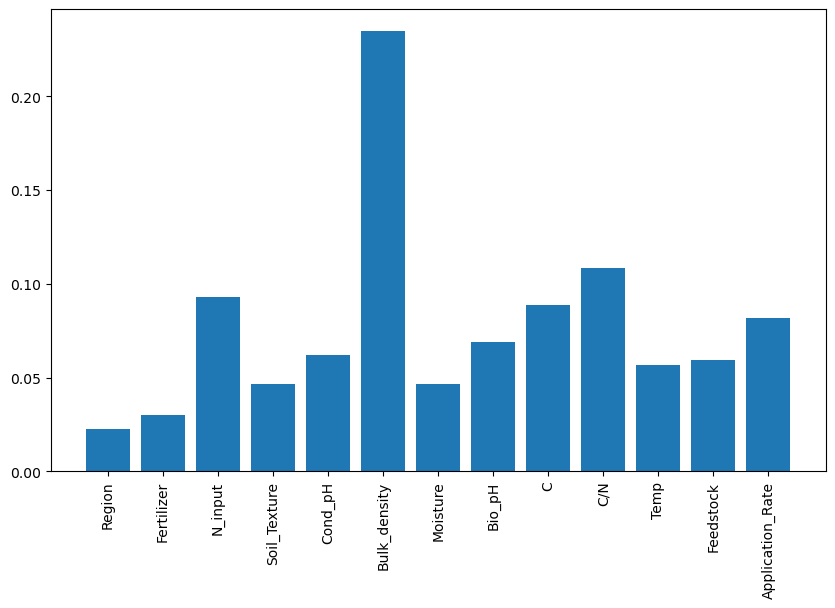

In [58]:
plt.bar(best_model.feature_names_in_, f_importances)
plt.xticks(rotation=90)
plt.show()

## 최적 모델 활용

### 특성 중요도

참고: 

1. https://mljar.com/blog/feature-importance-xgboost/
1. https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7

결정트리 훈련 과정에서 사용된 특성의 중요도는 아래 세 가지 기준으로 확인한다.

- `gain`: 해당 특성으로 분할할 때 분할된 두 그룹의 순수도가 얼마나 높아지는가를 평가
- `weight`: 해당 특성이 노드 분할에 사용된 횟수
- `cover`: 잎 노드 결정에 사용된 횟수

그런데 세 경우 모두 특성 중요도를 일반적으로 확실하게 분석하기 어렵다. 
하지만 앞서 본 결정트리의 모양을 보면 `weight`가 여기서는 중됴도를 잘 반영하는 것으로 보인다.

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

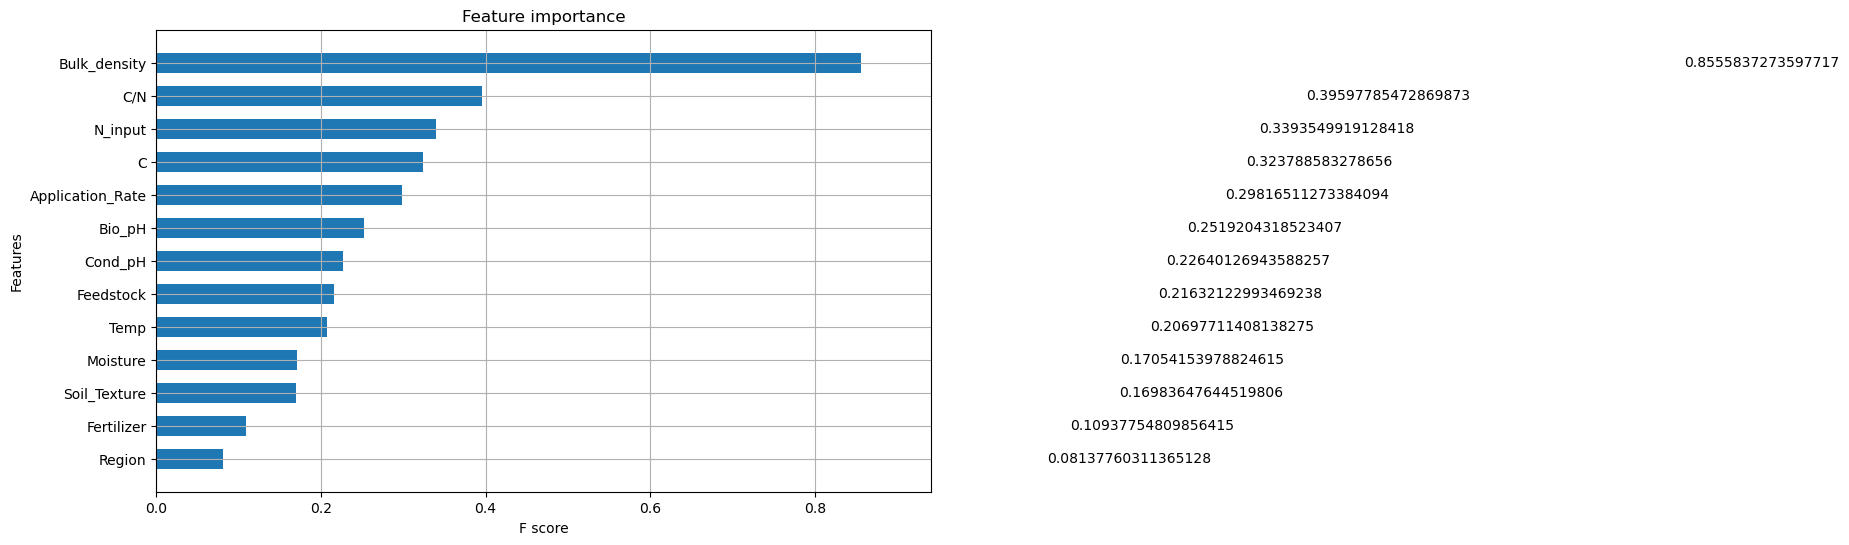

In [59]:
xgb.plot_importance(best_model, height=0.6, importance_type="gain")

## Shap Values 활용 특성 중요도 분석

- 참고
    - https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html
    - https://stackoverflow.com/questions/66560839/what-do-maskers-really-do-in-shap-package-and-fit-them-to-train-or-test
    - https://arxiv.org/pdf/2006.16234    

**준비**

In [60]:
# !pip install shap
import shap
shap.initjs()

**Shap values 계산**

In [61]:
explainer = shap.TreeExplainer(best_model)
explanation = explainer(X)
shap_values = explanation.values

In [62]:
shap_values.shape

(402, 13)

**Shap values 의미**

- `base_values`: 모델 예측값들의 평균값 $E[f(x)]$

In [63]:
explanation.base_values

array([0.82000107, 0.82000107, 0.82000107, 0.82000107, 0.82000107,
       0.82000107, 0.82000107, 0.82000107, 0.82000107, 0.82000107,
       0.82000107, 0.82000107, 0.82000107, 0.82000107, 0.82000107,
       0.82000107, 0.82000107, 0.82000107, 0.82000107, 0.82000107,
       0.82000107, 0.82000107, 0.82000107, 0.82000107, 0.82000107,
       0.82000107, 0.82000107, 0.82000107, 0.82000107, 0.82000107,
       0.82000107, 0.82000107, 0.82000107, 0.82000107, 0.82000107,
       0.82000107, 0.82000107, 0.82000107, 0.82000107, 0.82000107,
       0.82000107, 0.82000107, 0.82000107, 0.82000107, 0.82000107,
       0.82000107, 0.82000107, 0.82000107, 0.82000107, 0.82000107,
       0.82000107, 0.82000107, 0.82000107, 0.82000107, 0.82000107,
       0.82000107, 0.82000107, 0.82000107, 0.82000107, 0.82000107,
       0.82000107, 0.82000107, 0.82000107, 0.82000107, 0.82000107,
       0.82000107, 0.82000107, 0.82000107, 0.82000107, 0.82000107,
       0.82000107, 0.82000107, 0.82000107, 0.82000107, 0.82000

- `base_values` + `shap_values` = `pred`

In [64]:
shap_values[0].sum() + explanation.base_values[0] - pred[0]

0.0

- 예측값과의 최대 오차: 거의 0

In [65]:
pred = best_model.predict(X, output_margin=True)
np.abs(shap_values.sum(axis=1) + explanation.base_values - pred).max()

2.3841858e-07

**Summary of the effects of all the features**

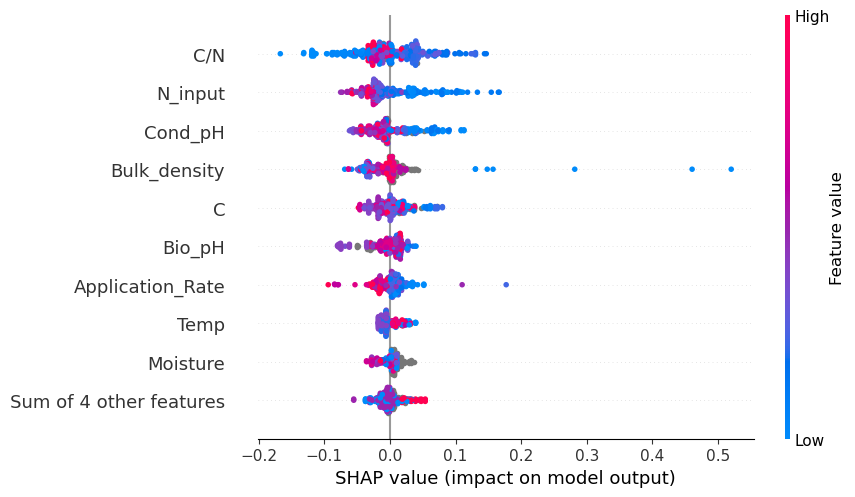

In [66]:
shap.plots.beeswarm(explanation)

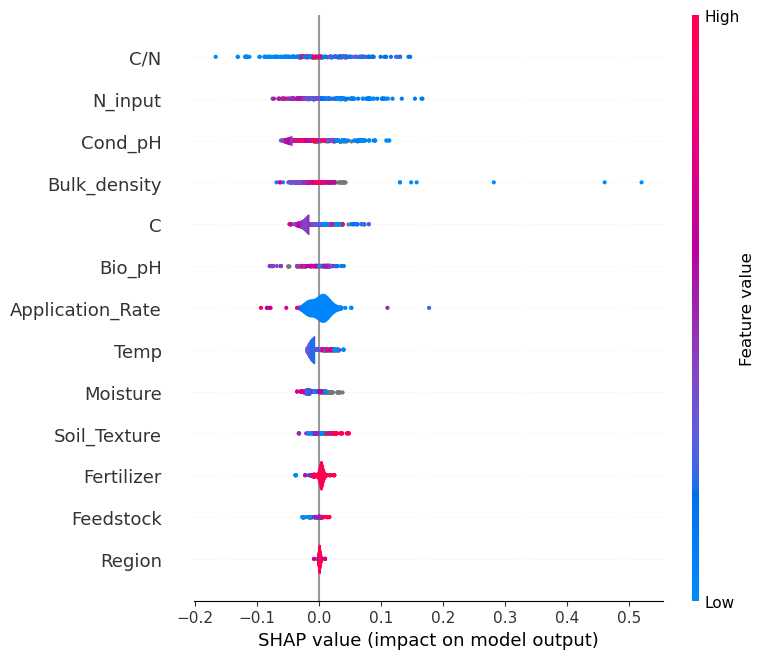

In [67]:
shap.summary_plot(explanation, plot_type='violin')

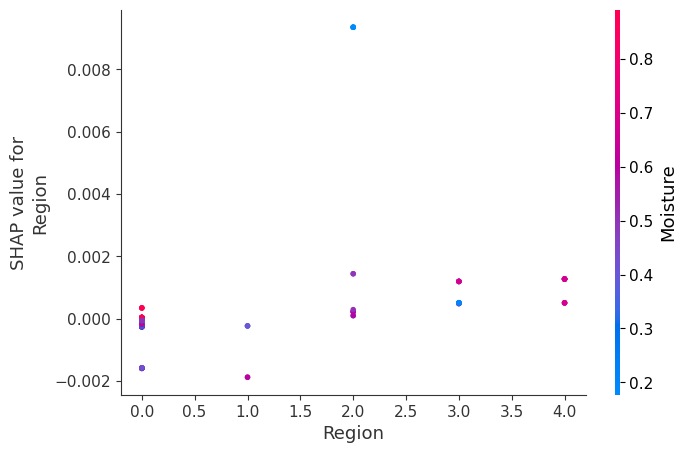

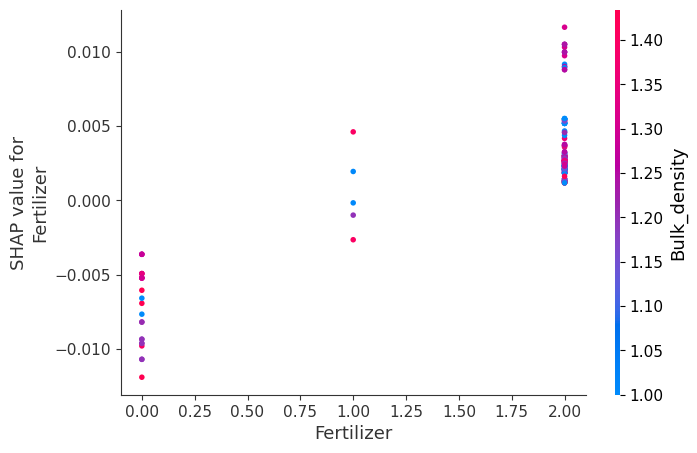

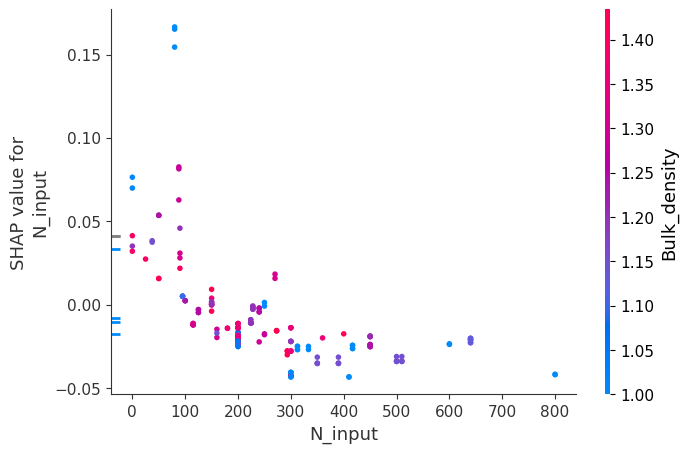

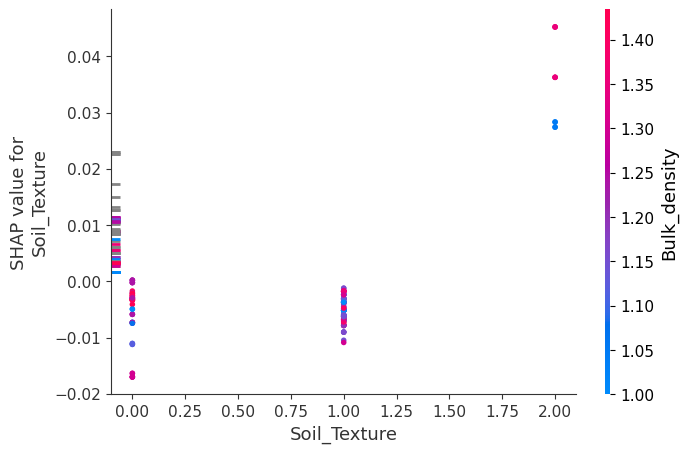

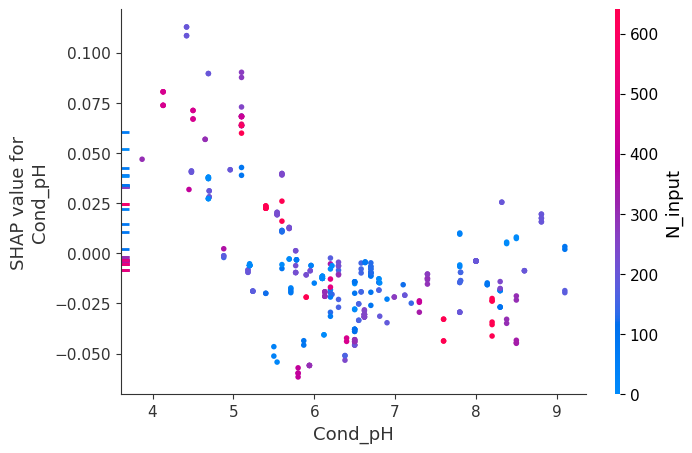

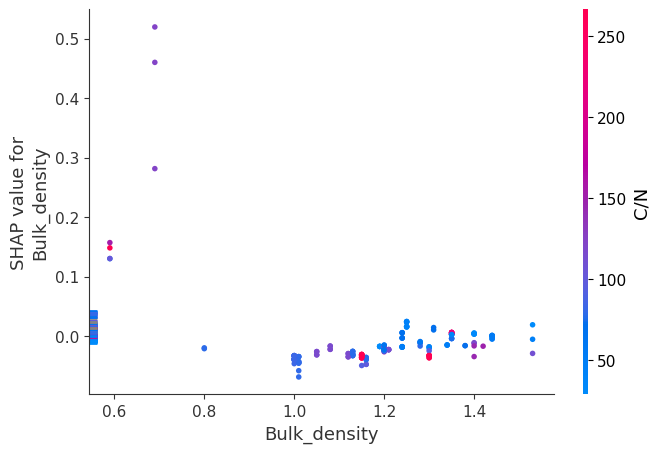

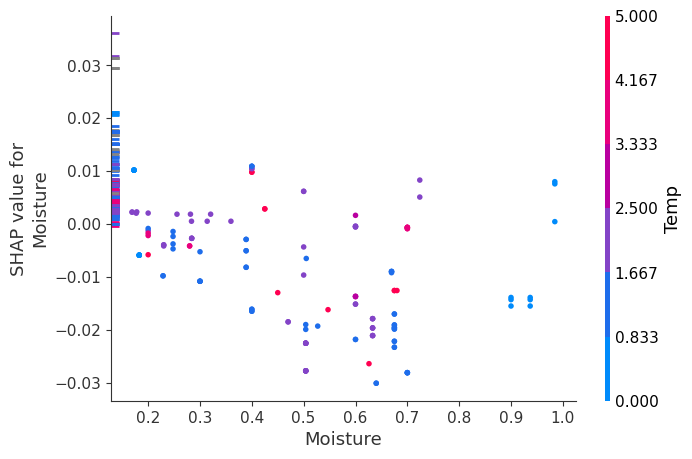

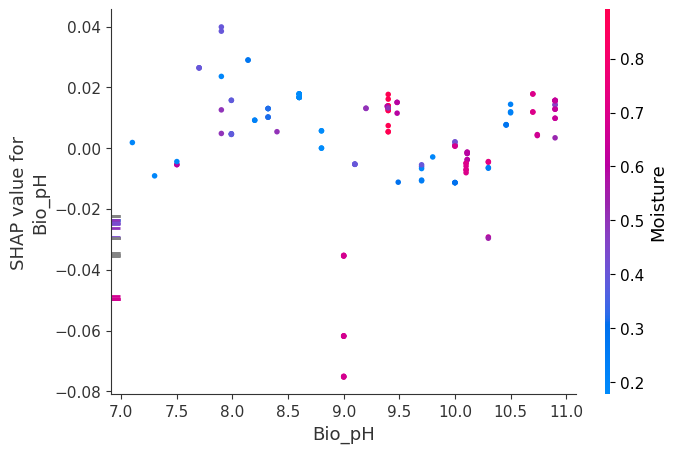

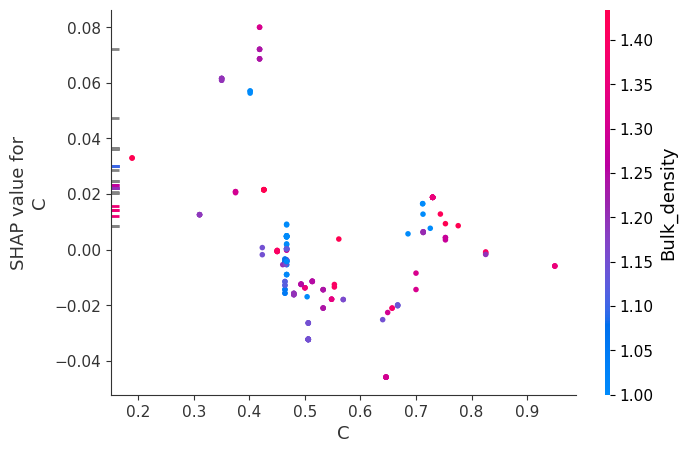

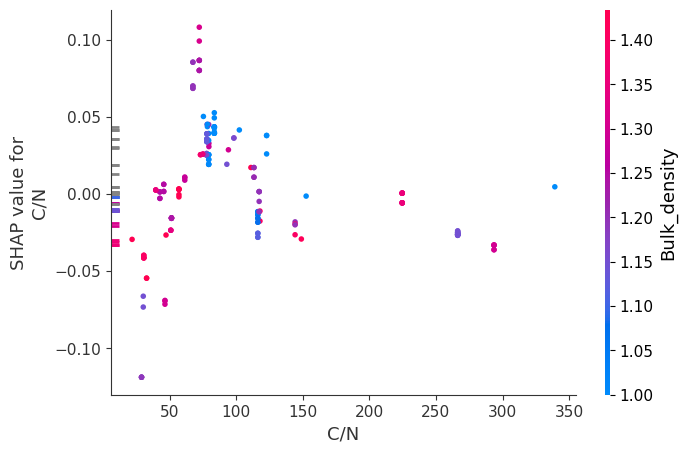

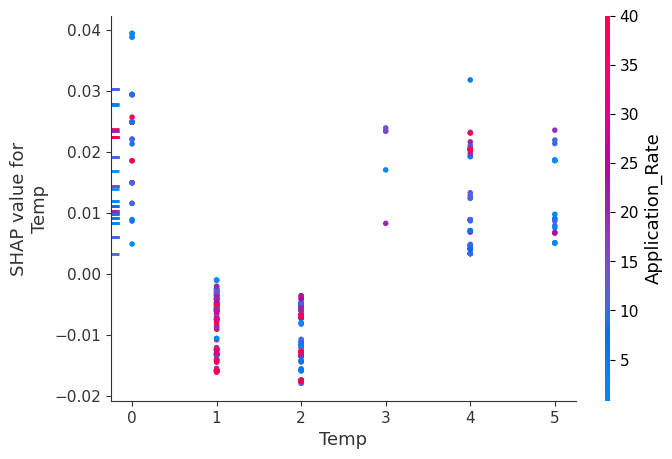

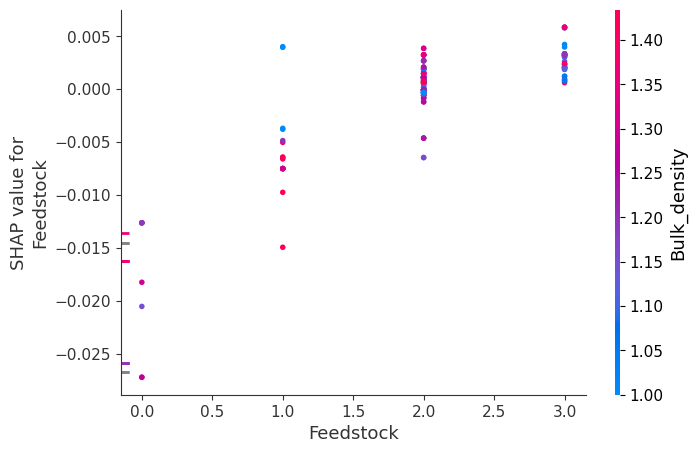

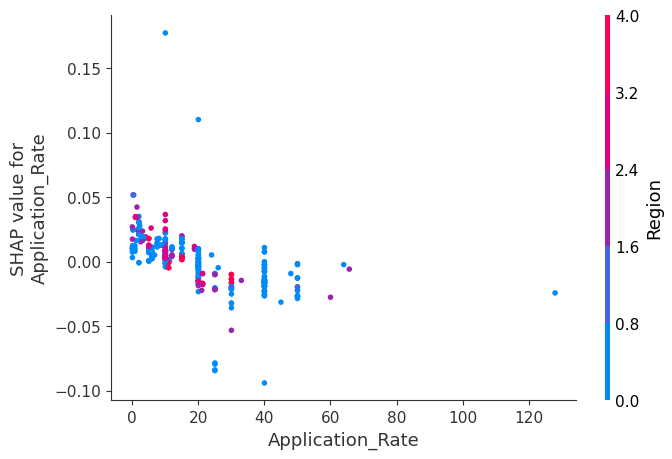

In [68]:
for i in range(len(core_encoded.columns) - 1):
    shap.dependence_plot(i, shap_values, X)

In [69]:
explanation.feature_names

['Region',
 'Fertilizer',
 'N_input',
 'Soil_Texture',
 'Cond_pH',
 'Bulk_density',
 'Moisture',
 'Bio_pH',
 'C',
 'C/N',
 'Temp',
 'Feedstock',
 'Application_Rate']

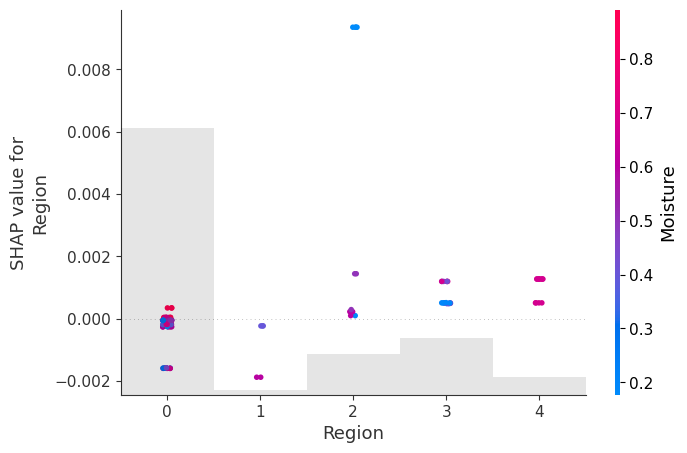

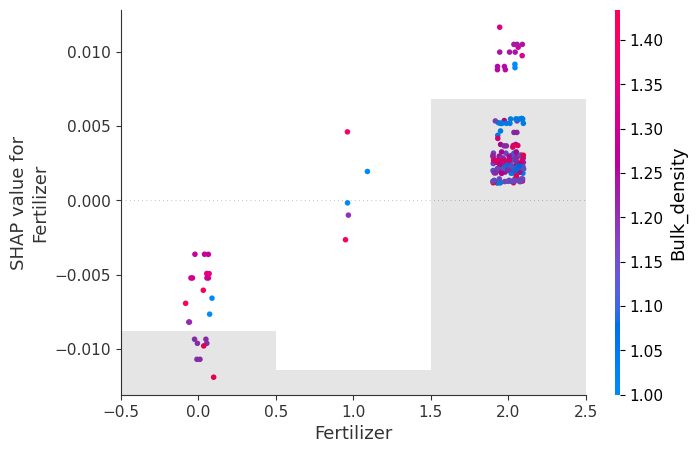

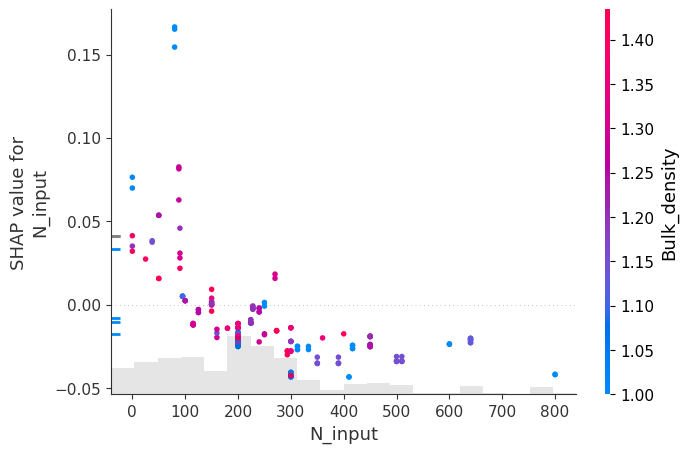

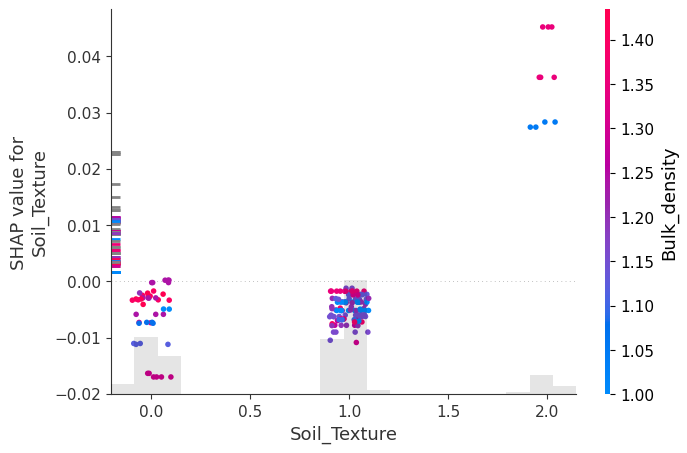

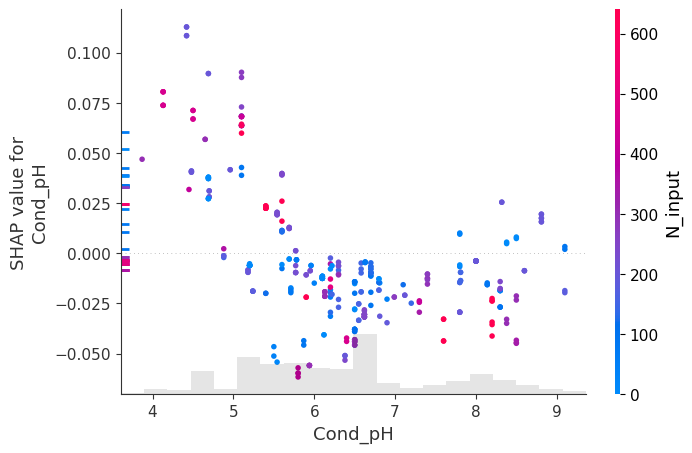

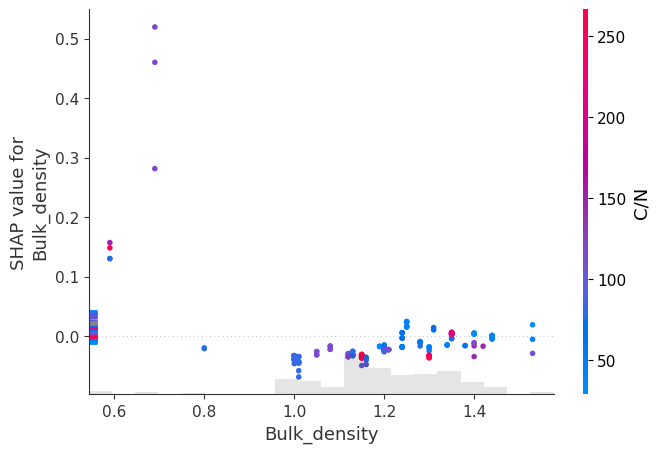

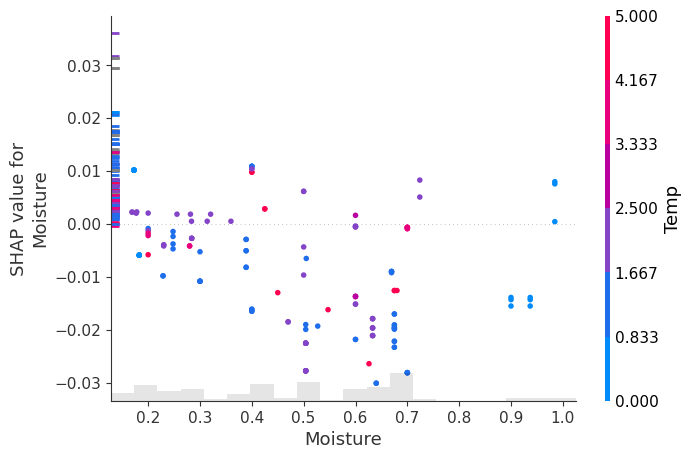

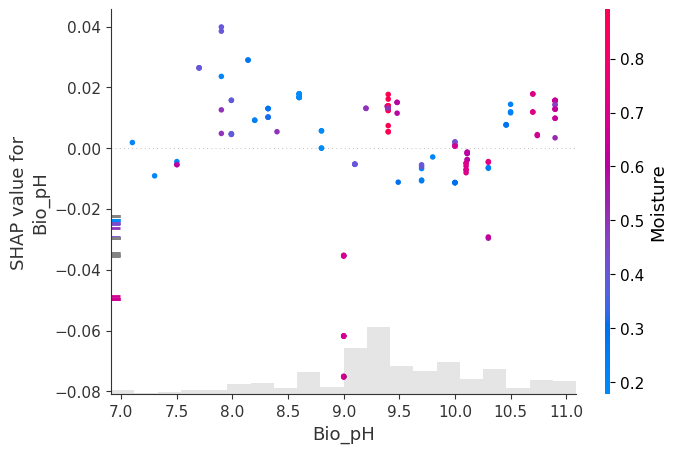

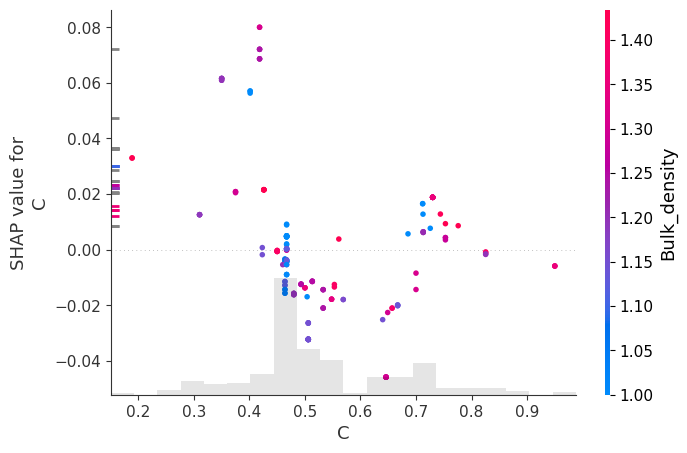

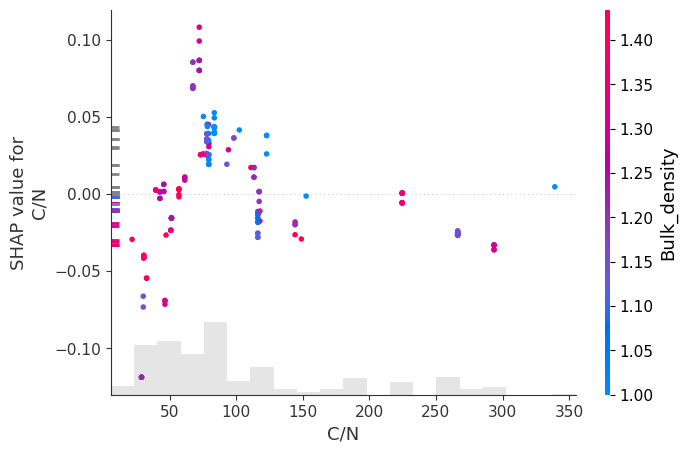

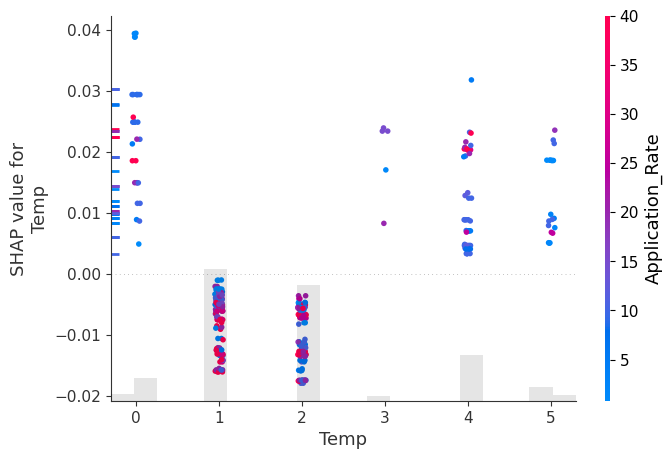

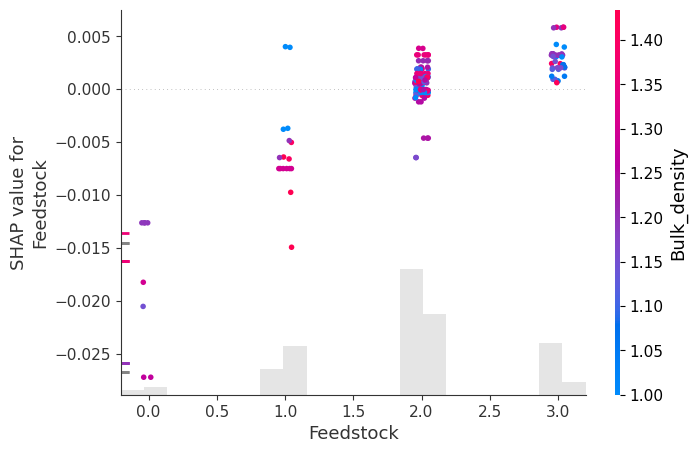

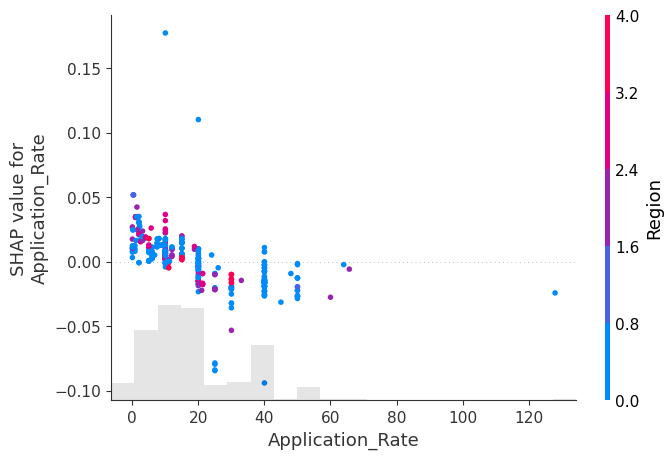

In [70]:
for feature in explanation.feature_names:
    shap.plots.scatter(explanation[:, feature], color=explanation)

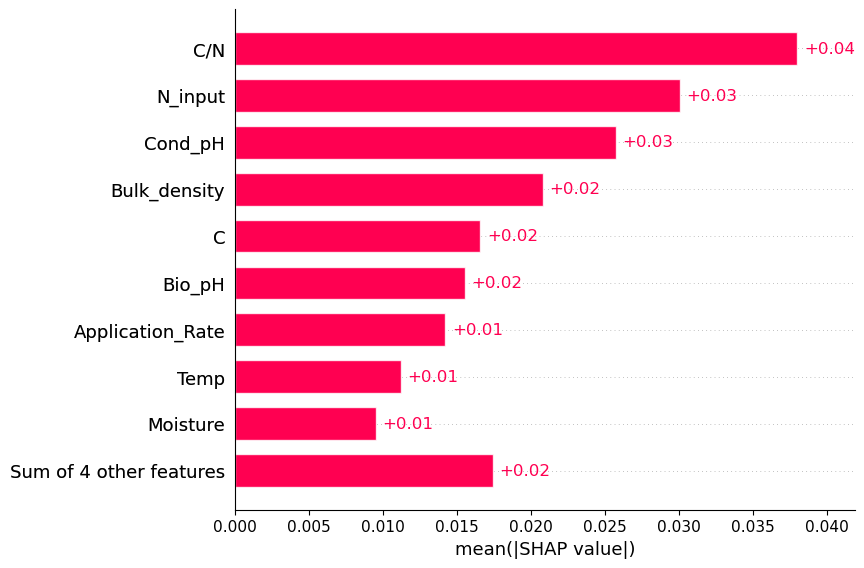

In [72]:
shap.plots.bar(explanation)

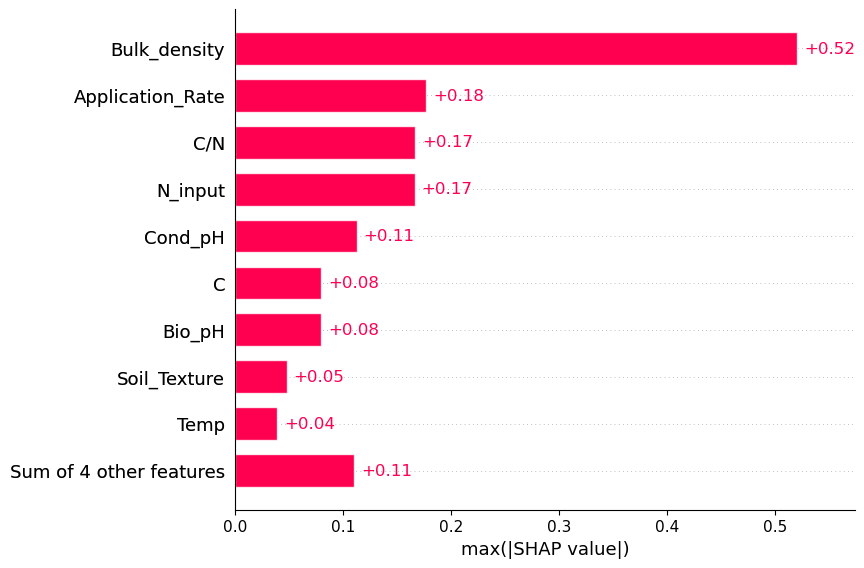

In [73]:
shap.plots.bar(explanation.abs.max(0))

### SHAP partial dependence plots

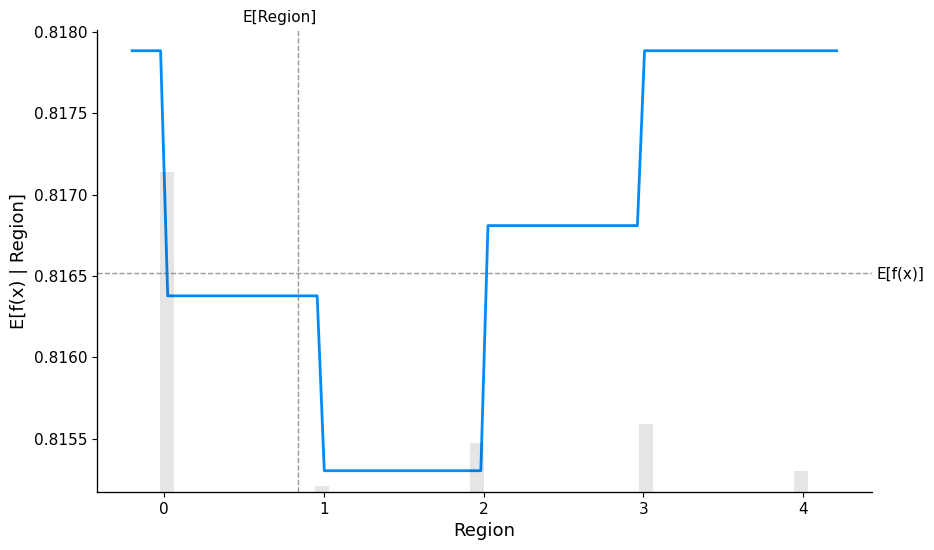

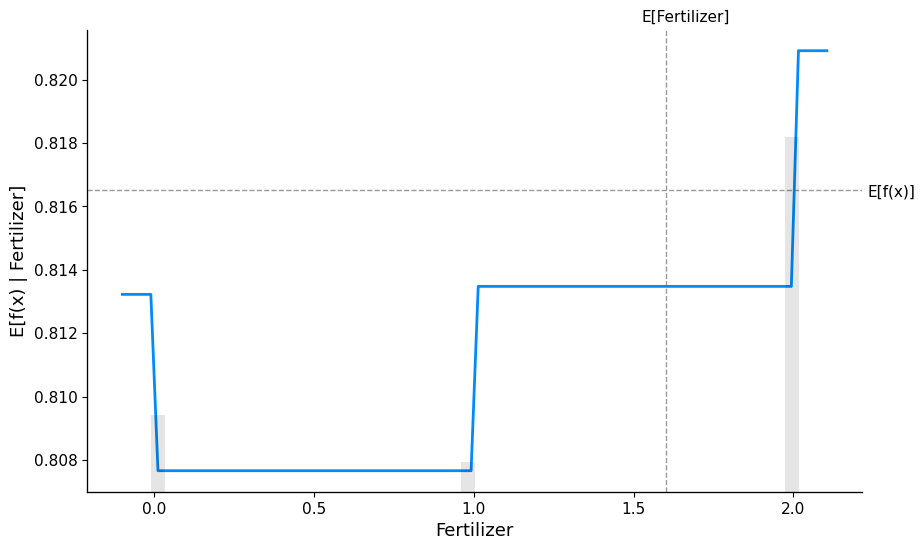

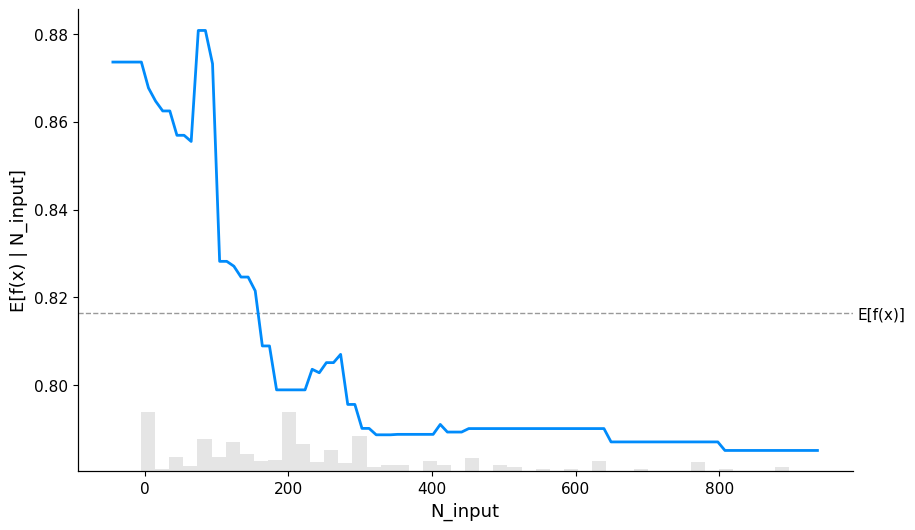

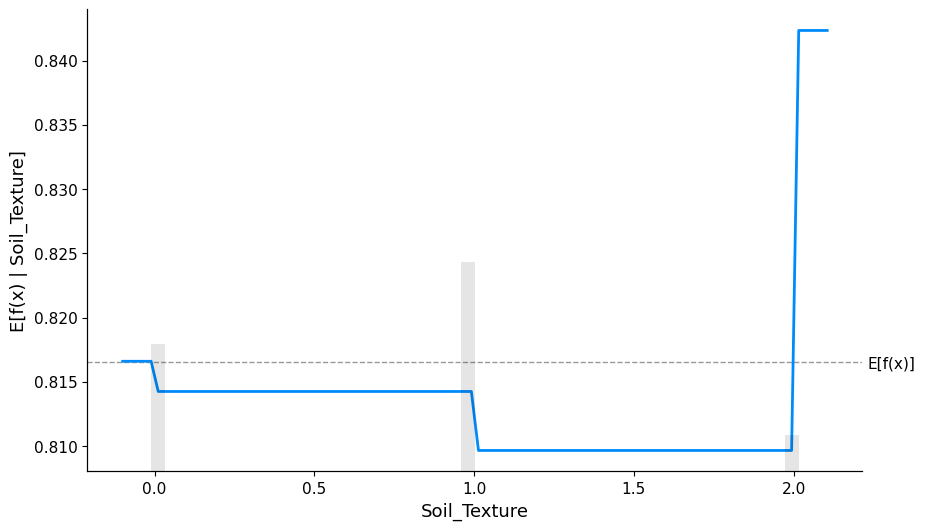

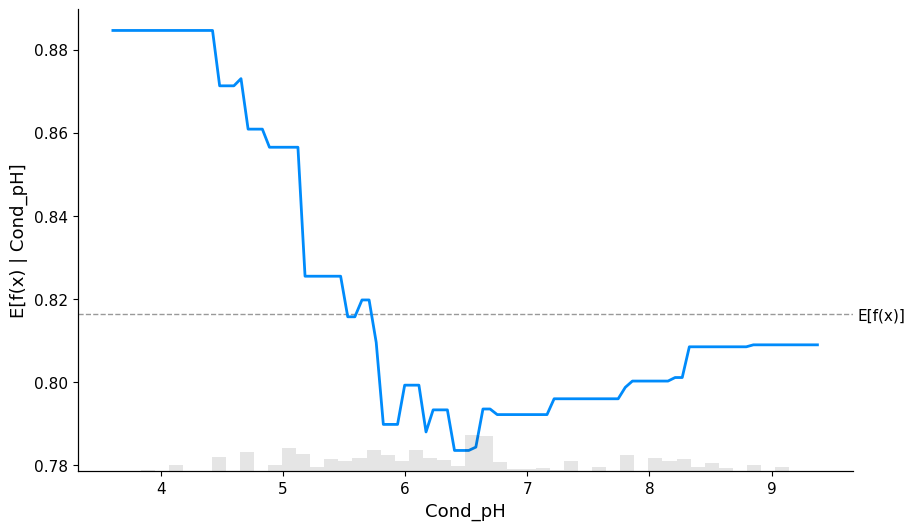

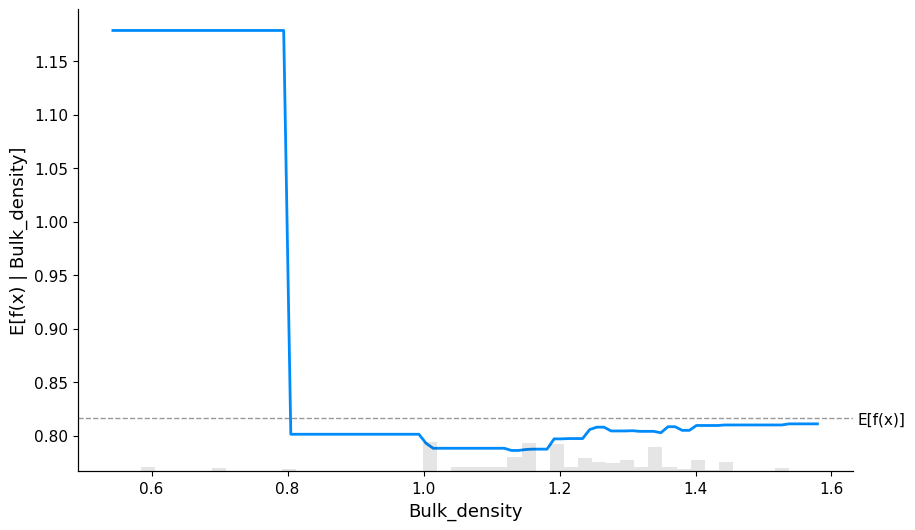

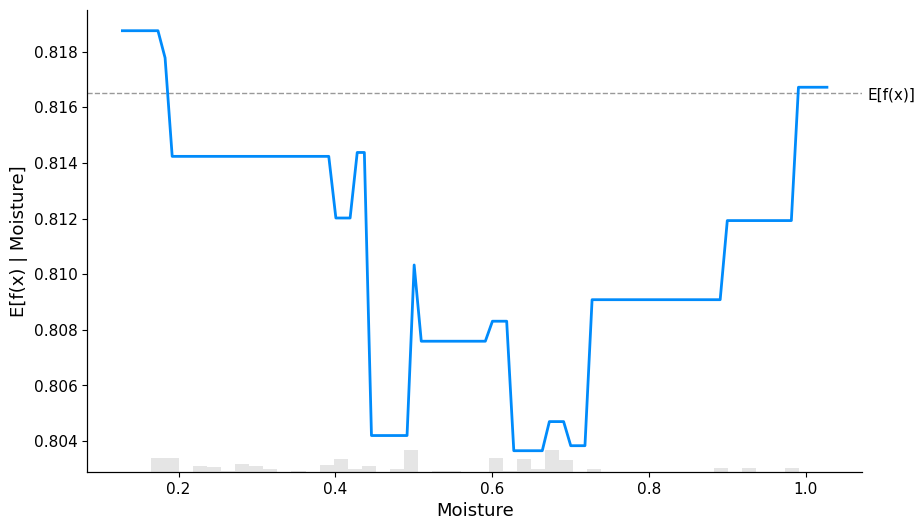

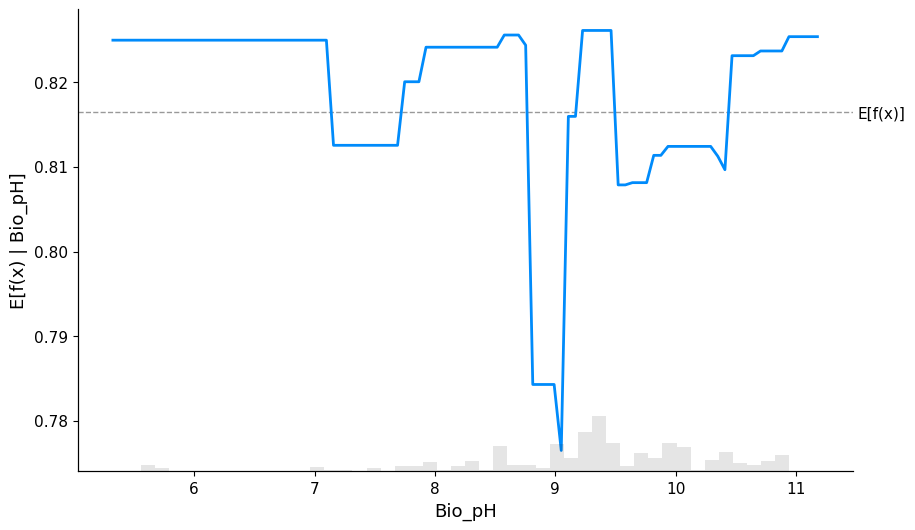

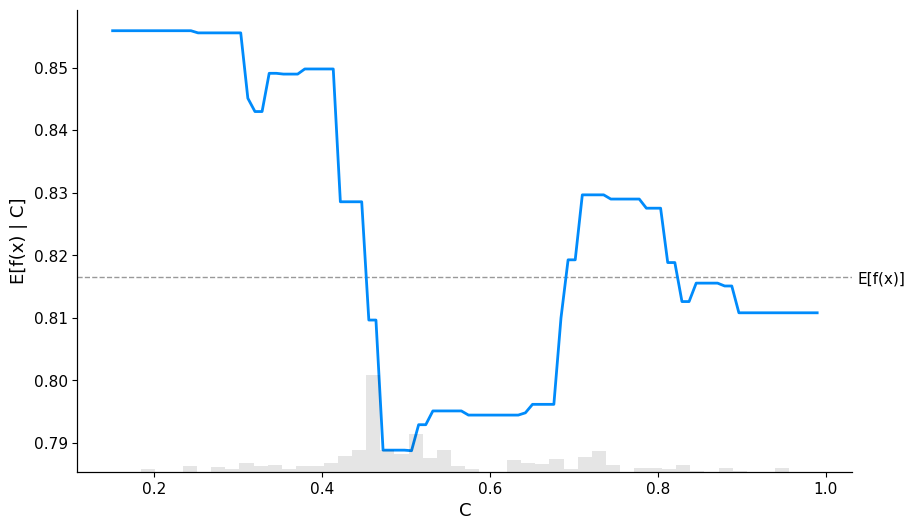

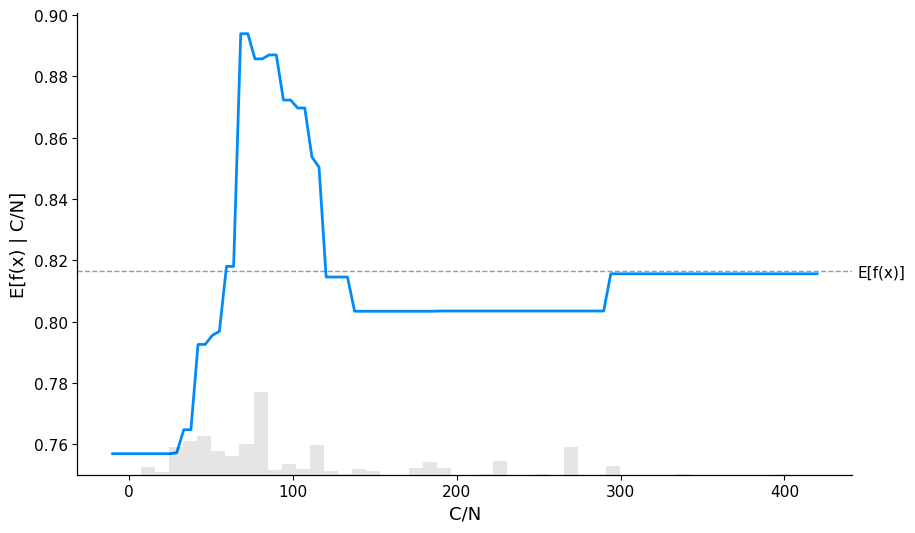

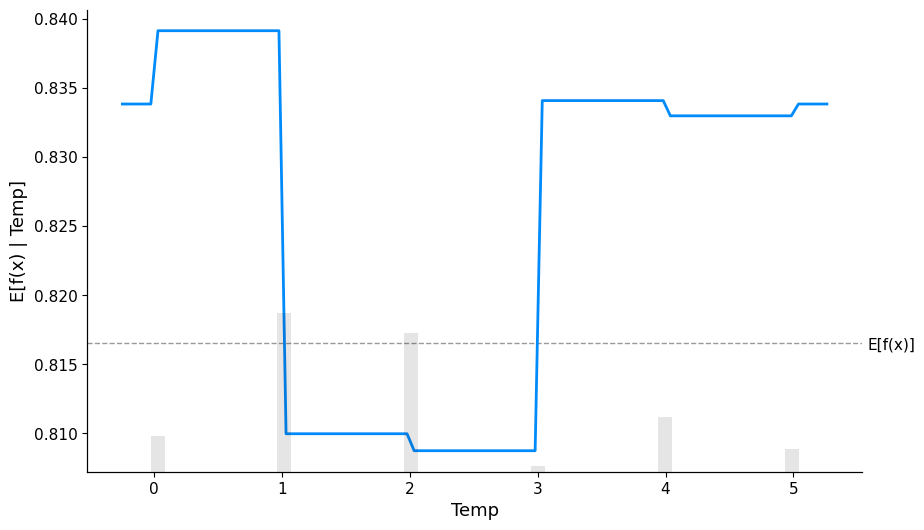

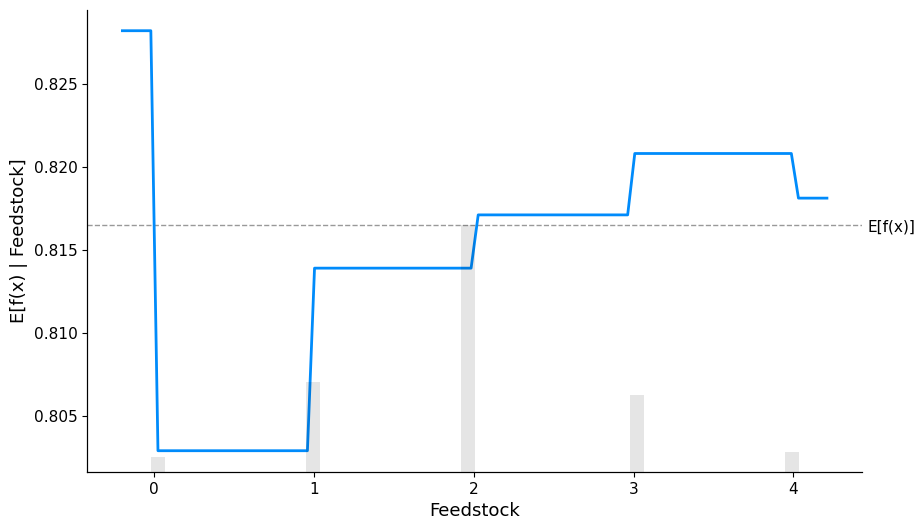

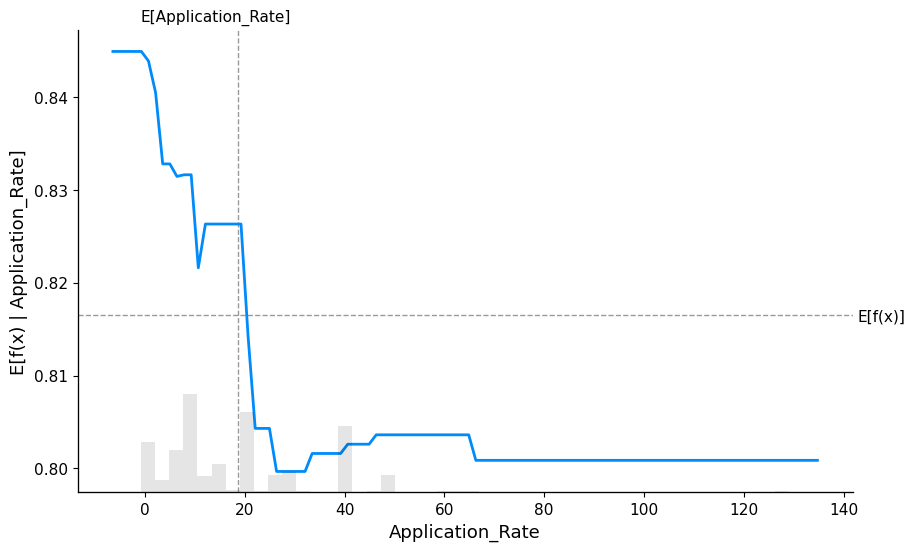

In [74]:
for feature in explanation.feature_names:
    _ = shap.partial_dependence_plot(feature, 
                                     best_model.predict, 
                                     X, 
                                     ice=False,
                                     show=False,
                                     model_expected_value=True, 
                                     feature_expected_value=True,
                                    )

## scikit-learn's partial dependence plot 활용

In [75]:
from sklearn.inspection import PartialDependenceDisplay

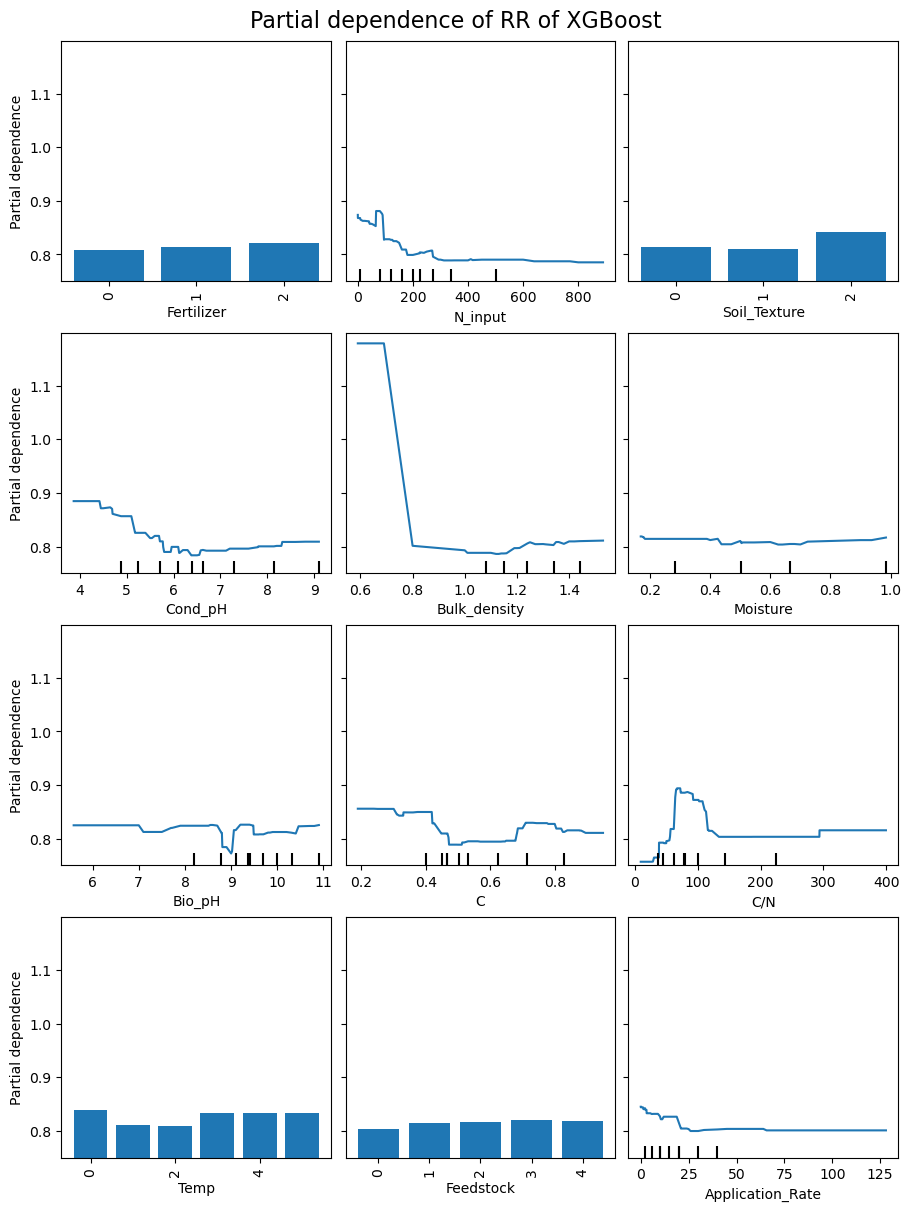

In [76]:
common_params = {
#     "subsample": 50,
#     "n_jobs": 2,
    "grid_resolution": 200,
    "random_state": 0,
}

features_1D = X.columns.to_list()
features_1D.remove('Region')    

features_info = {
    # features of interest
    "features": features_1D,
    # type of partial dependence plot
    "kind": "average",
    # information regarding categorical features
    "categorical_features": cat_features.to_list(),
}

_, ax = plt.subplots(nrows=4, ncols=3, figsize=(9, 12), constrained_layout=True)

display = PartialDependenceDisplay.from_estimator(
    best_model,
    X,
    **features_info,
    ax=ax,
    **common_params,
)

# 추가 정보
_ = display.figure_.suptitle(
    (
        "Partial dependence of RR of XGBoost"
    ),
    fontsize=16,
)

In [77]:
cat_features

Index(['Region', 'Fertilizer', 'Soil_Texture', 'Temp', 'Feedstock'], dtype='object')

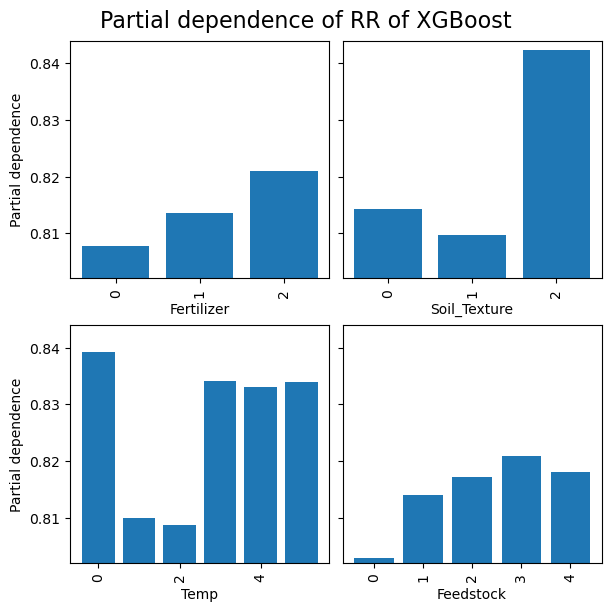

In [78]:
common_params = {
#     "subsample": 50,
#     "n_jobs": 2,
    "grid_resolution": 100,
    "random_state": 0,
}

features_1D = cat_features.to_list()
features_1D.remove('Region')    

features_info = {
    # features of interest
    "features": features_1D,
    # type of partial dependence plot
    "kind": "average",
    # information regarding categorical features
    "categorical_features": cat_features.to_list(),
}

_, ax = plt.subplots(nrows=2, ncols=2, figsize=(6, 6), constrained_layout=True)

display = PartialDependenceDisplay.from_estimator(
    best_model,
    X,
    **features_info,
    ax=ax,
    **common_params,
)

# 추가 정보
_ = display.figure_.suptitle(
    (
        "Partial dependence of RR of XGBoost"
    ),
    fontsize=16,
)

In [79]:
num_features = field.select_dtypes(include=['float64']).columns
num_features

Index(['N_input', 'Cond_pH', 'Bulk_density', 'Moisture', 'Bio_pH', 'C', 'C/N',
       'Application_Rate', 'RR'],
      dtype='object')

In [80]:
len(num_features)

9

In [81]:
display.pd_results[0]

{'grid_values': [array([0., 1., 2.])],
 'average': array([[0.8076625 , 0.81347924, 0.8209148 ]], dtype=float32)}

In [82]:
display.pd_results[2]['grid_values']

[array([ 0.,  1.,  2.,  3.,  4.,  5., nan])]

In [83]:
display.pd_results[1]

{'grid_values': [array([ 0.,  1.,  2., nan])],
 'average': array([[0.8142587 , 0.8096696 , 0.84234756, 0.8244458 ]], dtype=float32)}

In [84]:
display.pd_results[1]['average'].max()

0.84234756

In [85]:
display.pd_results[1]['average'].min()

0.8096696

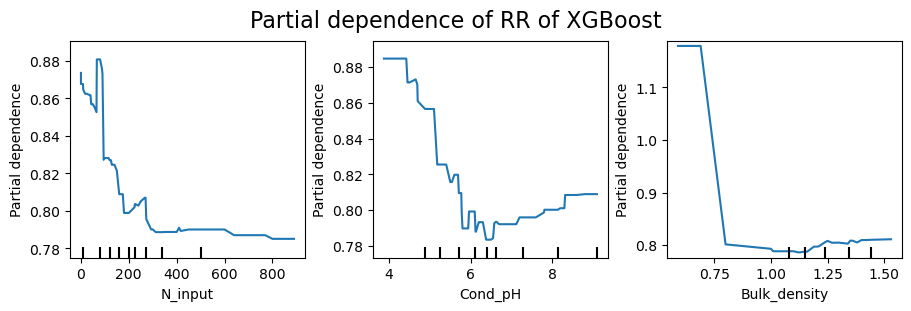

In [86]:
# from itertools import product

common_params = {
#     "subsample": 50,
#     "n_jobs": 2,
    "grid_resolution": 200,
    "random_state": 0,
}

features_1D = num_features.to_list()
features_1D.remove('RR')

features_info = {
    "features": features_1D[:3],
    "kind": "average",
}

nrows = 1
ncols = 3

_, ax = plt.subplots(nrows=nrows, 
                     ncols=ncols, 
                     sharex=False,
                     sharey=False,
                     figsize=(ncols*3, nrows*3),
                     constrained_layout=True)

display = PartialDependenceDisplay.from_estimator(
    best_model,
    X,
    **features_info,
    ax=ax,
    **common_params,
)

for i in range(3):
    ymin = display.pd_results[i]['average'].min()-0.01
    ymax = display.pd_results[i]['average'].max()+0.01
    display.axes_[i].set_ylim(ymin, ymax)

# 추가 정보
_ = display.figure_.suptitle(
    (
        "Partial dependence of RR of XGBoost"
    ),
    fontsize=16,
)

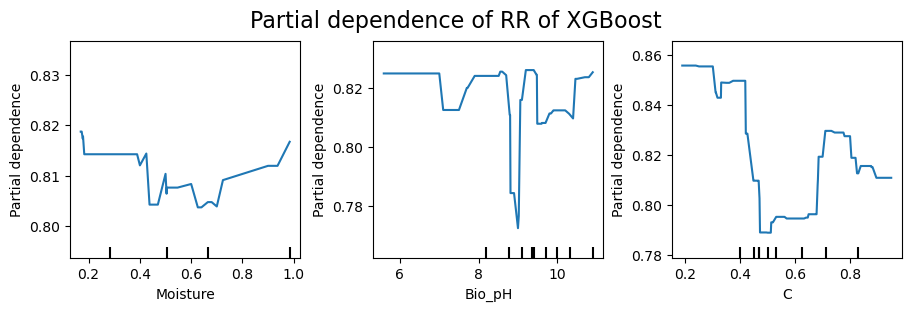

In [87]:
# from itertools import product

common_params = {
#     "subsample": 50,
#     "n_jobs": 2,
    "grid_resolution": 200,
    "random_state": 0,
}

features_1D = num_features.to_list()
features_1D.remove('RR')

features_info = {
    "features": features_1D[3:6],
    "kind": "average",
}

nrows = 1
ncols = 3

_, ax = plt.subplots(nrows=nrows, 
                     ncols=ncols, 
                     sharex=False,
                     sharey=False,
                     figsize=(ncols*3, nrows*3),
                     constrained_layout=True)

display = PartialDependenceDisplay.from_estimator(
    best_model,
    X,
    **features_info,
    ax=ax,
    **common_params,
)

for i in range(3):
    ymin = display.pd_results[i]['average'].min()-0.01
    ymax = display.pd_results[i]['average'].max()+0.01
    display.axes_[i].set_ylim(ymin, ymax)

# 추가 정보
_ = display.figure_.suptitle(
    (
        "Partial dependence of RR of XGBoost"
    ),
    fontsize=16,
)

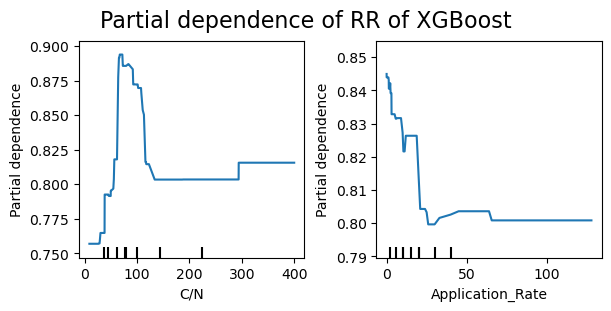

In [88]:
# from itertools import product

common_params = {
#     "subsample": 50,
#     "n_jobs": 2,
    "grid_resolution": 200,
    "random_state": 0,
}

features_1D = num_features.to_list()
features_1D.remove('RR')

features_info = {
    "features": features_1D[6:8],
    "kind": "average",
}

nrows = 1
ncols = 2

_, ax = plt.subplots(nrows=nrows, 
                     ncols=ncols, 
                     sharex=False,
                     sharey=False,
                     figsize=(ncols*3, nrows*3),
                     constrained_layout=True)

display = PartialDependenceDisplay.from_estimator(
    best_model,
    X,
    **features_info,
    ax=ax,
    **common_params,
)

for i in range(2):
    ymin = display.pd_results[i]['average'].min()-0.01
    ymax = display.pd_results[i]['average'].max()+0.01
    display.axes_[i].set_ylim(ymin, ymax)

# 추가 정보
_ = display.figure_.suptitle(
    (
        "Partial dependence of RR of XGBoost"
    ),
    fontsize=16,
)

## 2D interaction plots

- 다음 4개의 조합이 두 특성들 사이의 상관관계가 어느 정도 있음을 보여줌.

In [106]:
features_2D = [('Fertilizer', 'Application_Rate'),
               ('Soil_Texture', 'Application_Rate'),
               ('Temp', 'Fertilizer'),
               ('Temp', 'Application_Rate'),
              ]

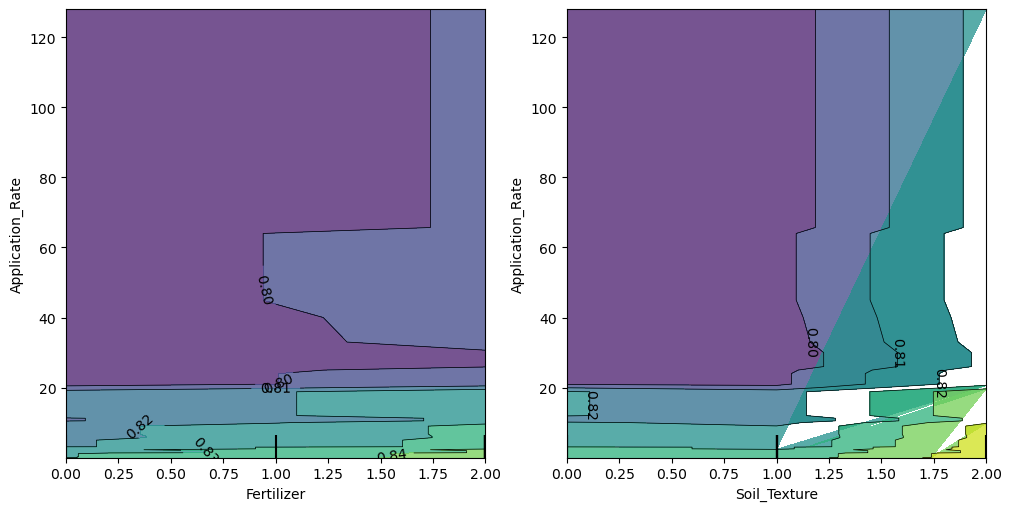

In [107]:
# from itertools import product

common_params = {
#     "subsample": 50,
#     "n_jobs": 2,
    "grid_resolution": 400,
    "random_state": 0,
}

n = 0
start = n*2
end = n*2+2


features_info = {
    "features": features_2D[start:end],
    "kind": "average",
}

nrows = 1
ncols = 2

_, ax = plt.subplots(nrows=nrows, 
                     ncols=ncols, 
                     sharex=False,
                     sharey=False,
                     figsize=(ncols*5, nrows*5),
                     constrained_layout=True)

display = PartialDependenceDisplay.from_estimator(
    best_model,
    X,
    **features_info,
    ax=ax,
    **common_params,
)

for i in range(2):
    feature_i, feature_j = features_2D[start+i]

    grid_values = display.pd_results[i]['grid_values']
    xmin = np.nanmin(grid_values[0])
    xmax = np.nanmax(grid_values[0])

    ymin = np.nanmin(grid_values[1])
    ymax = np.nanmax(grid_values[1])

    display.axes_[i].set_xlim(xmin, xmax)
    display.axes_[i].set_ylim(ymin, ymax)

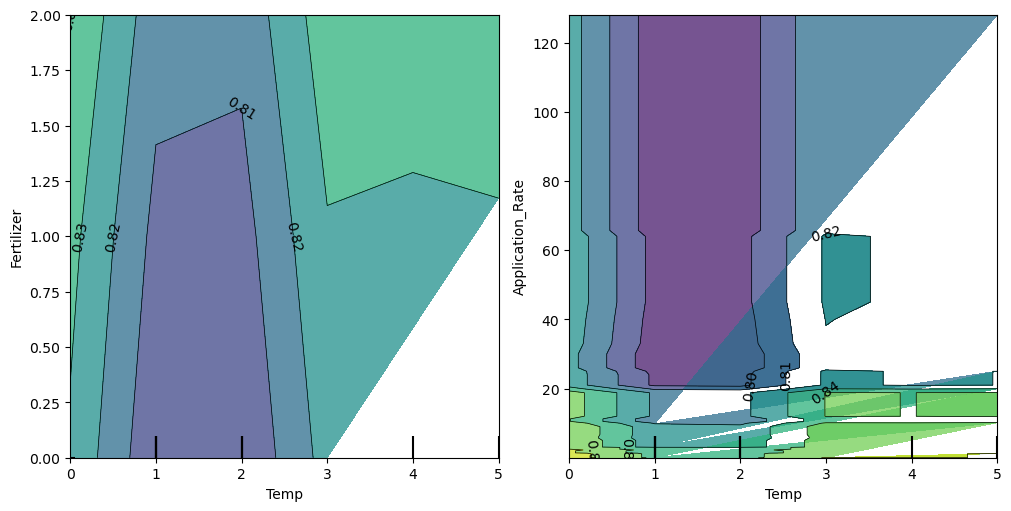

In [108]:
# from itertools import product

common_params = {
#     "subsample": 50,
#     "n_jobs": 2,
    "grid_resolution": 400,
    "random_state": 0,
}

n = 1
start = n*2
end = n*2+2


features_info = {
    "features": features_2D[start:end],
    "kind": "average",
}

nrows = 1
ncols = 2

_, ax = plt.subplots(nrows=nrows, 
                     ncols=ncols, 
                     sharex=False,
                     sharey=False,
                     figsize=(ncols*5, nrows*5),
                     constrained_layout=True)

display = PartialDependenceDisplay.from_estimator(
    best_model,
    X,
    **features_info,
    ax=ax,
    **common_params,
)

for i in range(2):
    feature_i, feature_j = features_2D[start+i]

    grid_values = display.pd_results[i]['grid_values']
    xmin = np.nanmin(grid_values[0])
    xmax = np.nanmax(grid_values[0])

    ymin = np.nanmin(grid_values[1])
    ymax = np.nanmax(grid_values[1])

    display.axes_[i].set_xlim(xmin, xmax)
    display.axes_[i].set_ylim(ymin, ymax)

### 임의의 두 특성 조합 확인: PD 값 기준

- 임의의 두 특성 조합의 PD값 변화를 그래프로 확인

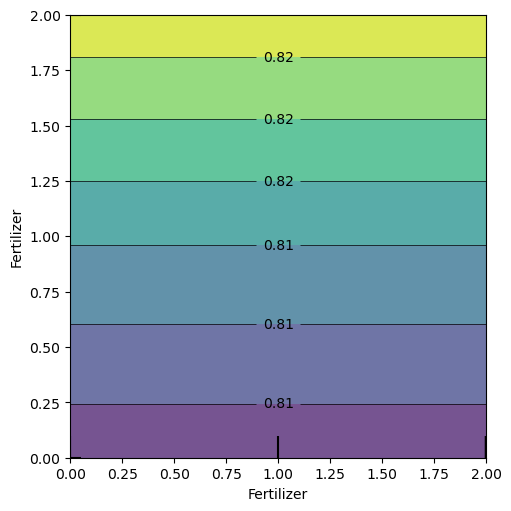

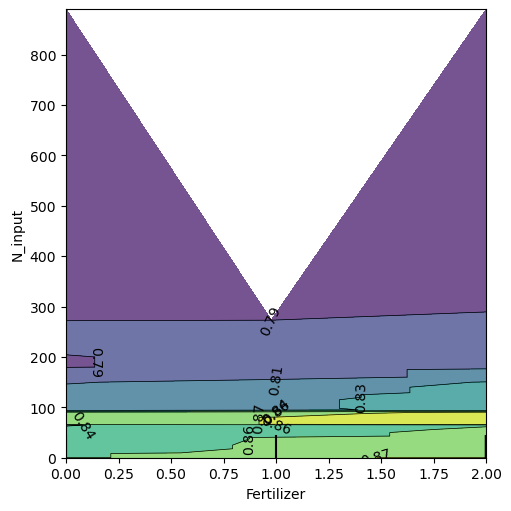

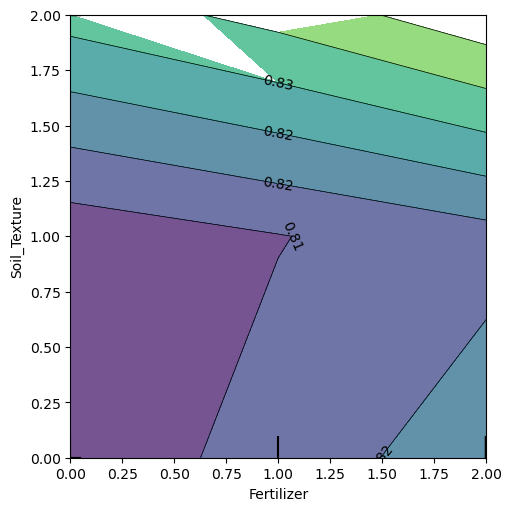

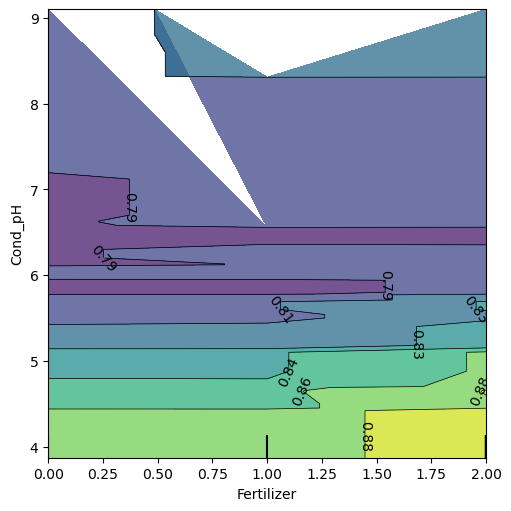

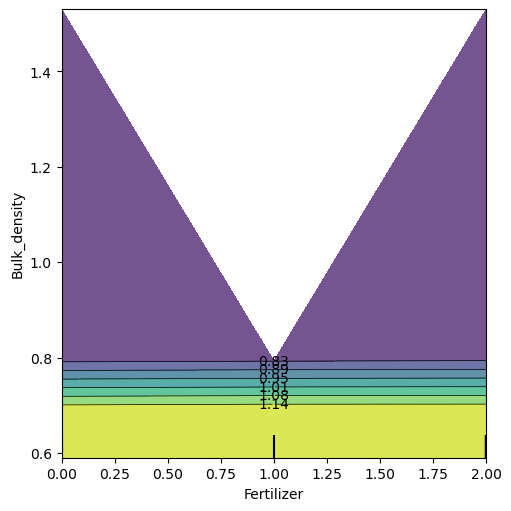

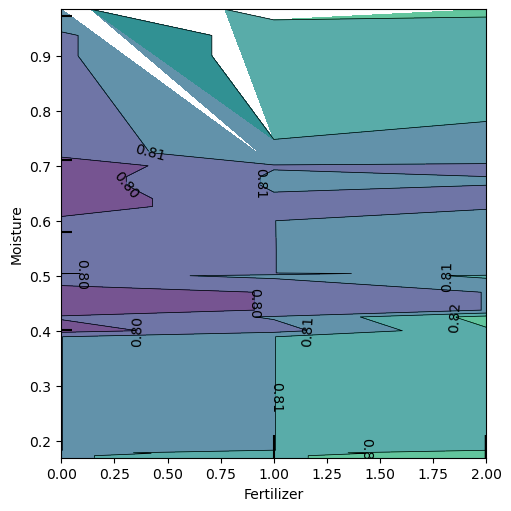

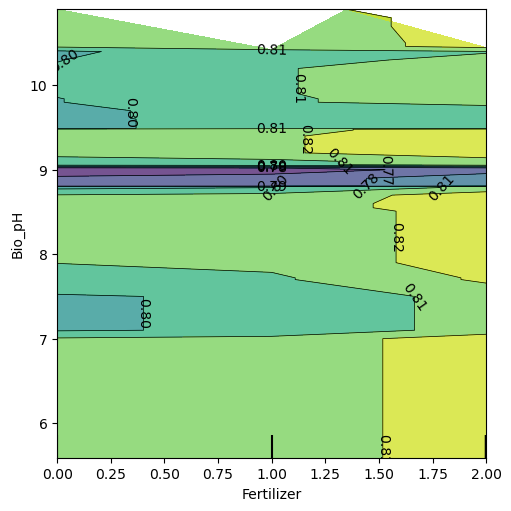

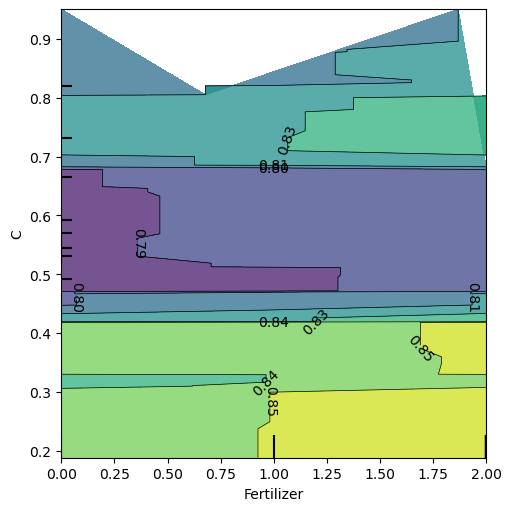

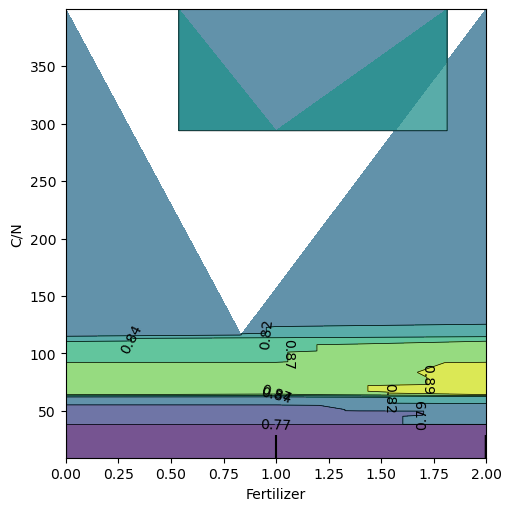

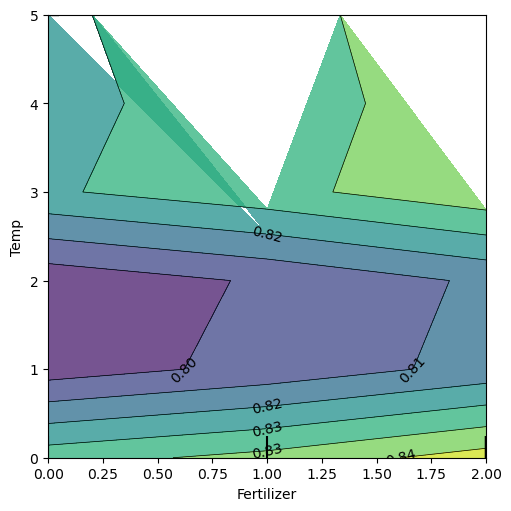

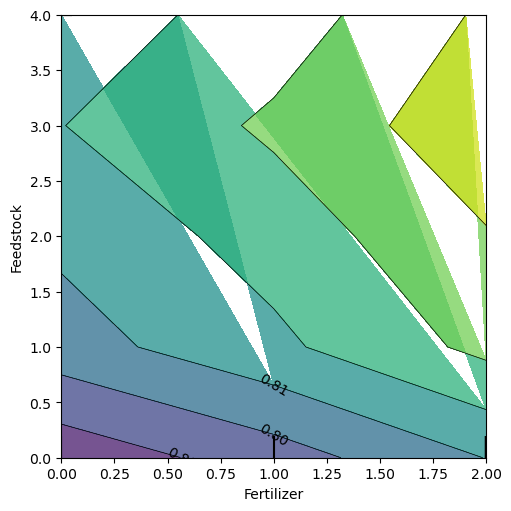

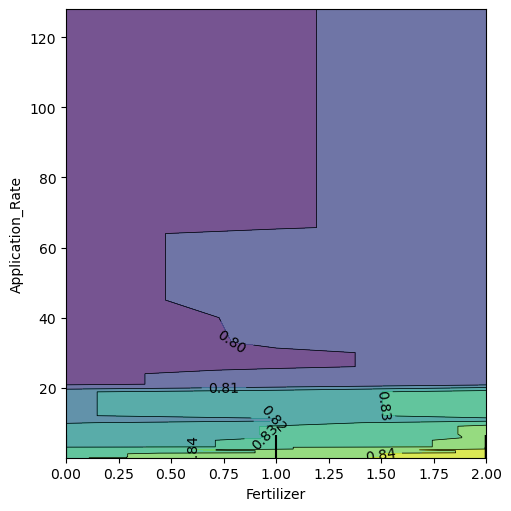

In [92]:
from itertools import product

common_params = {
#     "subsample": 50,
#     "n_jobs": 2,
    "grid_resolution": 400,
    "random_state": 0,
}

features_1D = X.columns.to_list()
features_1D.remove('Region')  
features_2D = list(product(features_1D, repeat=2))

n = 0
start = 12 * n 

for idx_ in range(len(features_2D[start:start+12])):
    idx = start + idx_
    features_info = {
        "features": features_2D[idx:idx+1],
        "kind": "average",
    }

    nrows = 1
    ncols = 1

    _, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5, 5), constrained_layout=True)

    display = PartialDependenceDisplay.from_estimator(
        best_model,
        X,
        **features_info,
        ax=ax,
        **common_params,
    )

    feature_i, feature_j = features_2D[idx]

    if feature_i in cat_features:
        xmin = 0
        xmax = max(list(X[feature_i].unique()))
    else:
        xmin = X[feature_i].min()
        xmax = X[feature_i].max()

    if feature_j in cat_features:
        ymin = 0
        ymax = max(list(X[feature_j].unique()))
    else:
        ymin = X[feature_j].min()
        ymax = X[feature_j].max()

    i, j = 0, 0
    display.axes_[i][j].set_xlim(xmin, xmax)
    display.axes_[i][j].set_ylim(ymin, ymax)

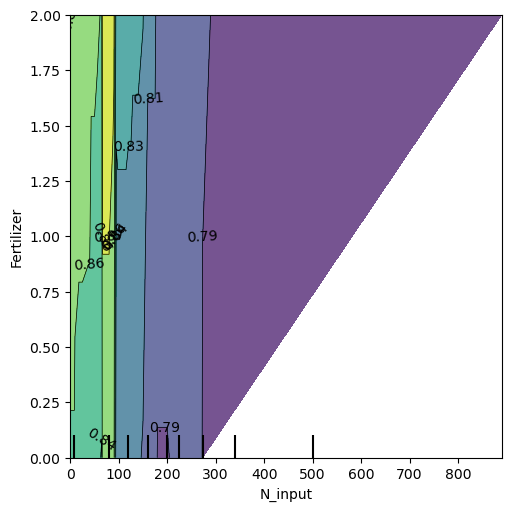

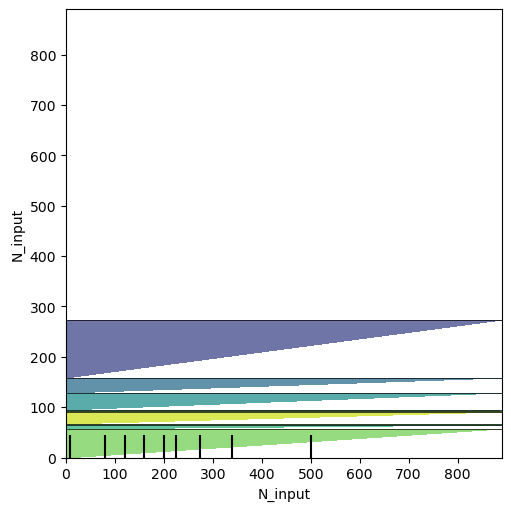

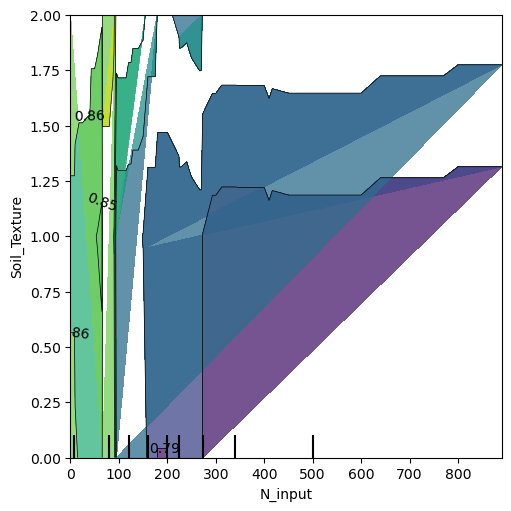

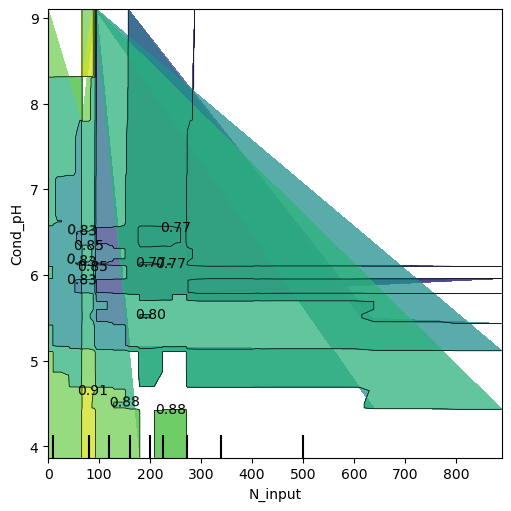

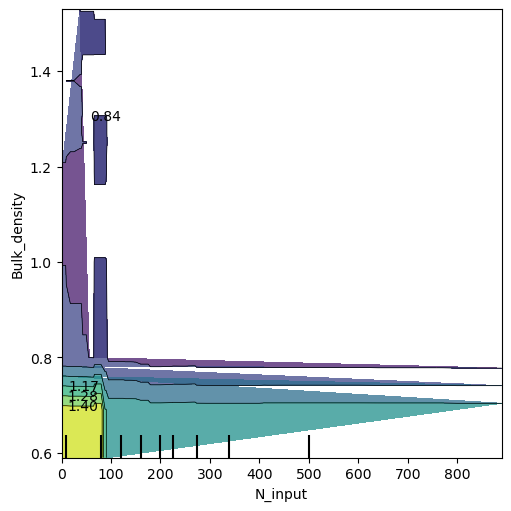

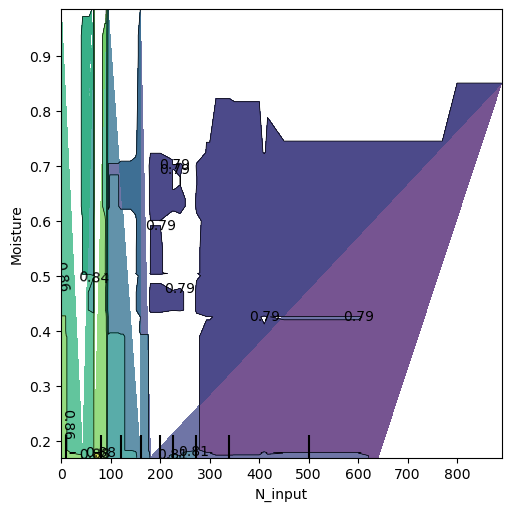

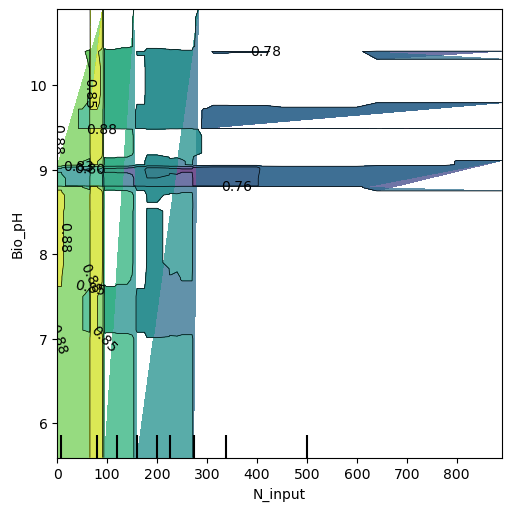

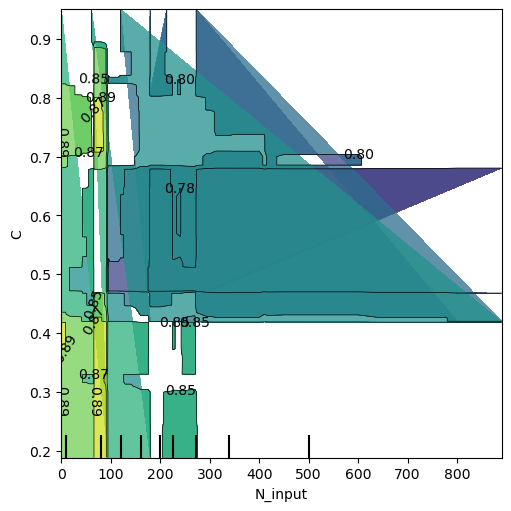

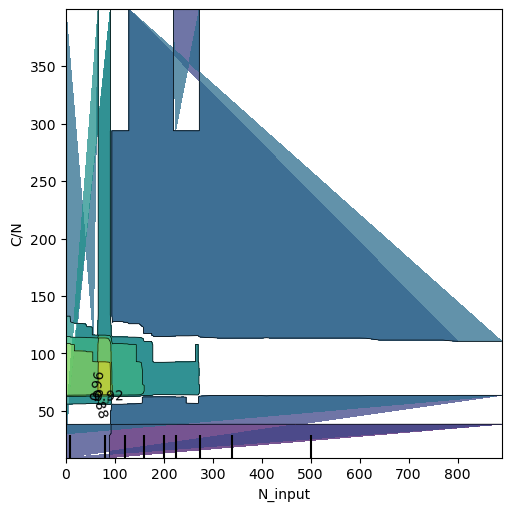

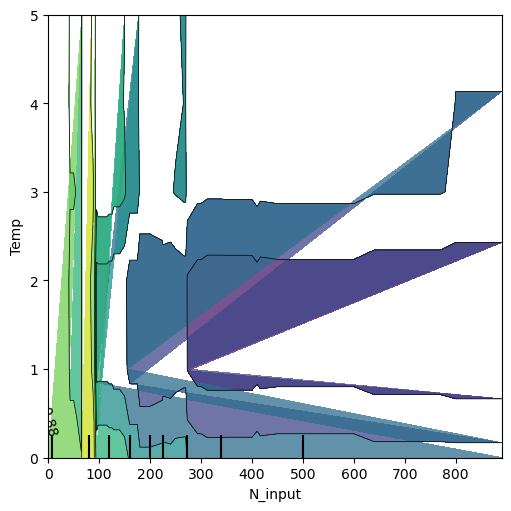

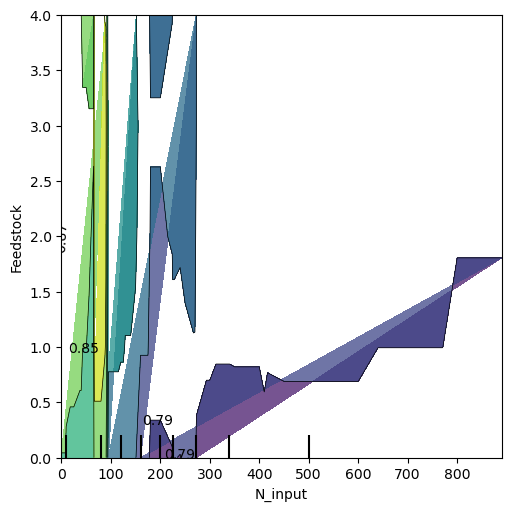

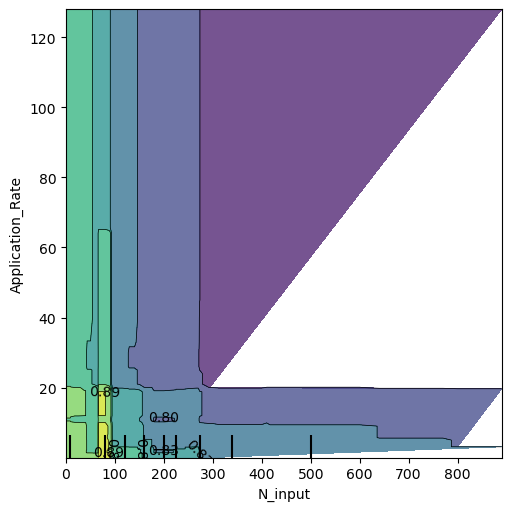

In [93]:
from itertools import product

common_params = {
#     "subsample": 50,
#     "n_jobs": 2,
    "grid_resolution": 400,
    "random_state": 0,
}

features_1D = X.columns.to_list()
features_1D.remove('Region')  
features_2D = list(product(features_1D, repeat=2))

n = 1
start = 12 * n 

for idx_ in range(len(features_2D[start:start+12])):
    idx = start + idx_
    features_info = {
        "features": features_2D[idx:idx+1],
        "kind": "average",
    }

    nrows = 1
    ncols = 1

    _, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5, 5), constrained_layout=True)

    display = PartialDependenceDisplay.from_estimator(
        best_model,
        X,
        **features_info,
        ax=ax,
        **common_params,
    )

    feature_i, feature_j = features_2D[idx]

    if feature_i in cat_features:
        xmin = 0
        xmax = max(list(X[feature_i].unique()))
    else:
        xmin = X[feature_i].min()
        xmax = X[feature_i].max()

    if feature_j in cat_features:
        ymin = 0
        ymax = max(list(X[feature_j].unique()))
    else:
        ymin = X[feature_j].min()
        ymax = X[feature_j].max()

    i, j = 0, 0
    display.axes_[i][j].set_xlim(xmin, xmax)
    display.axes_[i][j].set_ylim(ymin, ymax)

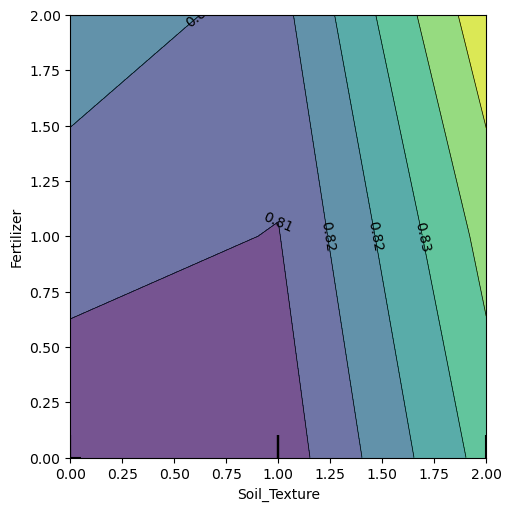

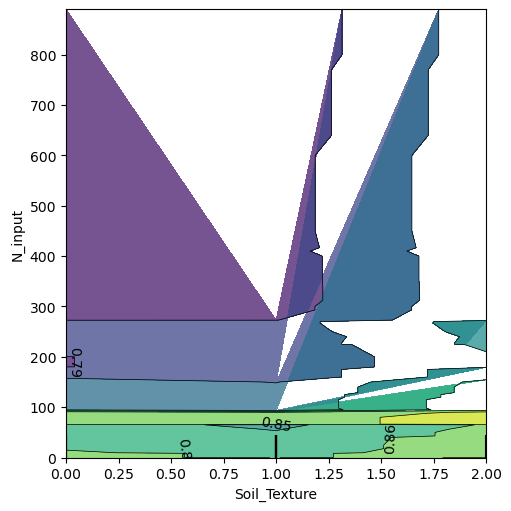

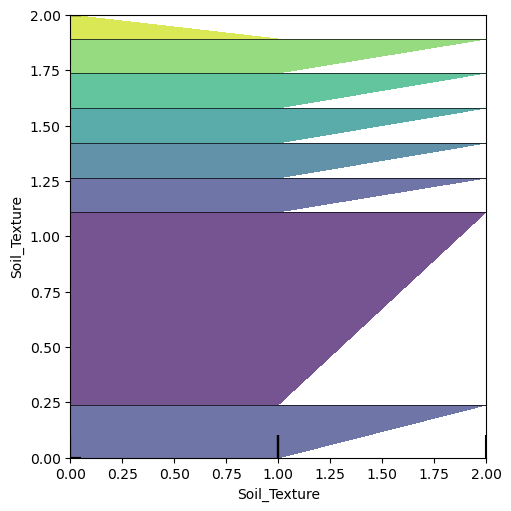

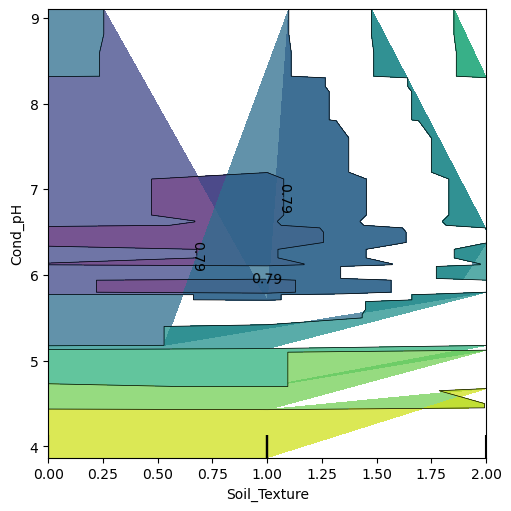

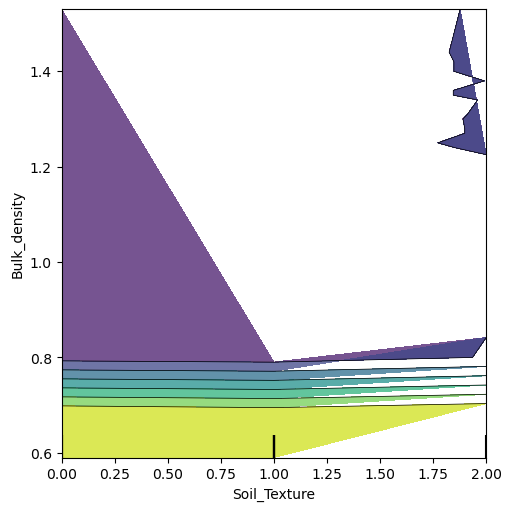

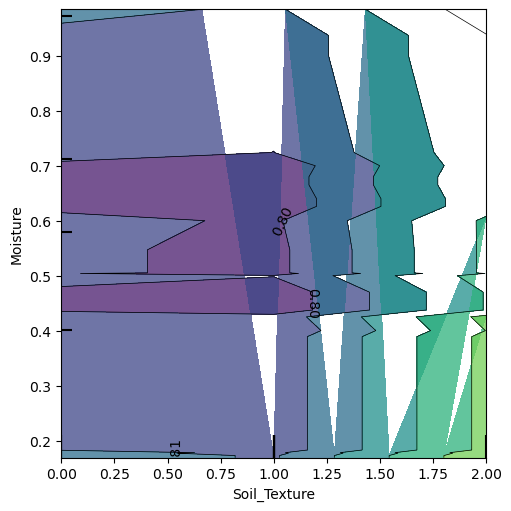

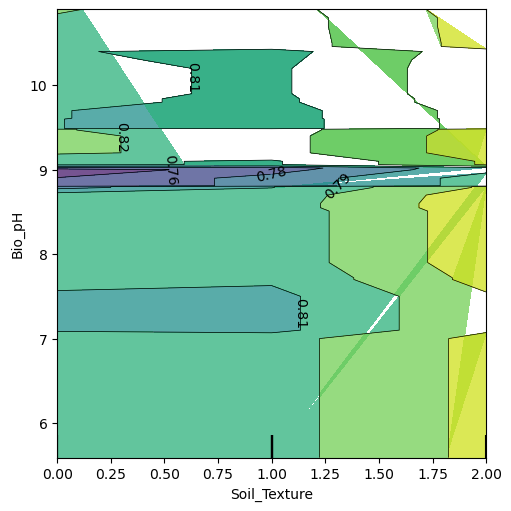

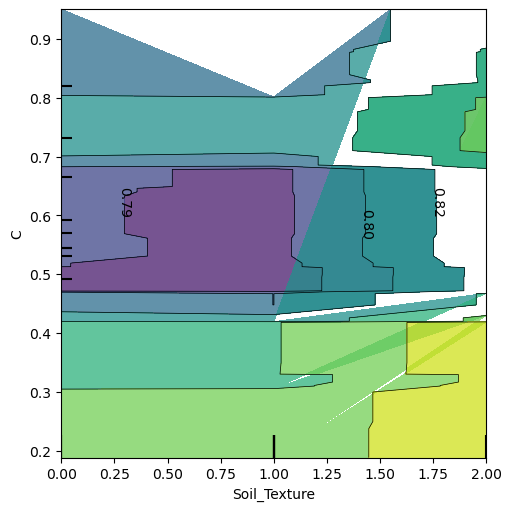

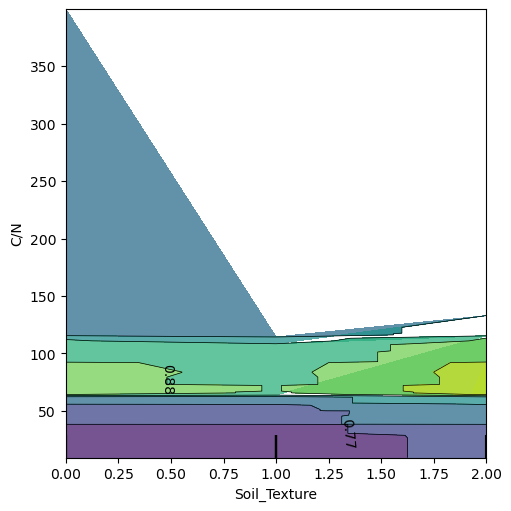

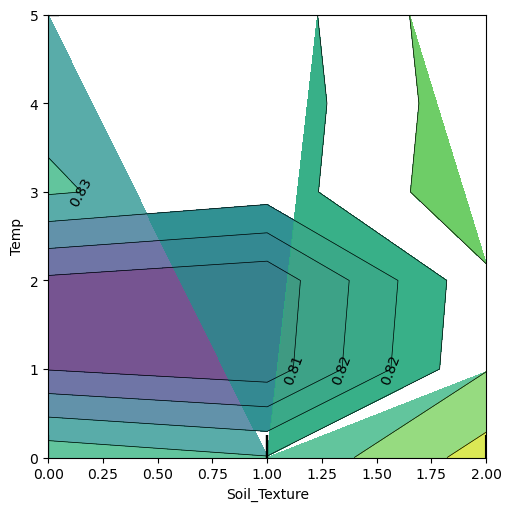

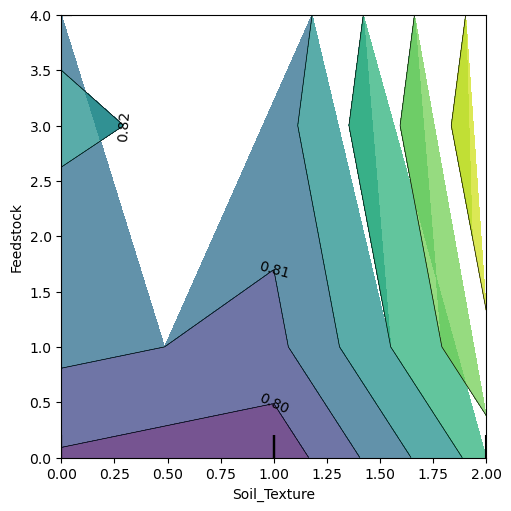

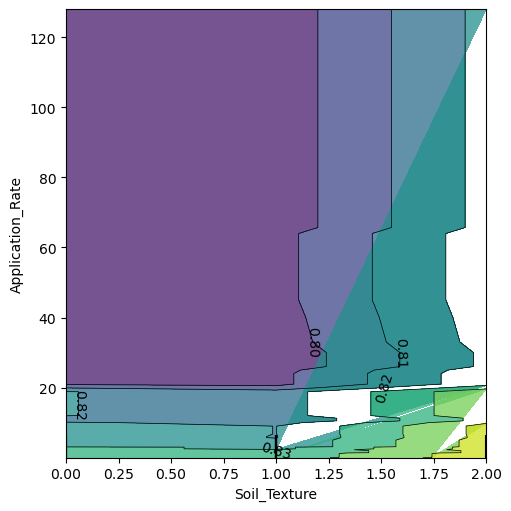

In [94]:
from itertools import product

common_params = {
#     "subsample": 50,
#     "n_jobs": 2,
    "grid_resolution": 400,
    "random_state": 0,
}

features_1D = X.columns.to_list()
features_1D.remove('Region')  
features_2D = list(product(features_1D, repeat=2))

n = 2
start = 12 * n 

for idx_ in range(len(features_2D[start:start+12])):
    idx = start + idx_
    features_info = {
        "features": features_2D[idx:idx+1],
        "kind": "average",
    }

    nrows = 1
    ncols = 1

    _, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5, 5), constrained_layout=True)

    display = PartialDependenceDisplay.from_estimator(
        best_model,
        X,
        **features_info,
        ax=ax,
        **common_params,
    )

    feature_i, feature_j = features_2D[idx]

    if feature_i in cat_features:
        xmin = 0
        xmax = max(list(X[feature_i].unique()))
    else:
        xmin = X[feature_i].min()
        xmax = X[feature_i].max()

    if feature_j in cat_features:
        ymin = 0
        ymax = max(list(X[feature_j].unique()))
    else:
        ymin = X[feature_j].min()
        ymax = X[feature_j].max()

    i, j = 0, 0
    display.axes_[i][j].set_xlim(xmin, xmax)
    display.axes_[i][j].set_ylim(ymin, ymax)

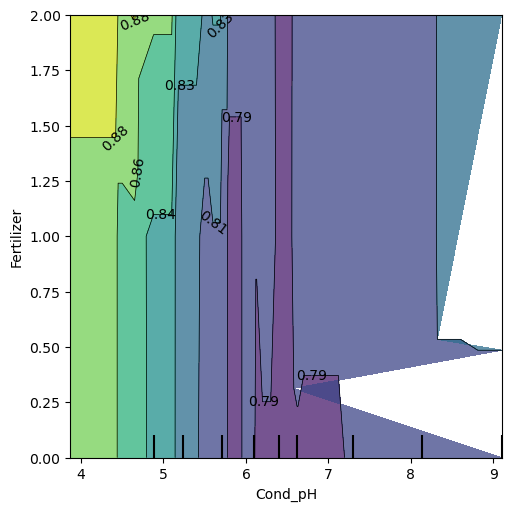

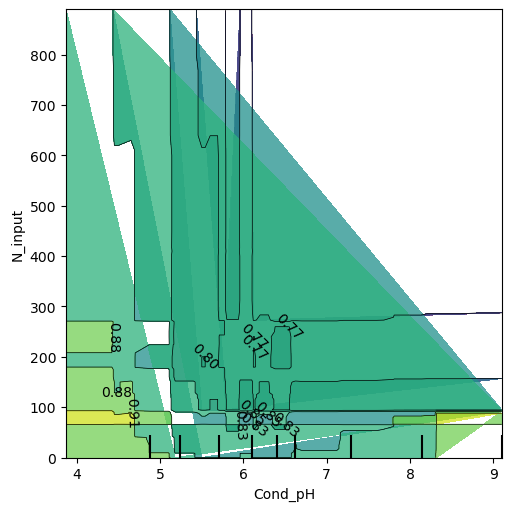

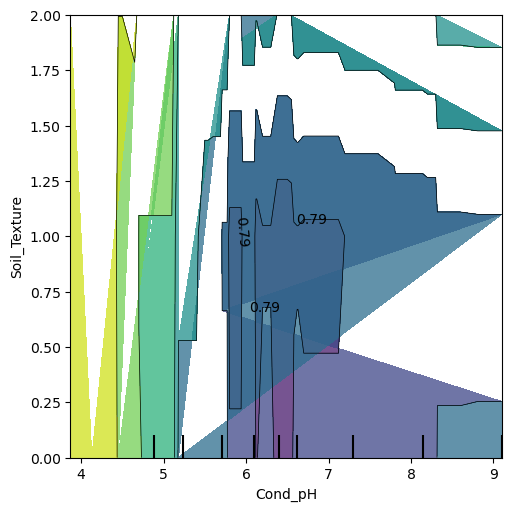

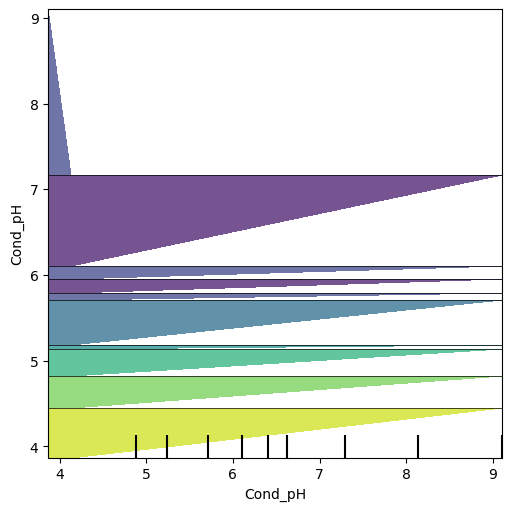

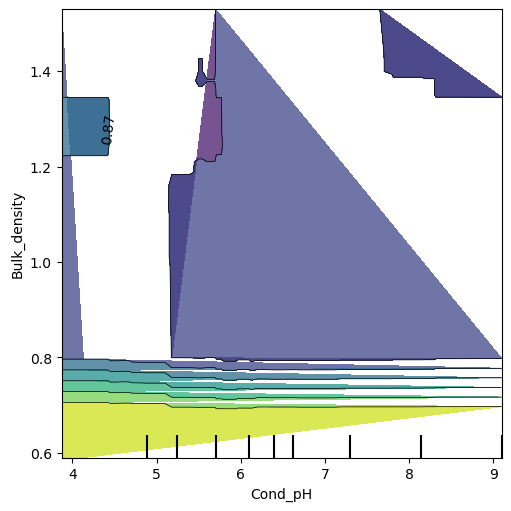

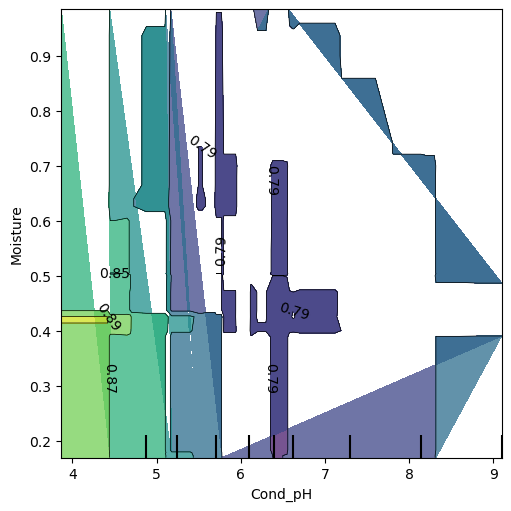

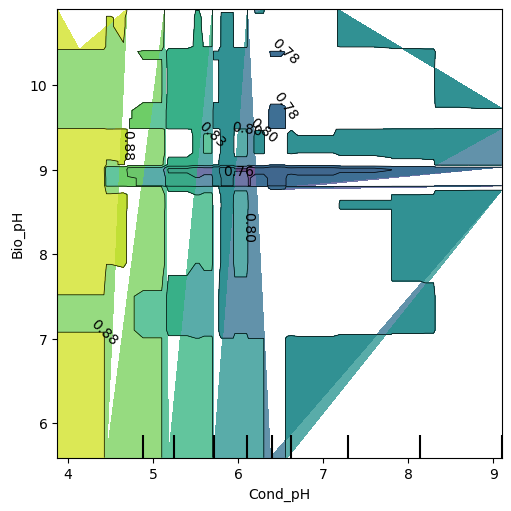

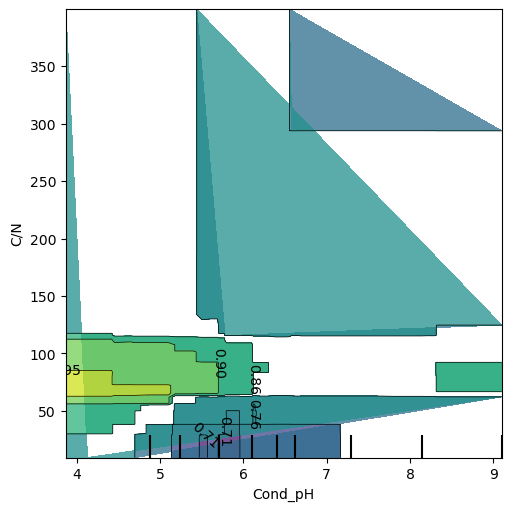

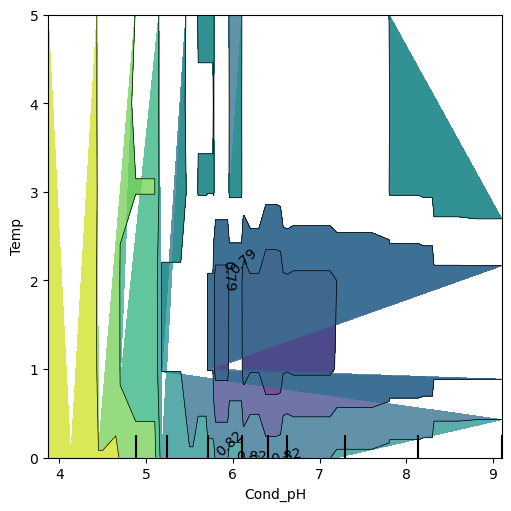

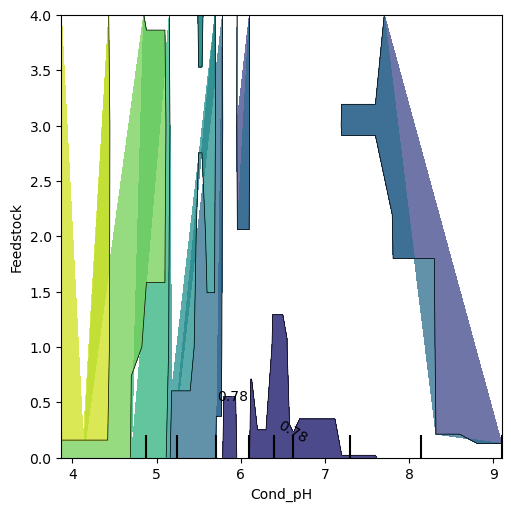

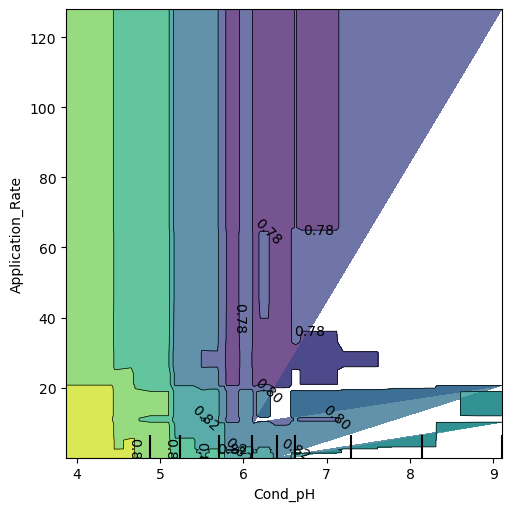

In [137]:
from itertools import product

common_params = {
#     "subsample": 50,
#     "n_jobs": 2,
    "grid_resolution": 400,
    "random_state": 0,
}

features_1D = X.columns.to_list()
features_1D.remove('Region')  
features_2D = list(product(features_1D, repeat=2))

n = 3
start = 12 * n 

for idx_ in range(len(features_2D[start:start+12])):
    idx = start + idx_
    features_info = {
        "features": features_2D[idx:idx+1],
        "kind": "average",
    }

    nrows = 1
    ncols = 1

    feature_i, feature_j = features_2D[idx]
    if (feature_i, feature_j) == ('Cond_pH', 'C') or (feature_i, feature_j) == ('C', 'Cond_pH'):
        continue

    _, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5, 5), constrained_layout=True)

    display = PartialDependenceDisplay.from_estimator(
        best_model,
        X,
        **features_info,
        ax=ax,
        **common_params,
    )

    if feature_i in cat_features:
        xmin = 0
        xmax = max(list(X[feature_i].unique()))
    else:
        xmin = X[feature_i].min()
        xmax = X[feature_i].max()

    if feature_j in cat_features:
        ymin = 0
        ymax = max(list(X[feature_j].unique()))
    else:
        ymin = X[feature_j].min()
        ymax = X[feature_j].max()

    i, j = 0, 0
    display.axes_[i][j].set_xlim(xmin, xmax)
    display.axes_[i][j].set_ylim(ymin, ymax)

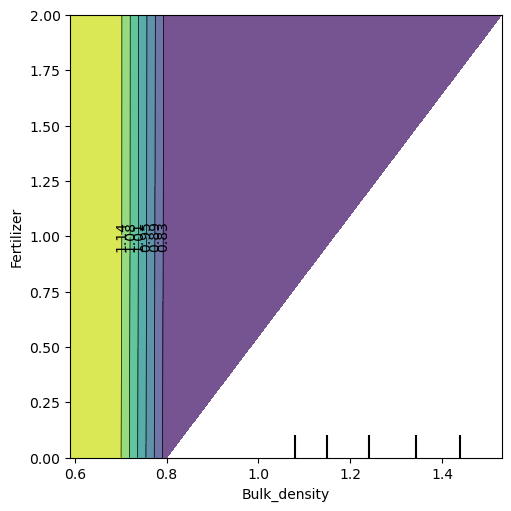

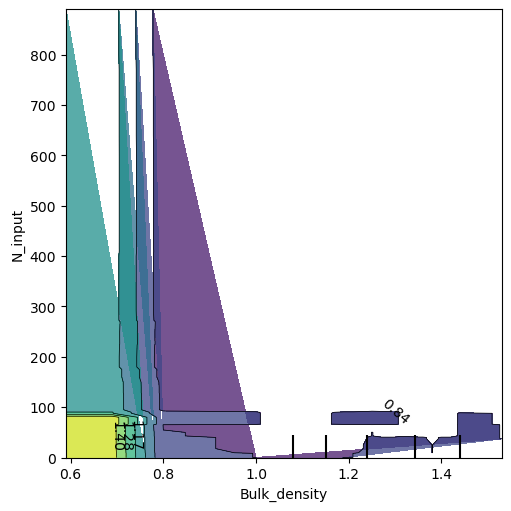

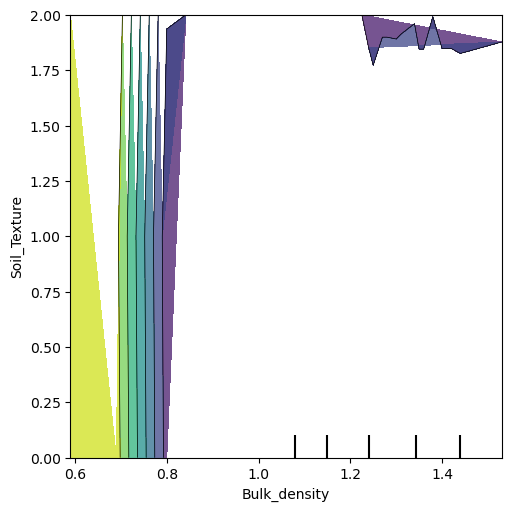

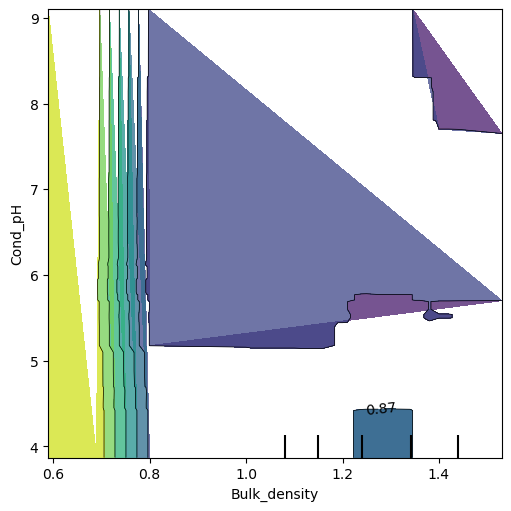

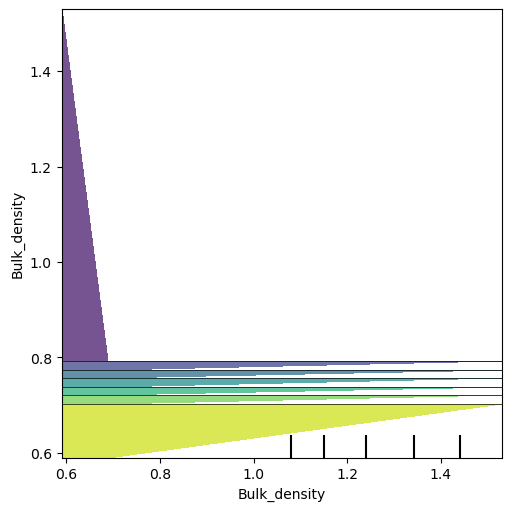

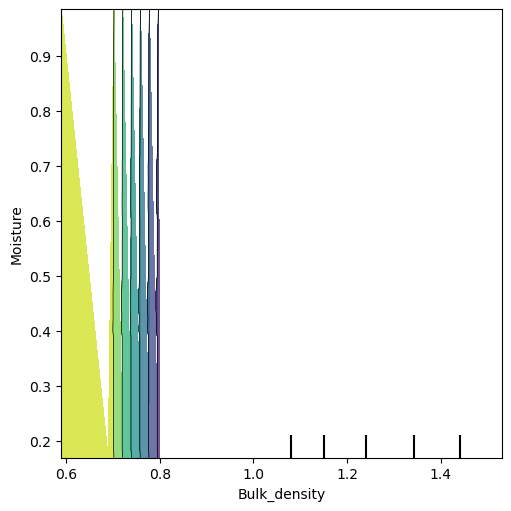

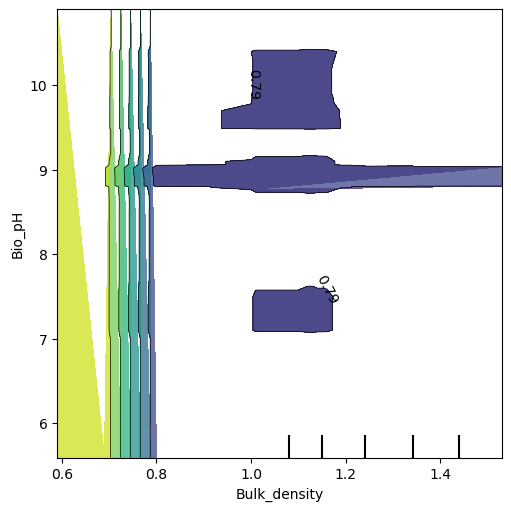

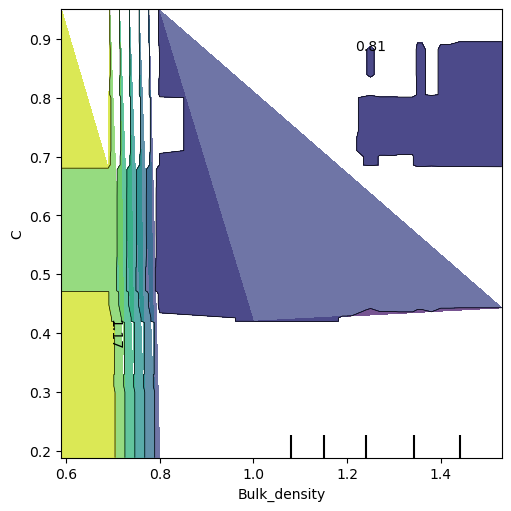

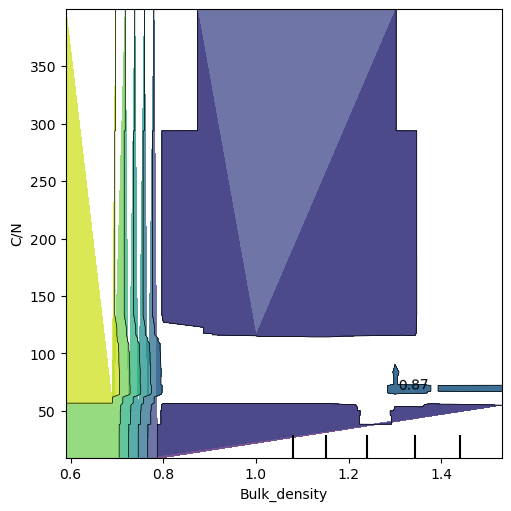

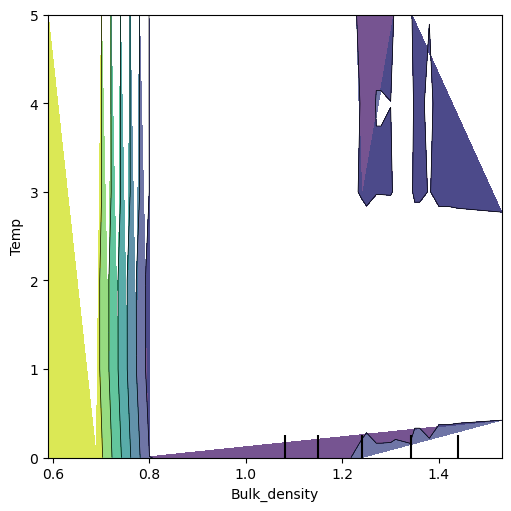

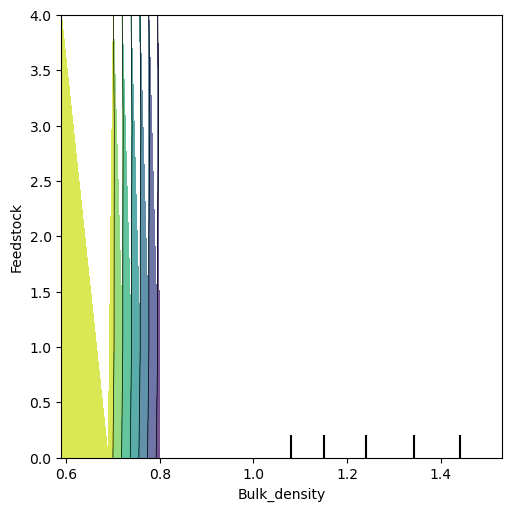

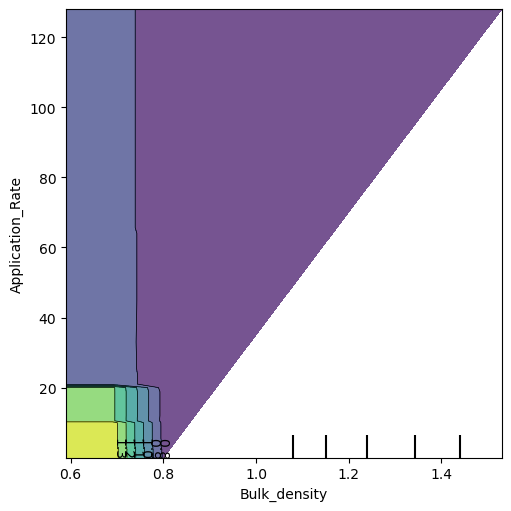

In [96]:
from itertools import product

common_params = {
#     "subsample": 50,
#     "n_jobs": 2,
    "grid_resolution": 400,
    "random_state": 0,
}

features_1D = X.columns.to_list()
features_1D.remove('Region')  
features_2D = list(product(features_1D, repeat=2))

n = 4
start = 12 * n 

for idx_ in range(len(features_2D[start:start+12])):
    idx = start + idx_
    features_info = {
        "features": features_2D[idx:idx+1],
        "kind": "average",
    }

    nrows = 1
    ncols = 1

    _, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5, 5), constrained_layout=True)

    display = PartialDependenceDisplay.from_estimator(
        best_model,
        X,
        **features_info,
        ax=ax,
        **common_params,
    )

    feature_i, feature_j = features_2D[idx]

    if feature_i in cat_features:
        xmin = 0
        xmax = max(list(X[feature_i].unique()))
    else:
        xmin = X[feature_i].min()
        xmax = X[feature_i].max()

    if feature_j in cat_features:
        ymin = 0
        ymax = max(list(X[feature_j].unique()))
    else:
        ymin = X[feature_j].min()
        ymax = X[feature_j].max()

    i, j = 0, 0
    display.axes_[i][j].set_xlim(xmin, xmax)
    display.axes_[i][j].set_ylim(ymin, ymax)

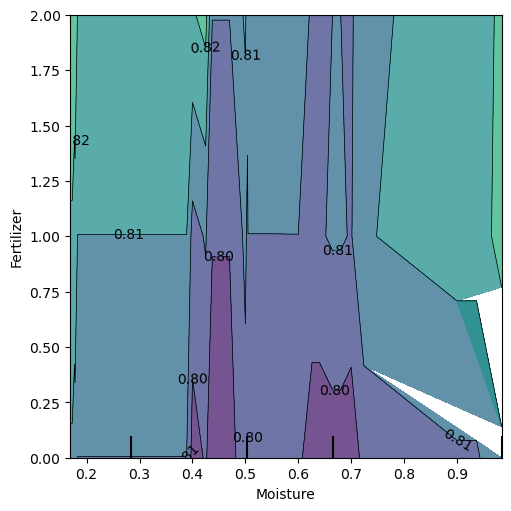

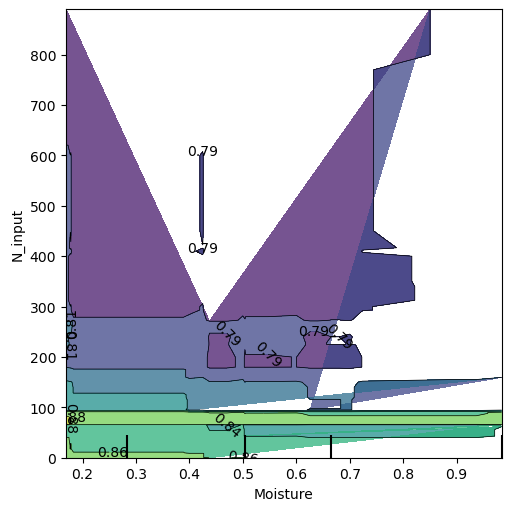

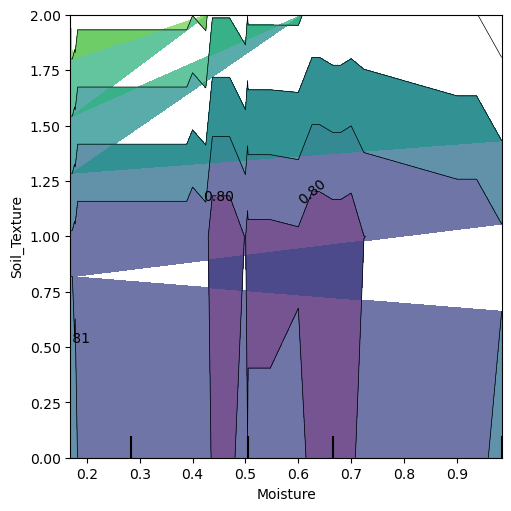

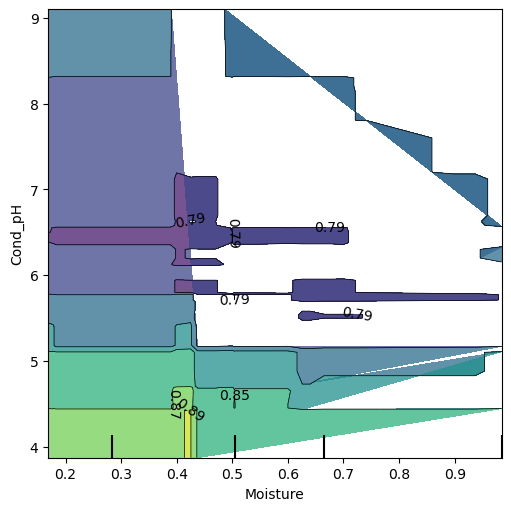

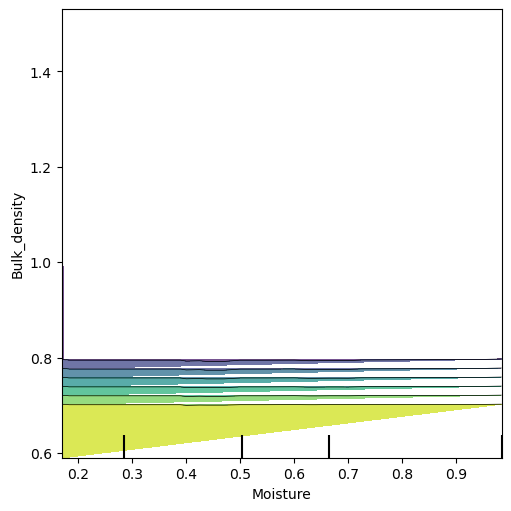

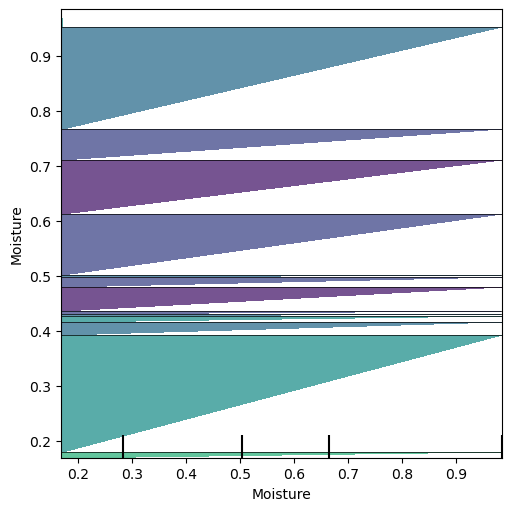

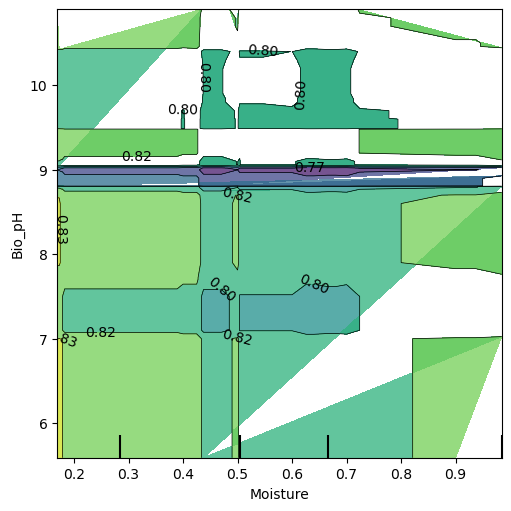

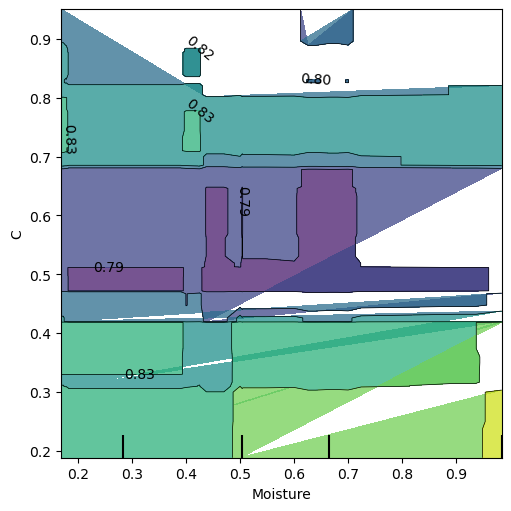

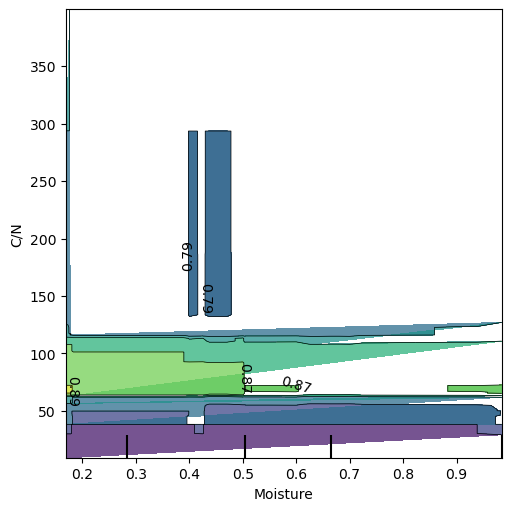

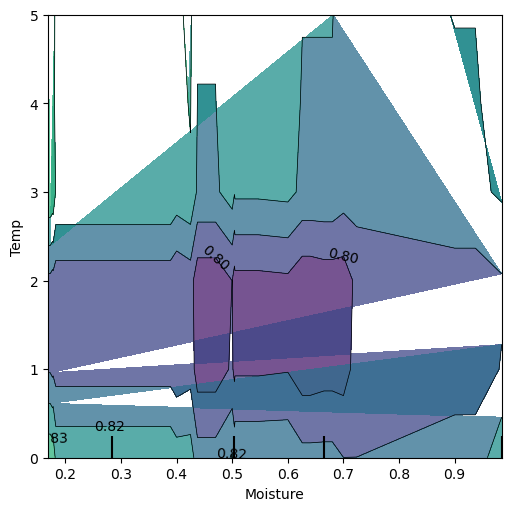

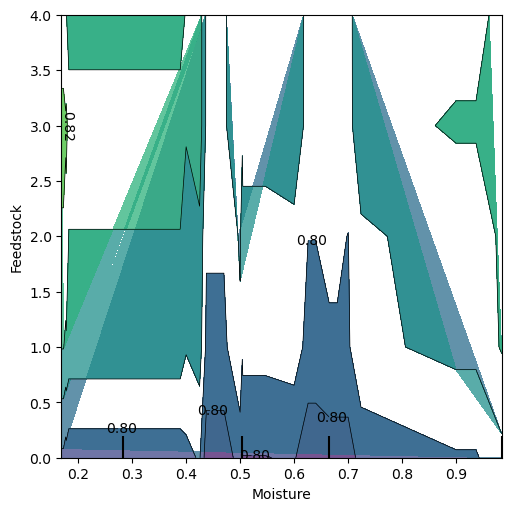

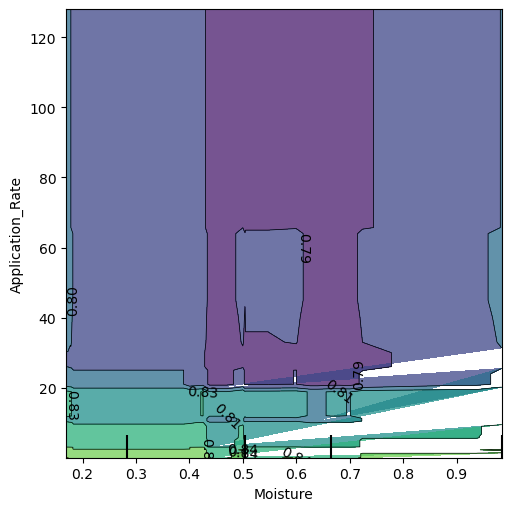

In [111]:
from itertools import product

common_params = {
#     "subsample": 50,
#     "n_jobs": 2,
    "grid_resolution": 400,
    "random_state": 0,
}

features_1D = X.columns.to_list()
features_1D.remove('Region')  
features_2D = list(product(features_1D, repeat=2))

n = 5
start = 12 * n 

for idx_ in range(len(features_2D[start:start+12])):
    idx = start + idx_
    features_info = {
        "features": features_2D[idx:idx+1],
        "kind": "average",
    }

    nrows = 1
    ncols = 1

    _, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5, 5), constrained_layout=True)

    display = PartialDependenceDisplay.from_estimator(
        best_model,
        X,
        **features_info,
        ax=ax,
        **common_params,
    )

    feature_i, feature_j = features_2D[idx]

    if feature_i in cat_features:
        xmin = 0
        xmax = max(list(X[feature_i].unique()))
    else:
        xmin = X[feature_i].min()
        xmax = X[feature_i].max()

    if feature_j in cat_features:
        ymin = 0
        ymax = max(list(X[feature_j].unique()))
    else:
        ymin = X[feature_j].min()
        ymax = X[feature_j].max()

    i, j = 0, 0
    display.axes_[i][j].set_xlim(xmin, xmax)
    display.axes_[i][j].set_ylim(ymin, ymax)

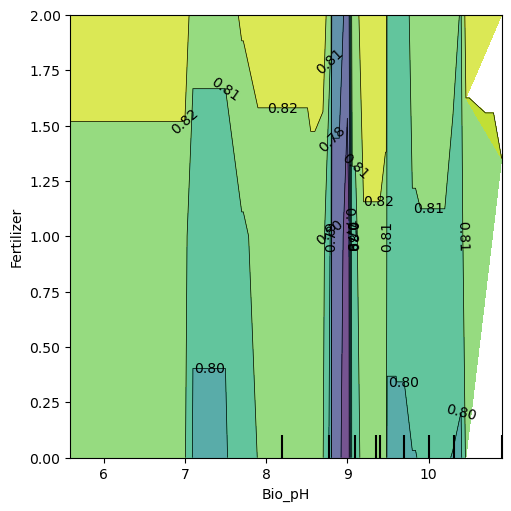

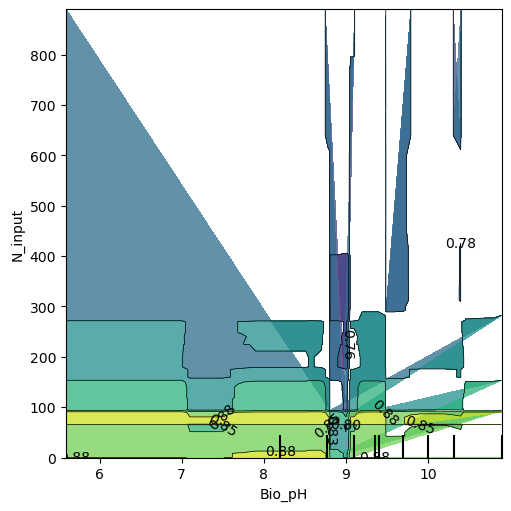

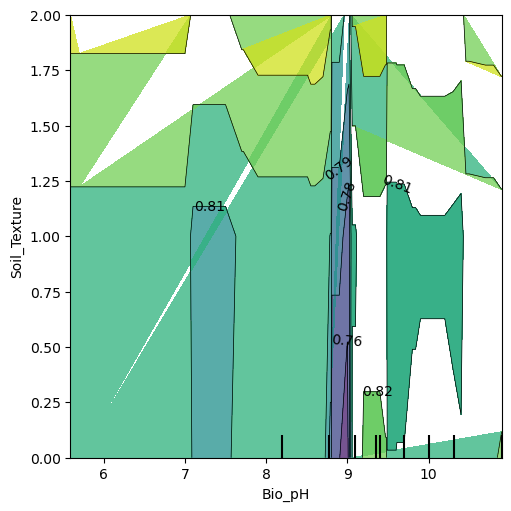

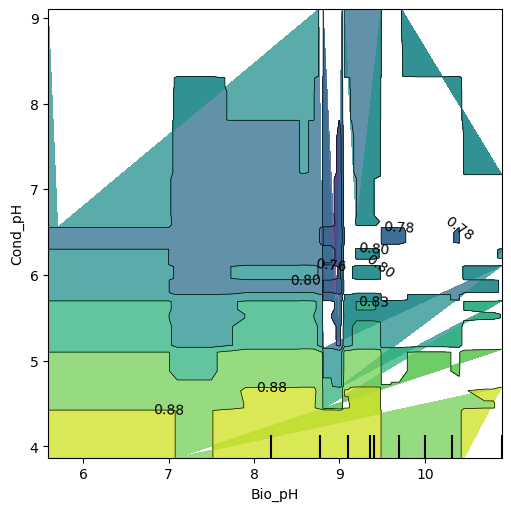

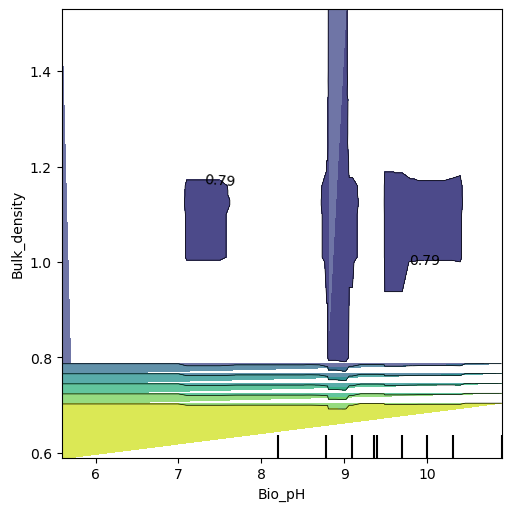

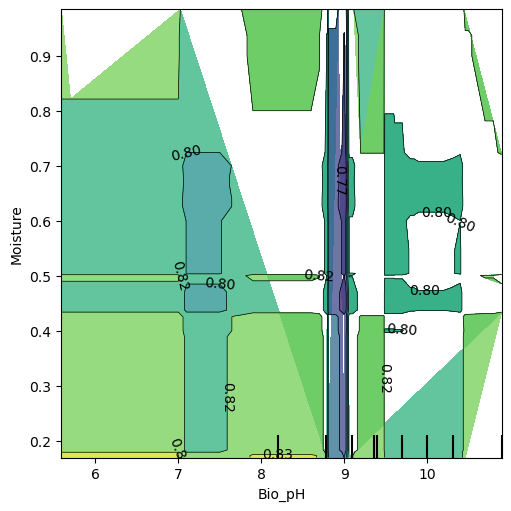

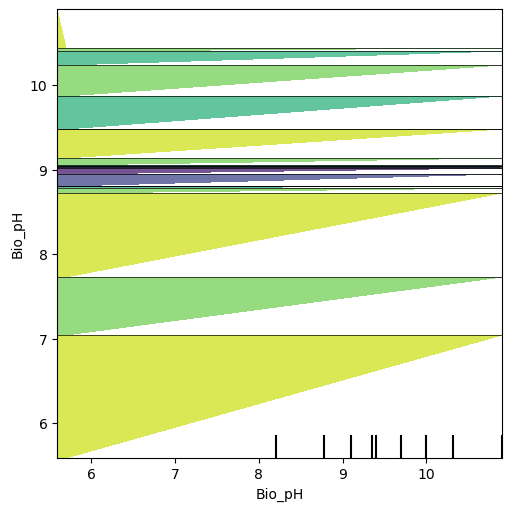

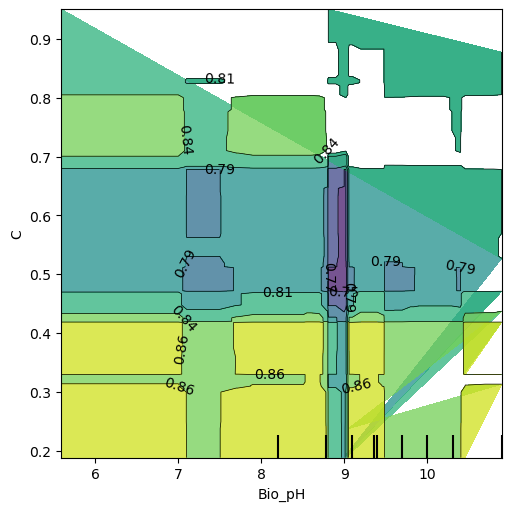

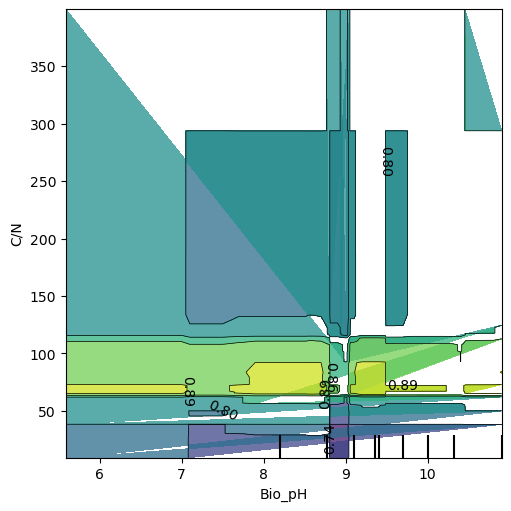

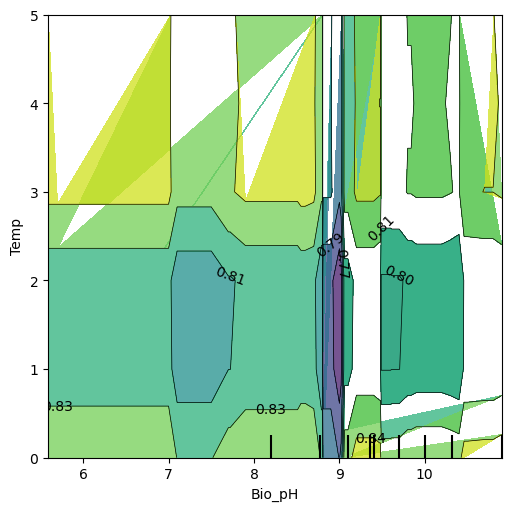

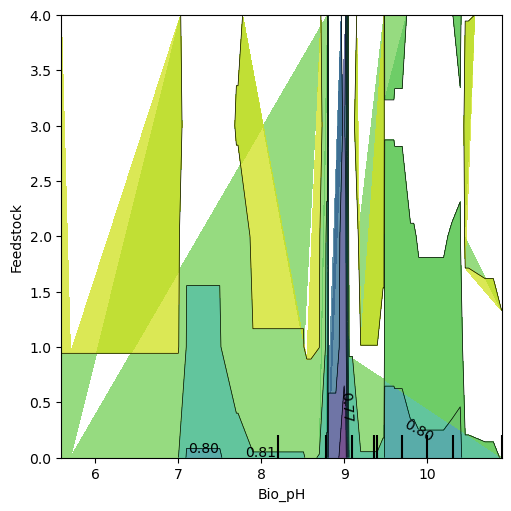

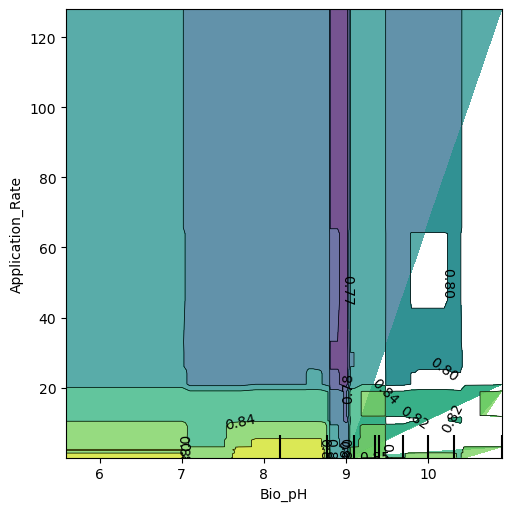

In [112]:
from itertools import product

common_params = {
#     "subsample": 50,
#     "n_jobs": 2,
    "grid_resolution": 400,
    "random_state": 0,
}

features_1D = X.columns.to_list()
features_1D.remove('Region')  
features_2D = list(product(features_1D, repeat=2))

n = 6
start = 12 * n 

for idx_ in range(len(features_2D[start:start+12])):
    idx = start + idx_
    features_info = {
        "features": features_2D[idx:idx+1],
        "kind": "average",
    }

    nrows = 1
    ncols = 1

    _, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5, 5), constrained_layout=True)

    display = PartialDependenceDisplay.from_estimator(
        best_model,
        X,
        **features_info,
        ax=ax,
        **common_params,
    )

    feature_i, feature_j = features_2D[idx]

    if feature_i in cat_features:
        xmin = 0
        xmax = max(list(X[feature_i].unique()))
    else:
        xmin = X[feature_i].min()
        xmax = X[feature_i].max()

    if feature_j in cat_features:
        ymin = 0
        ymax = max(list(X[feature_j].unique()))
    else:
        ymin = X[feature_j].min()
        ymax = X[feature_j].max()

    i, j = 0, 0
    display.axes_[i][j].set_xlim(xmin, xmax)
    display.axes_[i][j].set_ylim(ymin, ymax)

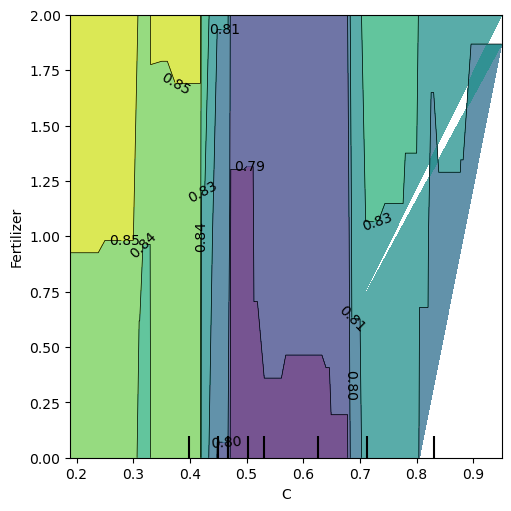

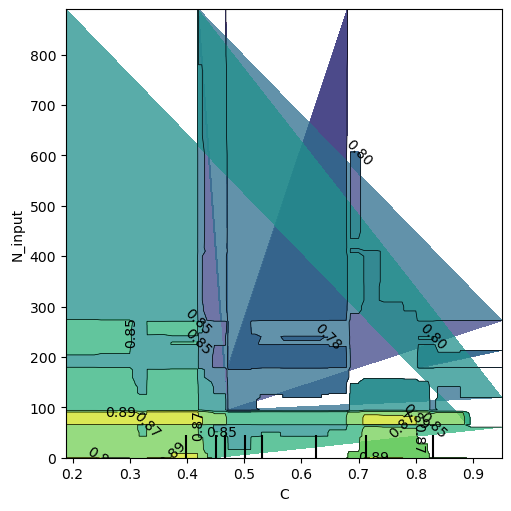

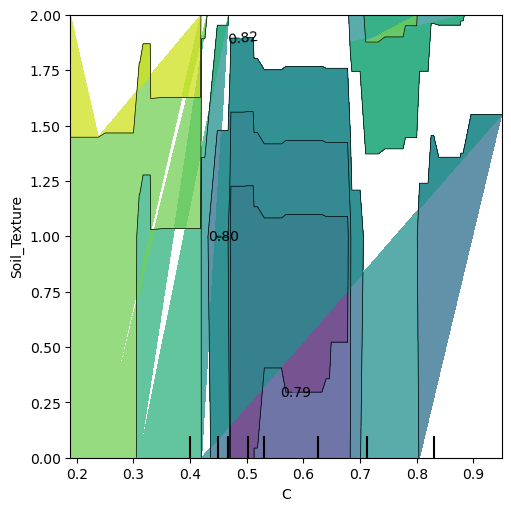

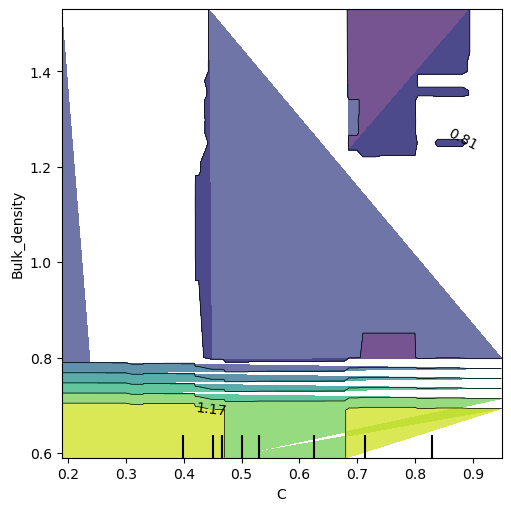

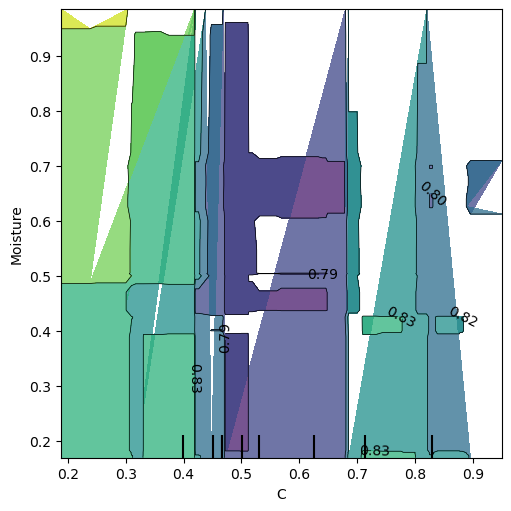

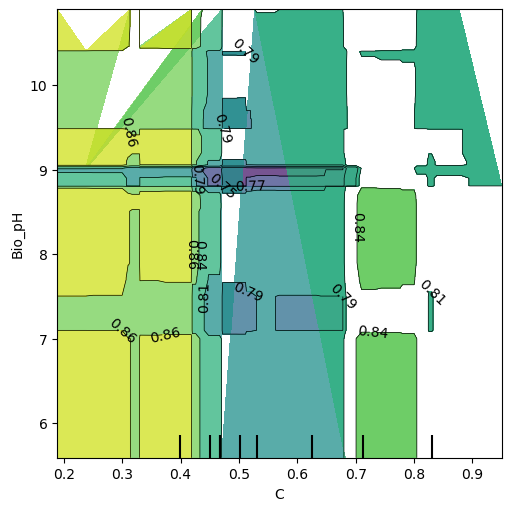

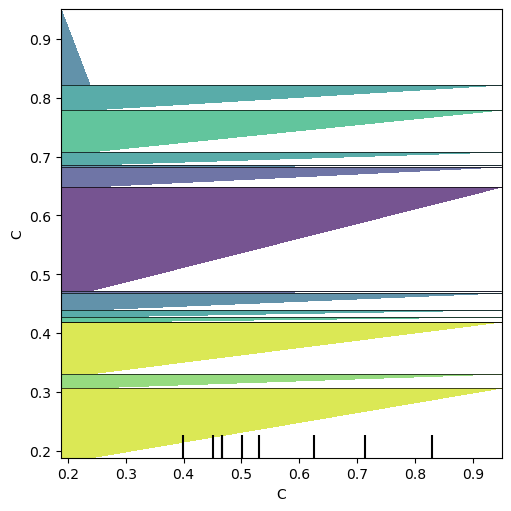

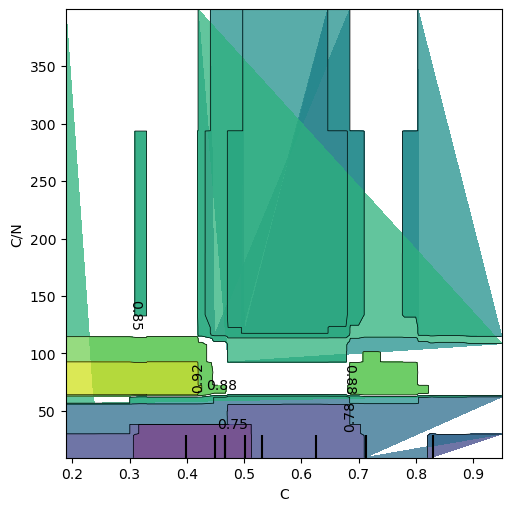

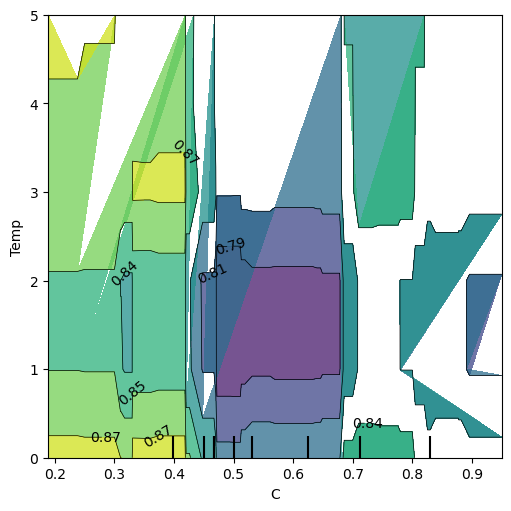

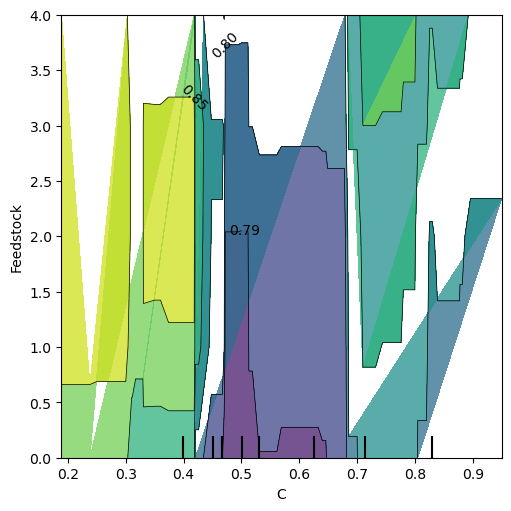

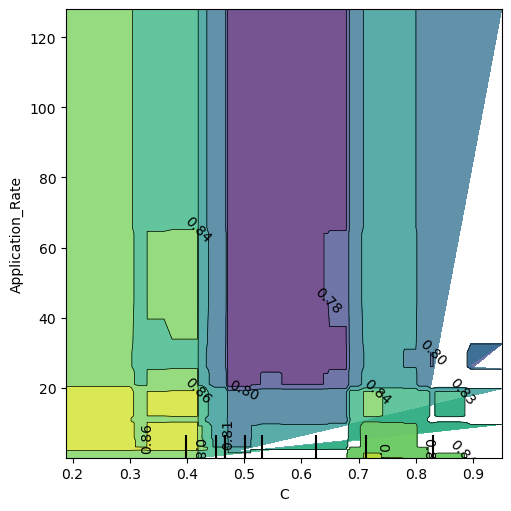

In [138]:
from itertools import product

common_params = {
#     "subsample": 50,
#     "n_jobs": 2,
    "grid_resolution": 400,
    "random_state": 0,
}

features_1D = X.columns.to_list()
features_1D.remove('Region')  
features_2D = list(product(features_1D, repeat=2))

n = 7
start = 12 * n 

for idx_ in range(len(features_2D[start:start+12])):
    idx = start + idx_
    features_info = {
        "features": features_2D[idx:idx+1],
        "kind": "average",
    }

    nrows = 1
    ncols = 1

    feature_i, feature_j = features_2D[idx]
    if (feature_i, feature_j) == ('Cond_pH', 'C') or (feature_i, feature_j) == ('C', 'Cond_pH'):
        continue

    _, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5, 5), constrained_layout=True)

    display = PartialDependenceDisplay.from_estimator(
        best_model,
        X,
        **features_info,
        ax=ax,
        **common_params,
    )

    if feature_i in cat_features:
        xmin = 0
        xmax = max(list(X[feature_i].unique()))
    else:
        xmin = X[feature_i].min()
        xmax = X[feature_i].max()

    if feature_j in cat_features:
        ymin = 0
        ymax = max(list(X[feature_j].unique()))
    else:
        ymin = X[feature_j].min()
        ymax = X[feature_j].max()

    i, j = 0, 0
    display.axes_[i][j].set_xlim(xmin, xmax)
    display.axes_[i][j].set_ylim(ymin, ymax)

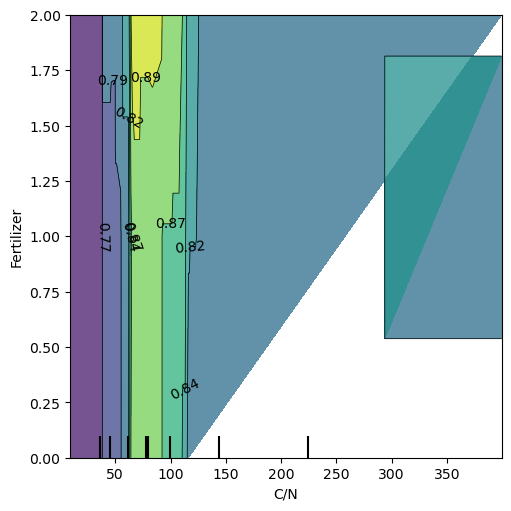

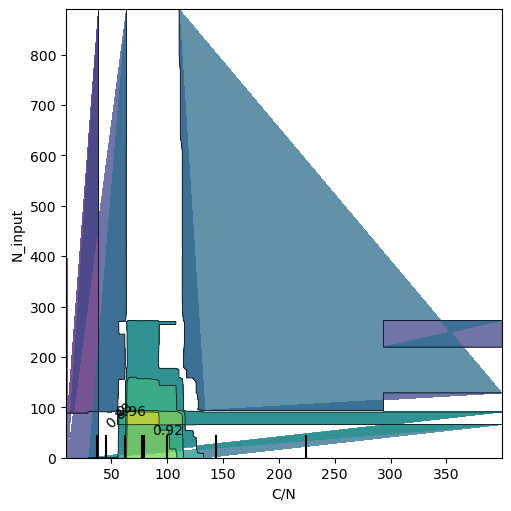

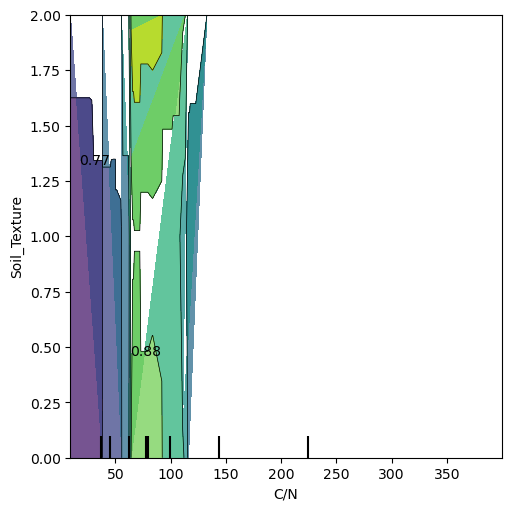

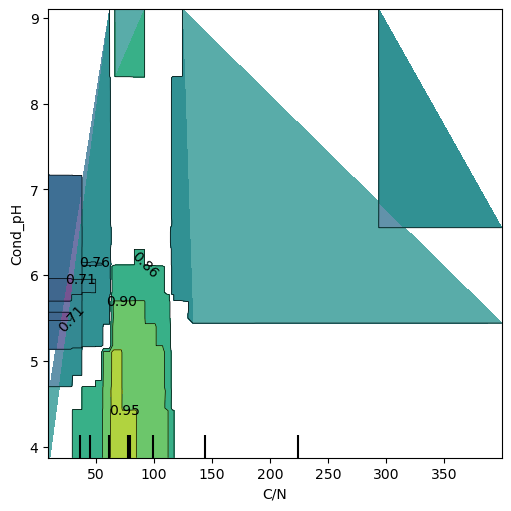

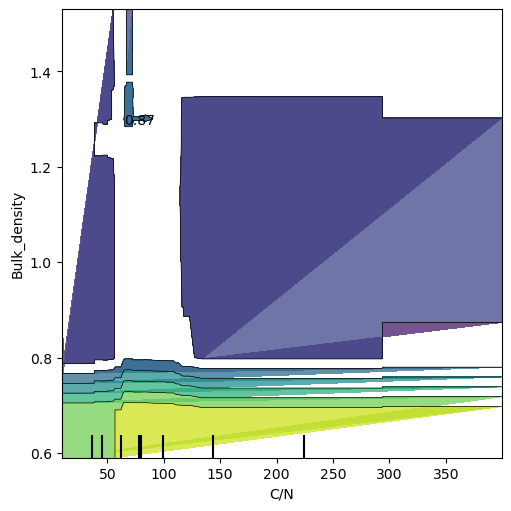

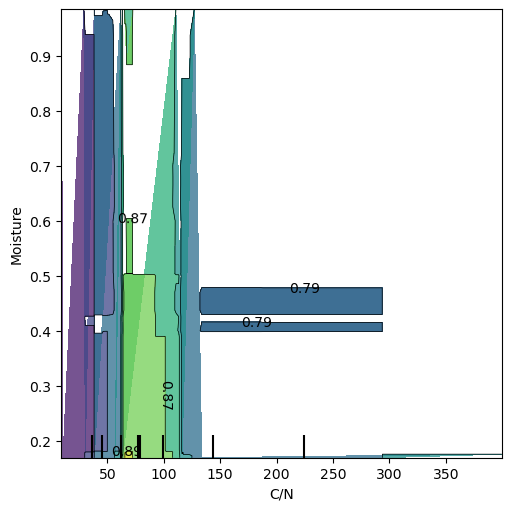

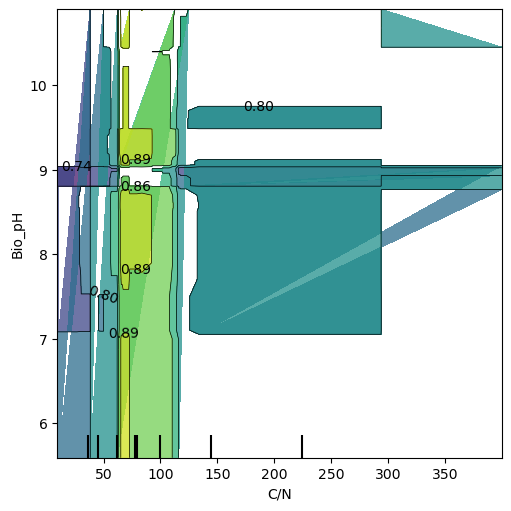

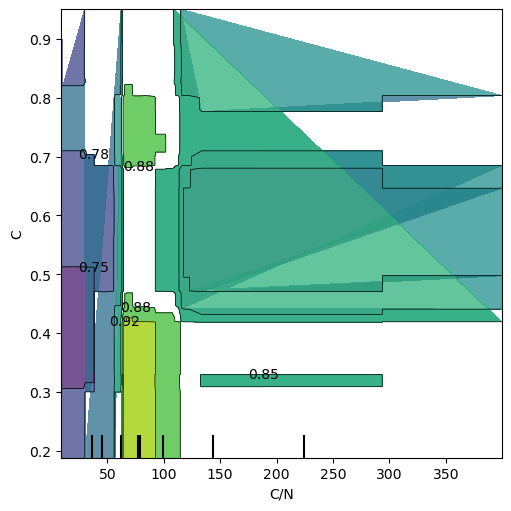

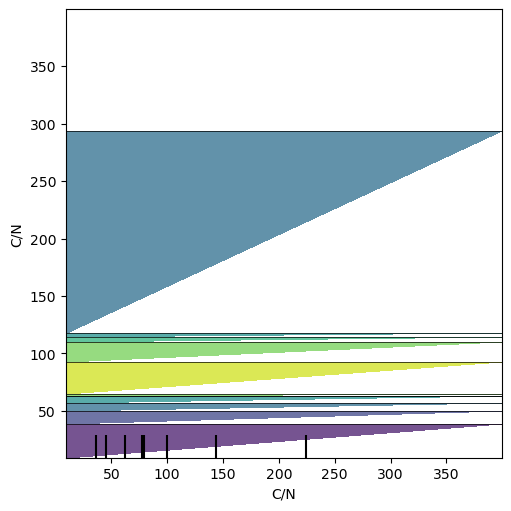

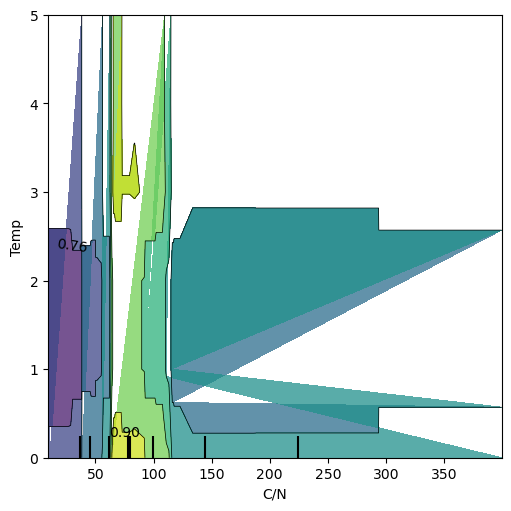

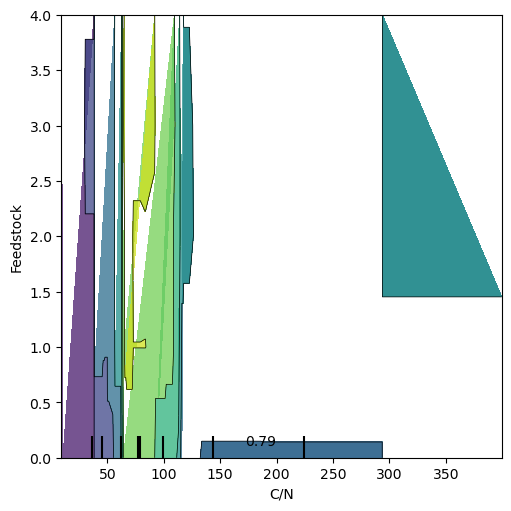

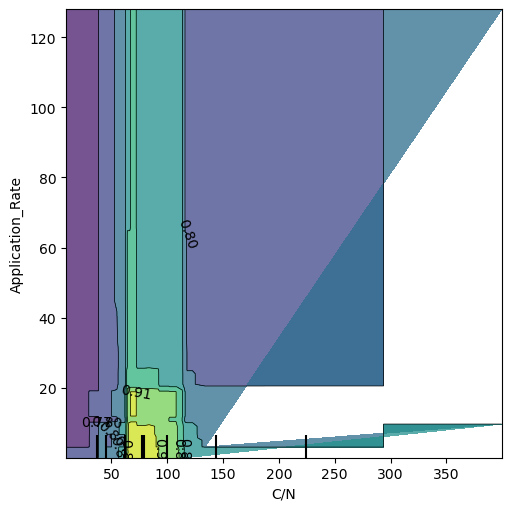

In [114]:
from itertools import product

common_params = {
#     "subsample": 50,
#     "n_jobs": 2,
    "grid_resolution": 400,
    "random_state": 0,
}

features_1D = X.columns.to_list()
features_1D.remove('Region')  
features_2D = list(product(features_1D, repeat=2))

n = 8
start = 12 * n 

for idx_ in range(len(features_2D[start:start+12])):
    idx = start + idx_
    features_info = {
        "features": features_2D[idx:idx+1],
        "kind": "average",
    }

    nrows = 1
    ncols = 1

    _, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5, 5), constrained_layout=True)

    display = PartialDependenceDisplay.from_estimator(
        best_model,
        X,
        **features_info,
        ax=ax,
        **common_params,
    )

    feature_i, feature_j = features_2D[idx]

    if feature_i in cat_features:
        xmin = 0
        xmax = max(list(X[feature_i].unique()))
    else:
        xmin = X[feature_i].min()
        xmax = X[feature_i].max()

    if feature_j in cat_features:
        ymin = 0
        ymax = max(list(X[feature_j].unique()))
    else:
        ymin = X[feature_j].min()
        ymax = X[feature_j].max()

    i, j = 0, 0
    display.axes_[i][j].set_xlim(xmin, xmax)
    display.axes_[i][j].set_ylim(ymin, ymax)

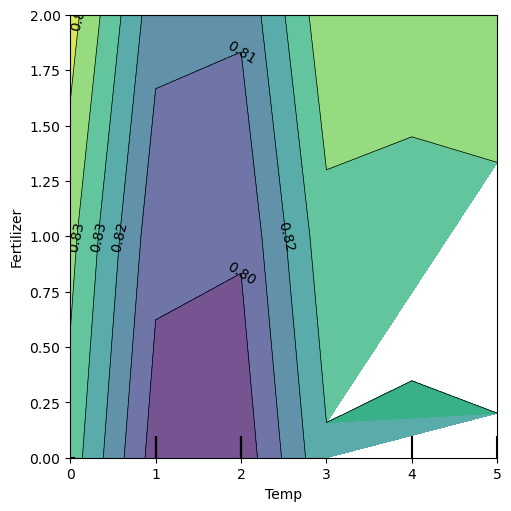

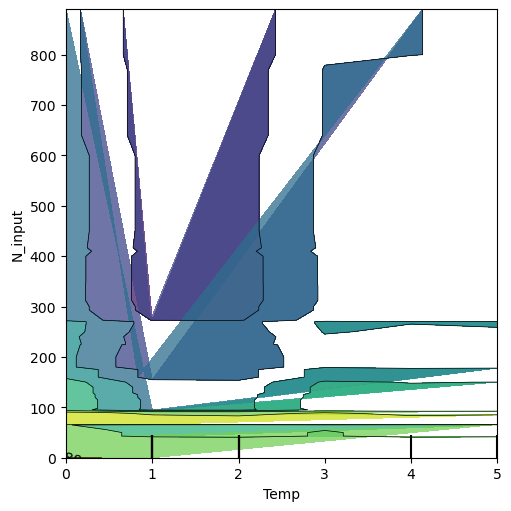

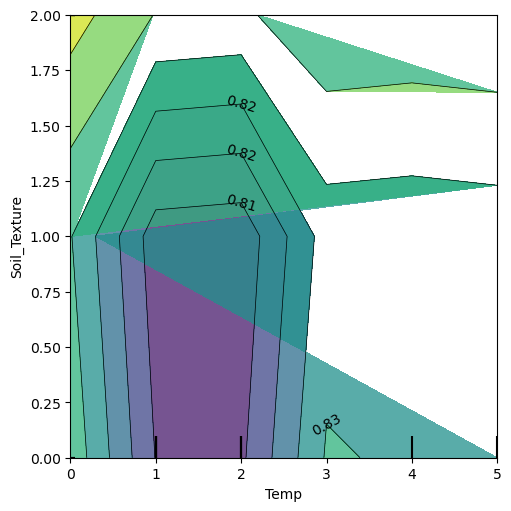

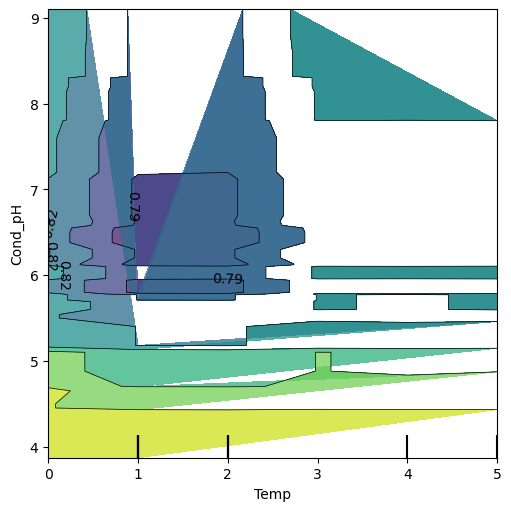

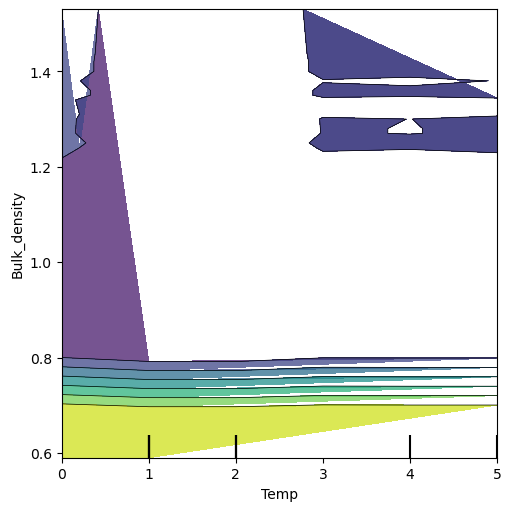

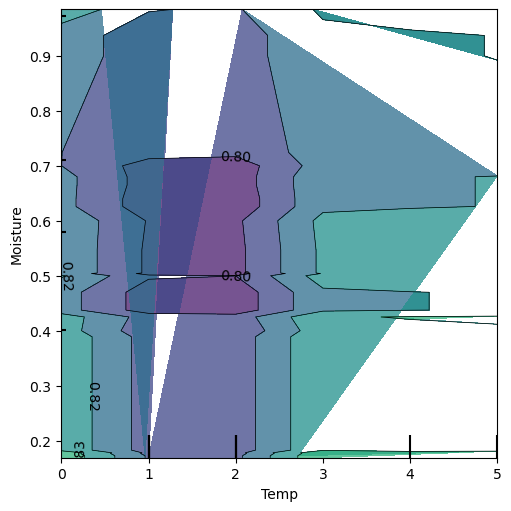

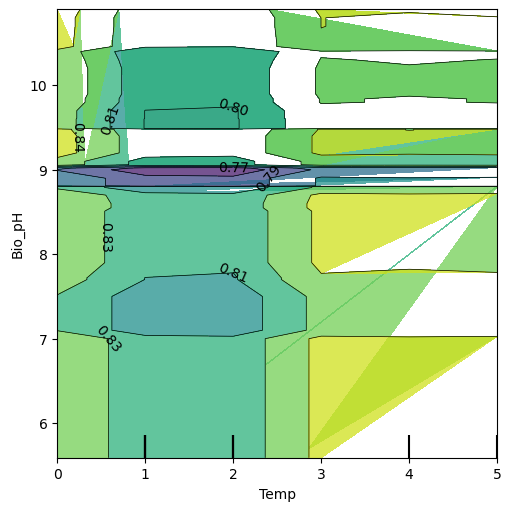

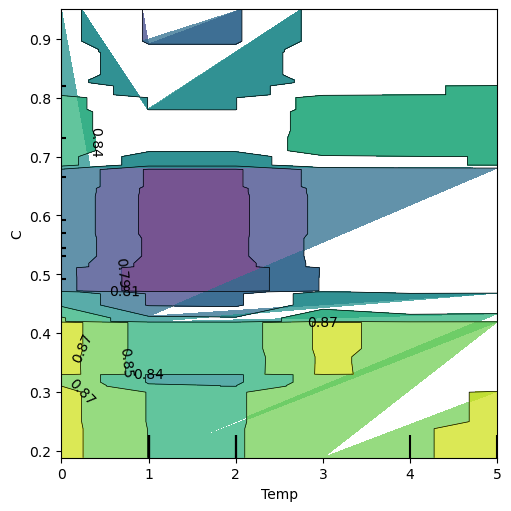

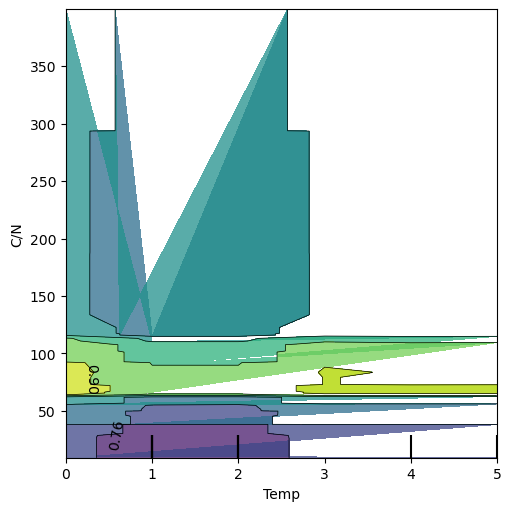

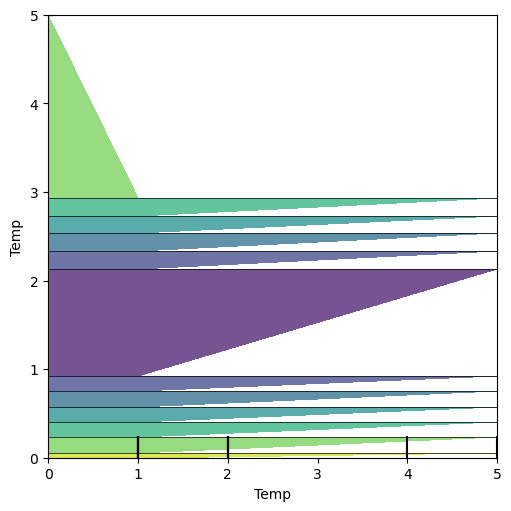

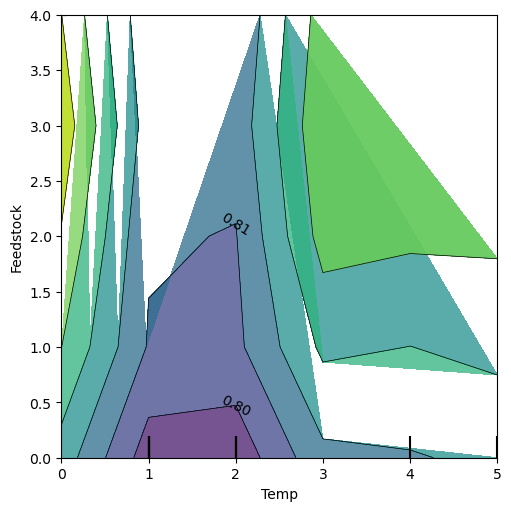

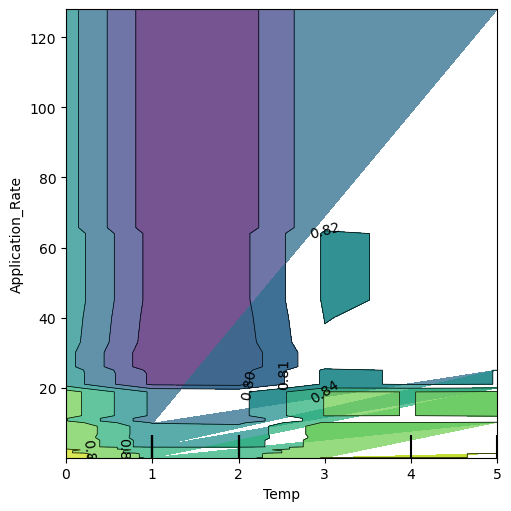

In [115]:
from itertools import product

common_params = {
#     "subsample": 50,
#     "n_jobs": 2,
    "grid_resolution": 400,
    "random_state": 0,
}

features_1D = X.columns.to_list()
features_1D.remove('Region')  
features_2D = list(product(features_1D, repeat=2))

n = 9
start = 12 * n 

for idx_ in range(len(features_2D[start:start+12])):
    idx = start + idx_
    features_info = {
        "features": features_2D[idx:idx+1],
        "kind": "average",
    }

    nrows = 1
    ncols = 1

    _, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5, 5), constrained_layout=True)

    display = PartialDependenceDisplay.from_estimator(
        best_model,
        X,
        **features_info,
        ax=ax,
        **common_params,
    )

    feature_i, feature_j = features_2D[idx]

    if feature_i in cat_features:
        xmin = 0
        xmax = max(list(X[feature_i].unique()))
    else:
        xmin = X[feature_i].min()
        xmax = X[feature_i].max()

    if feature_j in cat_features:
        ymin = 0
        ymax = max(list(X[feature_j].unique()))
    else:
        ymin = X[feature_j].min()
        ymax = X[feature_j].max()

    i, j = 0, 0
    display.axes_[i][j].set_xlim(xmin, xmax)
    display.axes_[i][j].set_ylim(ymin, ymax)

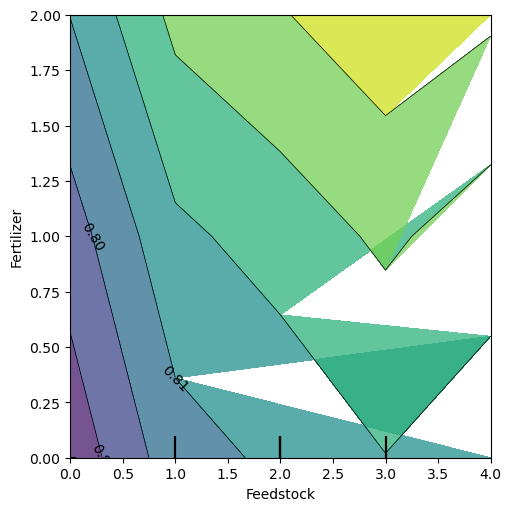

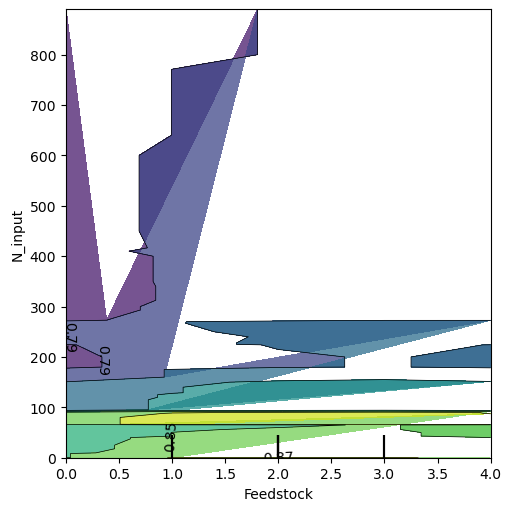

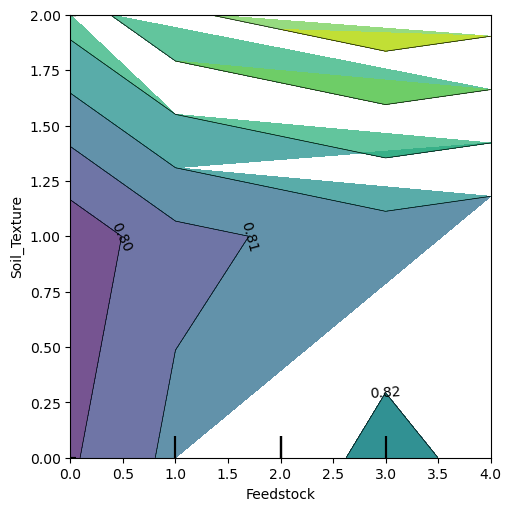

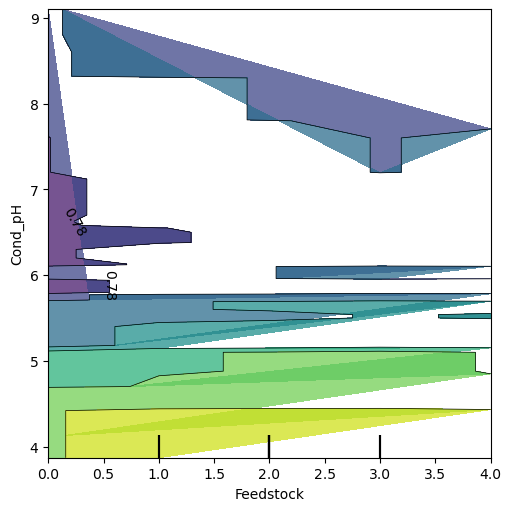

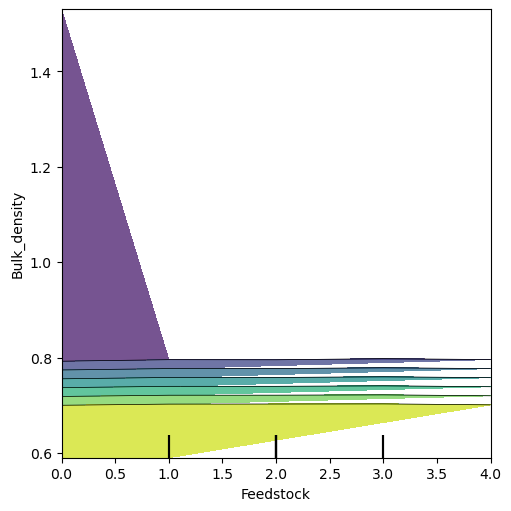

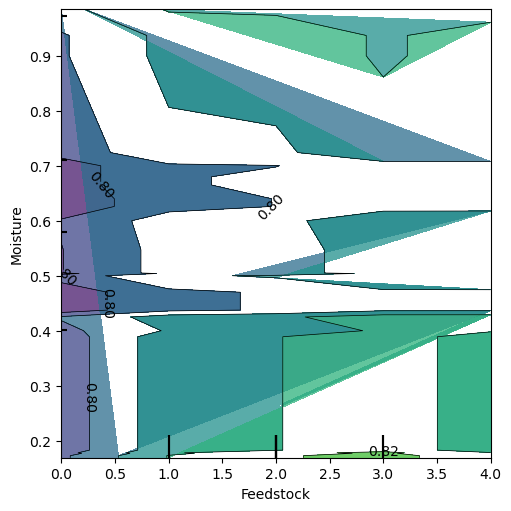

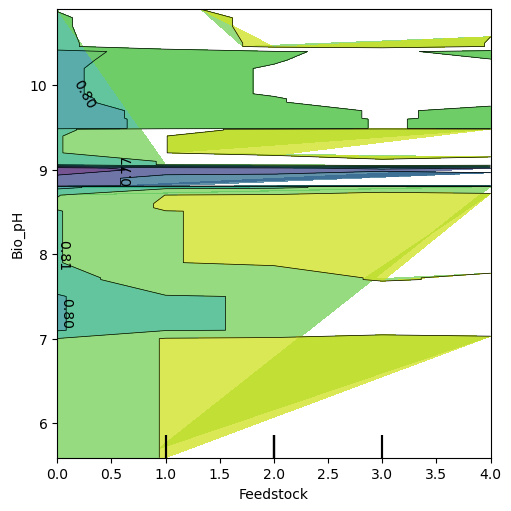

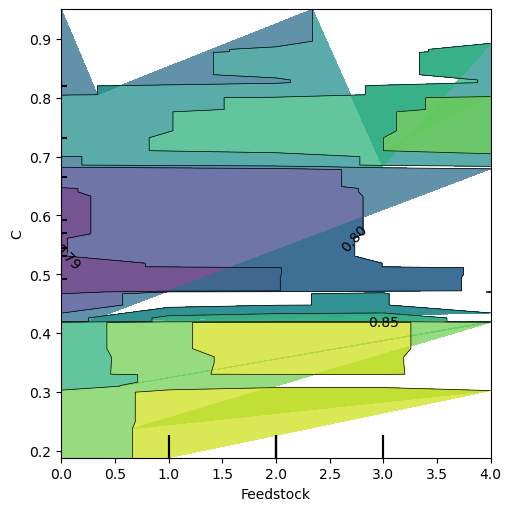

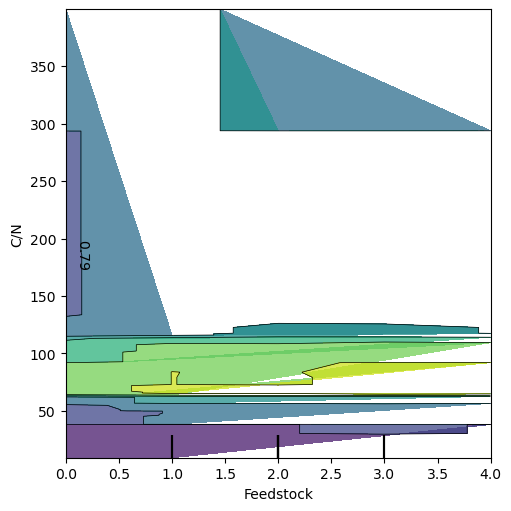

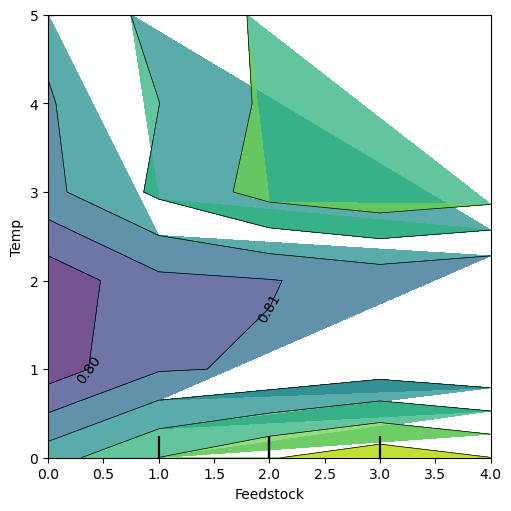

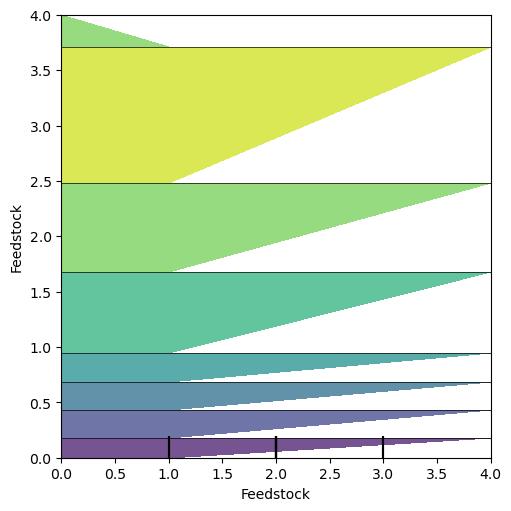

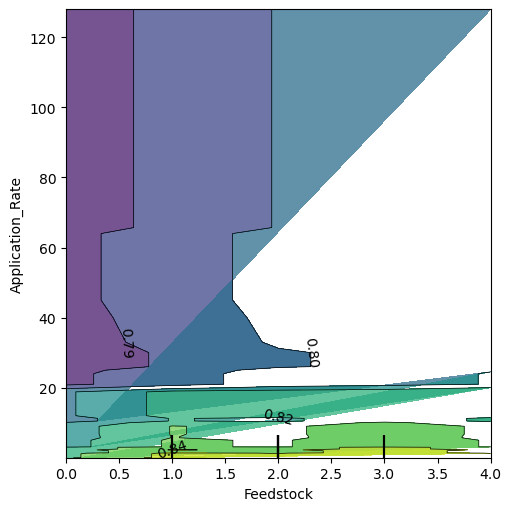

In [116]:
from itertools import product

common_params = {
#     "subsample": 50,
#     "n_jobs": 2,
    "grid_resolution": 400,
    "random_state": 0,
}

features_1D = X.columns.to_list()
features_1D.remove('Region')  
features_2D = list(product(features_1D, repeat=2))

n = 10
start = 12 * n 

for idx_ in range(len(features_2D[start:start+12])):
    idx = start + idx_
    features_info = {
        "features": features_2D[idx:idx+1],
        "kind": "average",
    }

    nrows = 1
    ncols = 1

    _, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5, 5), constrained_layout=True)

    display = PartialDependenceDisplay.from_estimator(
        best_model,
        X,
        **features_info,
        ax=ax,
        **common_params,
    )

    feature_i, feature_j = features_2D[idx]

    if feature_i in cat_features:
        xmin = 0
        xmax = max(list(X[feature_i].unique()))
    else:
        xmin = X[feature_i].min()
        xmax = X[feature_i].max()

    if feature_j in cat_features:
        ymin = 0
        ymax = max(list(X[feature_j].unique()))
    else:
        ymin = X[feature_j].min()
        ymax = X[feature_j].max()

    i, j = 0, 0
    display.axes_[i][j].set_xlim(xmin, xmax)
    display.axes_[i][j].set_ylim(ymin, ymax)

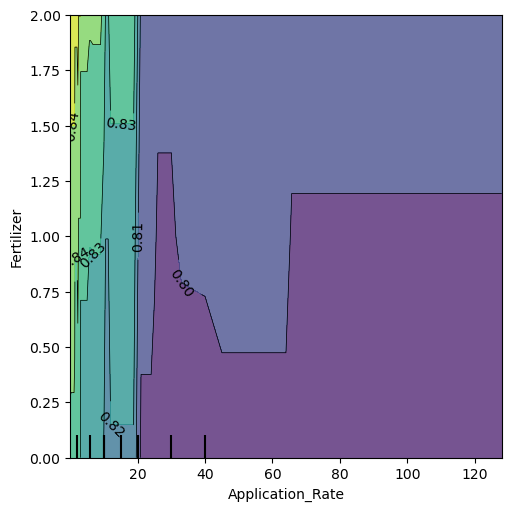

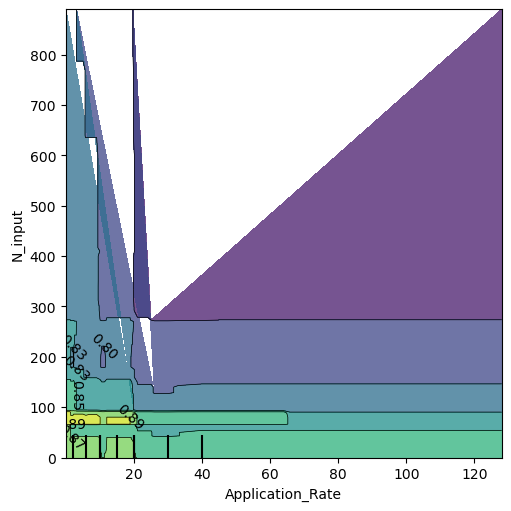

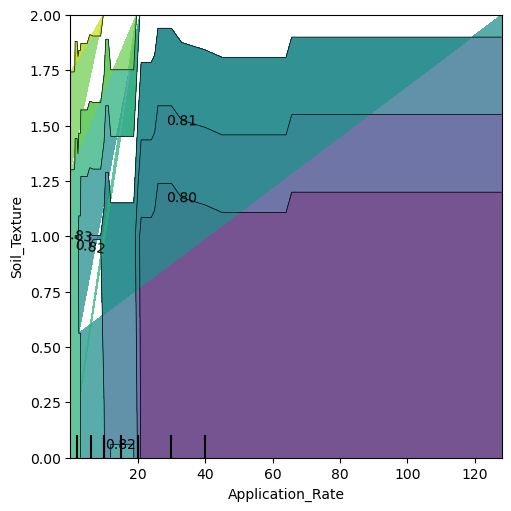

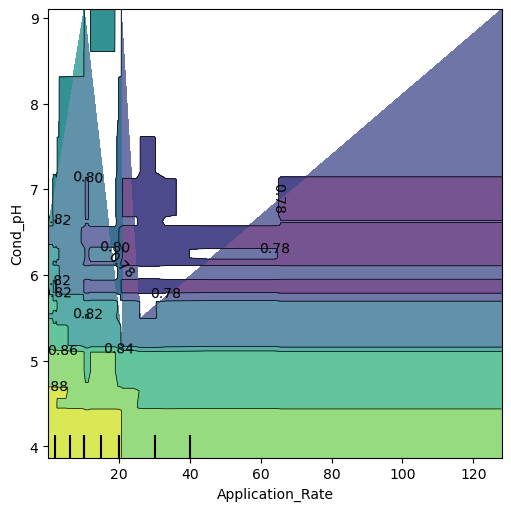

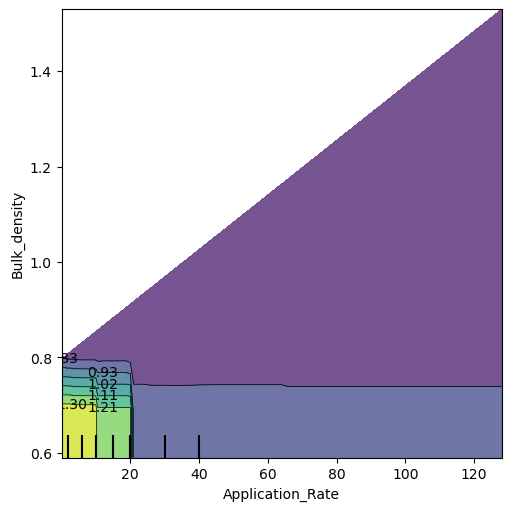

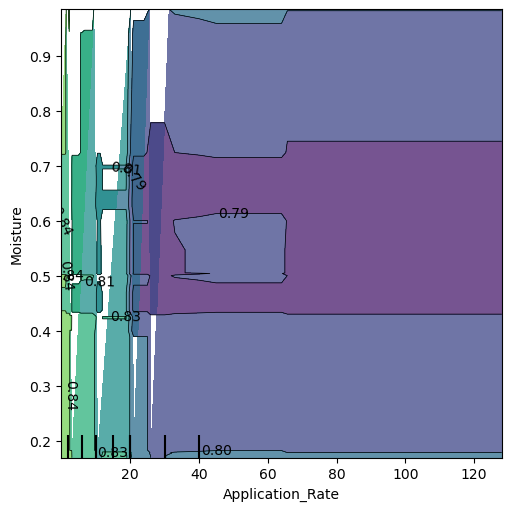

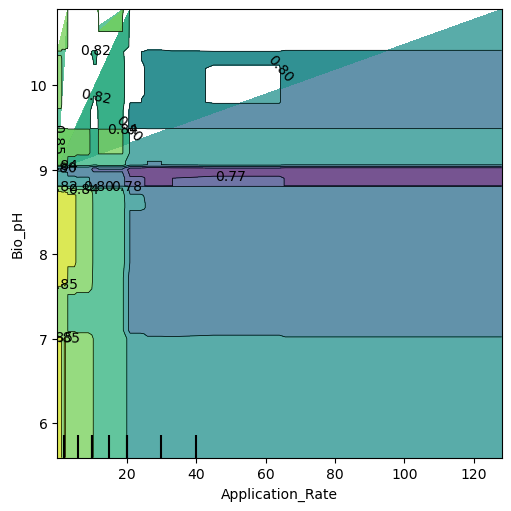

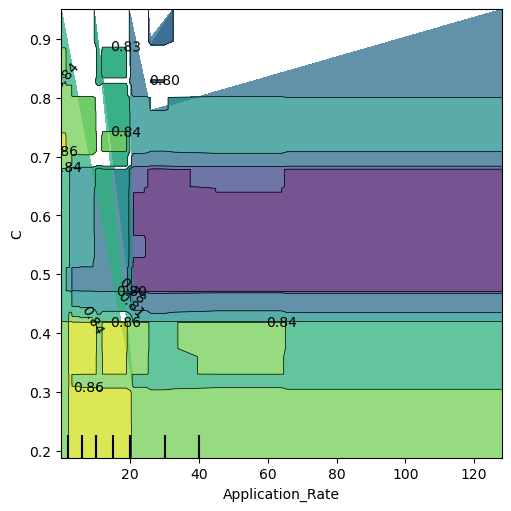

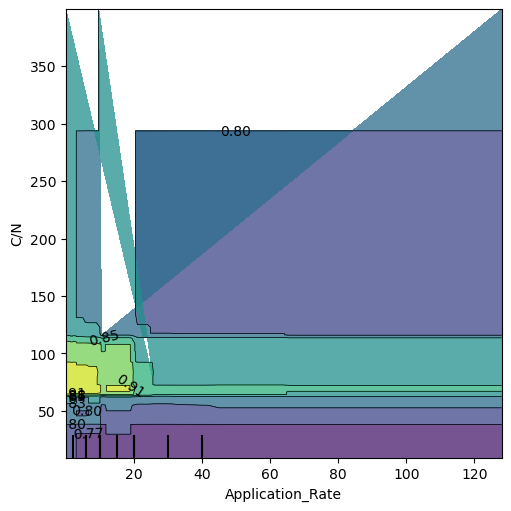

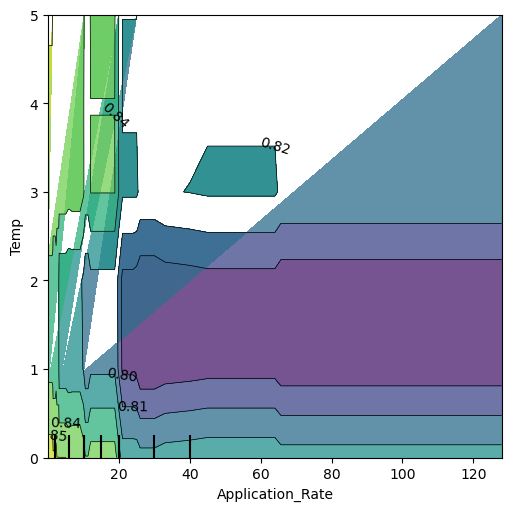

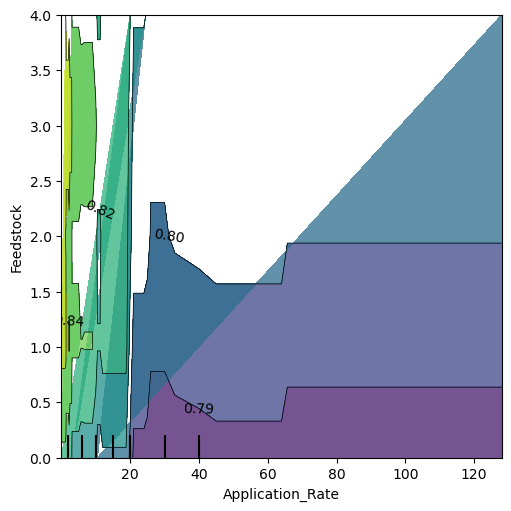

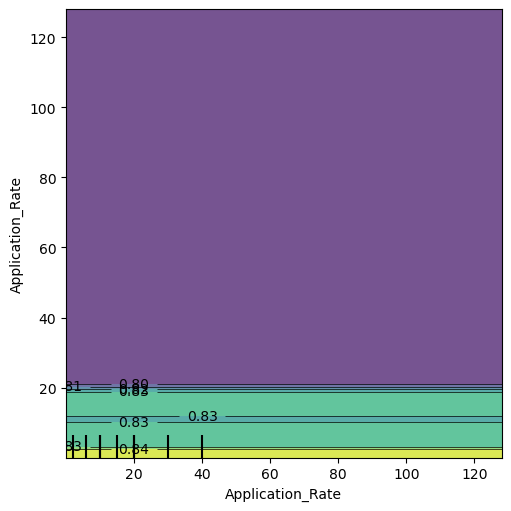

In [117]:
from itertools import product

common_params = {
#     "subsample": 50,
#     "n_jobs": 2,
    "grid_resolution": 400,
    "random_state": 0,
}

features_1D = X.columns.to_list()
features_1D.remove('Region')  
features_2D = list(product(features_1D, repeat=2))

n = 11
start = 12 * n 

for idx_ in range(len(features_2D[start:start+12])):
    idx = start + idx_
    features_info = {
        "features": features_2D[idx:idx+1],
        "kind": "average",
    }

    nrows = 1
    ncols = 1

    _, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5, 5), constrained_layout=True)

    display = PartialDependenceDisplay.from_estimator(
        best_model,
        X,
        **features_info,
        ax=ax,
        **common_params,
    )

    feature_i, feature_j = features_2D[idx]

    if feature_i in cat_features:
        xmin = 0
        xmax = max(list(X[feature_i].unique()))
    else:
        xmin = X[feature_i].min()
        xmax = X[feature_i].max()

    if feature_j in cat_features:
        ymin = 0
        ymax = max(list(X[feature_j].unique()))
    else:
        ymin = X[feature_j].min()
        ymax = X[feature_j].max()

    i, j = 0, 0
    display.axes_[i][j].set_xlim(xmin, xmax)
    display.axes_[i][j].set_ylim(ymin, ymax)